# Imports

In [1]:
from os import listdir
from os.path import join, isdir, isfile
from neo.rawio import BlackrockRawIO
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
import math
from scipy import stats
import gzip
import pickle
from datetime import datetime
from datetime import date as dte 
import pandas as pd
import seaborn as sns
import scipy
from scipy.io import savemat
from tqdm import tqdm
from decimal import *

# Data class definition and methods

In [2]:
class Data:
  def __init__(self, output_folder, load_processed=''):
    self.database = {}
    self.samplingFrequency = 1000
    self.IL_signal = -200 #reference IL signal: IL response should be close to this value for the mouse to be considered usable
    self.output_folder = output_folder
    self.chanid_name = {0 : 'IL1', 1 : 'IL2', 2 : 'IL3', 3 : 'IL4', 4 : 'IL5',
     5 : 'IL6', 6 : 'IL7', 7 : 'IL8', 8 : 'MD1', 9 : 'MD2', 10 : 'MD3', 11 : 'MD4', 
     12 : 'MD5', 13 : 'MD6', 14 : 'MD7', 15 : 'MD8', 16 : 'laser'}
    self.pre_window = 200 #ms before stim
    self.post_window = 200 #ms after stim
    if load_processed != '':
      print('Loading previously processed data')
      saved_pickle_dates = [datetime.strptime(p.rsplit('date_')[1].rsplit('.txt')[0], '%d_%m_%Y') for p in listdir(output_folder) if (isfile(join(output_folder, p)) and 'date' in p)]
      if load_processed == '0':
        selected_pickle = join(self.output_folder, 'date_' + max(saved_pickle_dates).strftime("%d_%m_%Y") + '.txt')
      else:
        selected_pickle = join(self.output_folder, 'date_' + load_processed + '.txt')
      try:
        # filehandler = open(selected_pickle, 'rb') 
        # prev_self = pickle.load(filehandler)
        f = gzip.open(selected_pickle, 'rb')
        print(selected_pickle)
        prev_self = pickle.load(f)
        f.close()
        self.database = prev_self.database
        self.samplingFrequency = prev_self.samplingFrequency
        self.output_folder = prev_self.output_folder
        self.chanid_name = prev_self.chanid_name
        self.pre_window = prev_self.pre_window
      except FileNotFoundError:
        print('No saved database found inthe directory you provided, loading everything')
    
    
  def load_all_mice_from_dir(self, base_dir):
    mice = [fol for fol in listdir(base_dir) if (isdir(join(base_dir, fol)) and 'Mouse' in fol)]
    for mouse in mice:
      self.add_mouse(base_dir, mouse.rsplit('Mouse')[1])


  def add_mouse(self, base_dir, mouseid):
    mousedir = join(base_dir, 'Mouse' + str(mouseid))
    dates = [fol for fol in listdir(mousedir) if isdir(join(mousedir, fol))]
    for date in dates:
      self.add_date_for_mouse(base_dir, mouseid, date)


  def add_date_for_mouse(self, base_dir, mouseid, date):
    #expect only one non-tuning ns2 file on a given date for a given mouse
    mousedate_dir = join(join(base_dir, 'Mouse' + str(mouseid)), date)
    print([f for f in listdir(mousedate_dir)])
    try:
      file_on_date = [f.rsplit('.ns2')[0] for f in listdir(mousedate_dir) if (isfile(join(mousedate_dir, f)) and 'ns2' in f and 'tuning' not in f)][0]
    except IndexError:
      print("This mouse's data is missing")
      print("\n")
      return
    reader = BlackrockRawIO(filename=join(mousedate_dir, file_on_date), nsx_to_load = 2)
    reader.parse_header()
    # The data is in unit of 1/4 µV. This means that 100 in the NSx file equals to 25 µV. All values must be divided by 4.
    raw_sigs = np.array(reader.get_analogsignal_chunk(channel_indexes=None))/4
    # if mouseid == '27352' and date == '092422':
    #   scipy.io.savemat(join(join(base_dir, 'out'), "Mouse27352_092422.mat"), {'Voltage responses' : raw_sigs})
    notched_sigs = np.array([self.notch_filter(chan, 60) if i != 16 else chan for i, chan in enumerate(raw_sigs.T)]).T #remove 60 Hz noise
    filtered_sigs = np.array([self.butter_highpass_filter(chan, 15) if i != 16 else chan for i, chan in enumerate(notched_sigs.T)]).T
    # filtered_sigs = raw_sigs
    if mouseid not in self.database.keys():
      print('Adding a record for Mouse' + str(mouseid) + ' on ' + str(date))
      self.database[mouseid] = {date : {'mouseid' : mouseid, 'date' : date, 
      'filtered_sigs' : filtered_sigs, 'stimcalc' : self.calc_mouse(filtered_sigs, mouseid, date), 
      'plotted_all_regs' : False, 'plotted_all_wires' : False, 'plotted16' : False}}
      chan_sorting, why_bad, good_trials = self.find_good_bad_channels(mouseid, date)
      self.database[mouseid][date]['good_bad_channels'] = chan_sorting
      self.database[mouseid][date]['bad_channels_reason'] = why_bad
      self.database[mouseid][date]['good_trials'] = good_trials
    else:
      if date not in self.database[mouseid].keys():
        print('Adding a record for Mouse' + str(mouseid) + ' on ' + str(date))
        self.database[mouseid][date] = {'mouseid' : mouseid, 'date' : date, 
        'filtered_sigs' : filtered_sigs, 'stimcalc' : self.calc_mouse(filtered_sigs, mouseid, date), 
        'plotted_all_regs' : False, 'plotted_all_wires' : False, 'plotted16' : False}
        chan_sorting, why_bad, good_trials = self.find_good_bad_channels(mouseid, date)
        self.database[mouseid][date]['good_bad_channels'] = chan_sorting
        self.database[mouseid][date]['bad_channels_reason'] = why_bad
        self.database[mouseid][date]['good_trials'] = good_trials
    self.subplot16(mouseid, date)


  def overwrite_mouse_date(self, base_dir, mouseid, date):
    del self.database[mouseid][date]
    self.add_date_for_mouse(base_dir, mouseid, date)


  def delete_date(self, mouseid, date):
    del self.database[mouseid][date]


  def get_chan(self, mouseid, date, chanpos):
    return self.database[mouseid][date]['filtered_sigs'][:, chanpos]


  def get_stimcalc(self, mouseid, date):
    return self.database[mouseid][date]['stimcalc']


  def stim_wire_vector(self, mouseid, date, chanid):
    normalized_all_plotted = self.get_stimcalc(mouseid, date)
    means = []
    stds = []
    #0: channel, 1: stimulus, 2: time points
    for i in range(normalized_all_plotted.shape[2]):
      means.append(np.mean(normalized_all_plotted[chanid, :, i]))
      stds.append(np.std(normalized_all_plotted[chanid, :, i]))
    return [means, stds]


  def leaf_node_iterable(self):
    iterable = []
    mouseids = list(self.database.keys())
    mouseids.sort()
    for m in mouseids:
      dates = list(self.database[m].keys())
      dates.sort()
      for d in dates:
        iterable.append(self.database[m][d])
    return iterable


  def show_mice(self):
    print('Here is what we got:')
    mouseids = list(self.database.keys())
    mouseids.sort()
    for m in mouseids:
      print('Mouse' + str(m))
      dates = list(self.database[m].keys())
      dates.sort()
      for d in dates:
        if self.database[m][d]['is_il_ok']:
          message = ' Usable'
        else:
          message = ' Not usable'
        print('\t ' + str(d) + message)
      print('\n')


  def laser_durations(self, filtered_sigs):
    laser = filtered_sigs[:, 16]
    laser_threshold = laser.copy() 
    laser_threshold[laser_threshold <= 500] = 0
    laser_threshold[laser_threshold > 0] = 1
    ld = []
    prev_val = 0
    start_stim = None
    stop_stim = None
    for i, val in enumerate(laser_threshold):
        if val == 1 and prev_val == 0:
            start_stim = i
            prev_val = 1
        elif val == 0 and prev_val == 1:
            stop_stim = i
            prev_val = 0
            ld.append([start_stim, stop_stim])
    laser_voltages = [np.mean(laser[t[0] + 2 : t[1] - 1])/1000 for t in ld]
    # guess_voltages = []
    # for v in laser_voltages:
    #   if v > (3 + 2.758)/2:
    #     guess_voltages.append(3)
    #   elif v > (2.758 + 2.676)/2:
    #     guess_voltages.append(2.758)
    #   elif v > (2.676 + 2.622)/2:
    #     guess_voltages.append(2.676)
    #   else:
    #     guess_voltages.append(2.622)
    # print(guess_voltages)
    # Add 1 ms at the tail end for off-by-one indexing used next
    adjusted_ld = [[t[0], t[1] + 1] for t in ld]
    
    return adjusted_ld


  def calc_mouse(self, filtered_sigs, mouseid, date):
    adjusted_ld = self.laser_durations(filtered_sigs)
    if len(adjusted_ld) == 0:
      raise ValueError('No stim windows found for mouse ' + mouseid + ' on ' + date) 
    stim_windows = []
    for interval in adjusted_ld:
            duration = interval[1] - interval[0]
            if duration > 4 and duration < 9:
                stim_windows.append([interval[0], interval[0] + 7]) #maybe change 7 to something more accurate when you get the data
    #channels are il1, il2, il3, il4, il5, il6, il7, il8, md1, md2, md3, md4, md5, md6, md7, md8

    normalized_all_plotted = []
    for i in range(16):
      rc = filtered_sigs[:, i]
      normalized_plotted = []
      for interval in stim_windows:
          norm_factor = np.mean(rc[interval[0] - self.pre_window : interval[0]])
          normalized_plotted.append(rc[interval[0] - self.pre_window : interval[1]+self.post_window] - norm_factor)
      normalized_all_plotted.append(normalized_plotted)
    return np.array(normalized_all_plotted)


  def find_good_bad_channels(self, mouseid, date):
    channel_assignments = {i : True for i in range(16)}
    reason_bad = {}
    normalized_all_plotted = self.get_stimcalc(mouseid, date)
    csv_path = join(Path(join(join(join(self.output_folder, '..'), 'Mouse' + mouseid), date)))
    true_labels = pd.read_csv(join(csv_path, 'Mouse' + mouseid + '_' + date + '_OptoLinCx.csv'), header = None)
    true_labels = list(true_labels.iloc[0])
    true_voltage_inputs = true_labels[int(len(true_labels)/2) :]

    if len(np.unique(true_voltage_inputs)) == 4:
      possible_voltages = [3.0, 2.758, 2.676, 2.622]
    else: 
      possible_voltages = [3.0, 2.532, 2.522, 2.513, 2.504]
    assignment = [{possible_voltages[i] : [k for k in range(len(true_voltage_inputs)) if true_voltage_inputs[k] == possible_voltages[i]] for i in range(len(possible_voltages))} for chanid in range(16)]
    for chanid in range(16):
      voltage_IQRs = []
      for inp_v in possible_voltages:
        point_outliers = []
        quantile_distances = []
        IQRs = []
        for j in range(normalized_all_plotted.shape[2]):
          q1 = np.quantile(normalized_all_plotted[chanid, assignment[chanid][inp_v], j], 0.25)
          q3 = np.quantile(normalized_all_plotted[chanid, assignment[chanid][inp_v], j], 0.75)
          IQR = q3 - q1
          IQRs.append(IQR)
          point_outliers.append([1 if ((p < (q1 - 1.5 * IQR)) or (p > (q3 + 1.5 * IQR))) else 0 for p in normalized_all_plotted[chanid, assignment[chanid][inp_v], j]])
          thing = []
          for p in normalized_all_plotted[chanid, assignment[chanid][inp_v], j]:
            if ((p < (q1 - 1.5 * IQR)) or (p > (q3 + 1.5 * IQR))):
              if p < (q1 - 1.5 * IQR):
                thing.append([abs((q1 - 1.5 * IQR) - p)])
              else:
                thing.append([abs(p - (q3 + 1.5 * IQR))])
            else:
              thing.append([0])
          quantile_distances.append(thing)
        outlier_tribunal = np.sum(np.array(point_outliers), axis=0)
        quantile_distance_tribunal = np.mean(np.array(quantile_distances), axis=0)
        #Remove trials where more than half of points are outliers based on quantiles for that time point in stimulation voltage group
        toremove = []
        for i, val in enumerate(assignment[chanid][inp_v]):
          # if quantile_distance_tribunal[i] > 3:
          if (outlier_tribunal[i] > (self.pre_window + self.post_window)/2) or (mouseid == '27352' and date == '092422' and inp_v == 3 and i in [2, 3, 4, 11, 12, 13, 25, 26, 28]):
            toremove.append(val)
        for vl in toremove:
          assignment[chanid][inp_v].remove(vl)
        voltage_IQRs.append(np.mean(IQRs))
      mean_IQRs = np.mean(voltage_IQRs)
      #First, look at the noise in the signal: if pre-stimulus dominant frequency has peaks on average larger than 10, 
      #the channel is bad; alternatively, if signal portion has the lowest point not within 100 of -500uV,
      #it is also considered bad
      swv = self.stim_wire_vector(mouseid, date, chanid)[0]
      A = swv[:self.pre_window] #get 200 ms of signal just before stim
      A = A - np.mean(A)  # remove the DC part of the signal
      # C = np.correlate(A, A, 'same')  # calculate autocorrelation to smooth out the noise
      # P = signal.argrelextrema(C, np.greater)[0]  # caluclate local maxima (this step can be improved)
      P = signal.argrelextrema(A, np.greater)[0]  # caluclate local maxima (this step can be improved)
      mean_resp = np.mean(np.array([np.abs(A[pos]) for pos in P]))
      # print(chanid)
      # print(len(P))
      # print(mean_IQRs)
      # print(mean_resp)
      # print('\n')
      if (mean_resp > 25):
        channel_assignments[chanid] = False
        reason_bad[chanid] = 'High noise'
    return [channel_assignments, reason_bad, assignment]


  def butter_highpass(self, cutoff, order=5):
    normal_cutoff = cutoff/(self.samplingFrequency/2)
    # normal_cutoff = 2 * np.pi * cutoff
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=True)
    return b, a


  def butter_highpass_filter(self, data, cutoff, order=5):
    b, a = self.butter_highpass(cutoff, order=order)
    y = signal.filtfilt(b, a, data)
    return y


  def notch_filter(self, data, freq_to_yeet):
    quality_factor = 30
    b_notch, a_notch = signal.iirnotch(freq_to_yeet, quality_factor, self.samplingFrequency)
    return signal.filtfilt(b_notch, a_notch, data)


  def plot_all(self, replot = False):
    for element in self.leaf_node_iterable():
      mouseid = element['mouseid']
      date = element['date']
      # if not self.database[mouseid][date]['plotted_all_regs'] or replot:
      #   self.plot_all_mouse_regions(mouseid, date)
      # if not self.database[mouseid][date]['plotted_all_wires'] or replot:
      #   self.plot_all_mouse_wires(mouseid, date)
      if not self.database[mouseid][date]['plotted16'] or replot:
        self.subplot16(mouseid, date)


  def subplot16(self, mouseid, date):
    plt.rcParams['figure.figsize'] = (16, 8)
    normalized_all_plotted = self.get_stimcalc(mouseid, date)
    fig, axs = plt.subplots(4, 4)
    excluded = self.bad_chan_ids(mouseid, date)
    reason_bad = self.database[mouseid][date]['bad_channels_reason']

    csv_path = join(Path(join(join(join(self.output_folder, '..'), 'Mouse' + mouseid), date)))
    true_labels = pd.read_csv(join(csv_path, 'Mouse' + mouseid + '_' + date + '_OptoLinCx.csv'), header = None)
    true_labels = list(true_labels.iloc[0])
    true_voltage_inputs = true_labels[int(len(true_labels)/2) :]

    possible_means = ['means_r', 'means_o', 'means_y', 'means_g']
    colors = ['red', 'orange', 'yellow', 'green']
    if len(np.unique(true_voltage_inputs)) == 4:
      possible_voltages = [3.0, 2.758, 2.676, 2.622]
    else: 
      possible_voltages = [3.0, 2.532, 2.522, 2.513, 2.504]
      possible_means.insert(0, 'means_m')
      colors.insert(0, 'maroon')
    assignment = self.database[mouseid][date]['good_trials']
    for chanid in range(16):
      means_dict = {i : [] for i in possible_means}
      for j in range(normalized_all_plotted.shape[2]):
        [means_dict[possible_means[i]].append(np.mean(normalized_all_plotted[chanid, assignment[chanid][possible_voltages[i]], j])) for i in range(len(possible_means))]
        # stds.append(np.std(normalized_all_plotted[chanid, good_ones, :]))
      title = self.chanid_name[chanid] + ' response'
      m_10_25 = {val : max(means_dict[possible_means[i]][self.pre_window + 10: self.pre_window + 25]) for i, val in enumerate(possible_voltages)}
      mn_0_10 = {val : min(means_dict[possible_means[i]][self.pre_window: self.pre_window + 10]) for i, val in enumerate(possible_voltages)}
      for i in range(len(possible_means)):
        axs[math.floor(chanid / 4), chanid % 4].plot(range(-self.pre_window, self.post_window+7), means_dict[possible_means[i]], linewidth=1, color=colors[i]) 
        # if i == 0:
        #   for trl in assignment[chanid][possible_voltages[i]]:
        #     axs[math.floor(chanid / 4), chanid % 4].plot(range(-self.pre_window, self.post_window+7), normalized_all_plotted[chanid, trl, :], linewidth=1, alpha=.1, color=colors[i])
        axs[math.floor(chanid / 4), chanid % 4].text(0.8, 0.45 - 0.08*i, 'n=' + str(len(assignment[chanid][possible_voltages[i]])), horizontalalignment='right', verticalalignment='bottom', fontsize=20, color=colors[i], transform = axs[math.floor(chanid / 4), chanid % 4].transAxes)
        if chanid < 8:
          lookup_dict = mn_0_10
        else:
          lookup_dict = m_10_25
        # axs[math.floor(chanid / 4), chanid % 4].axhspan(lookup_dict[possible_voltages[i]]-0.05, lookup_dict[possible_voltages[i]] + 0.05, color=colors[i])
        # axs[math.floor(chanid / 4), chanid % 4].text(0.4, 0.9 - 0.08*i, str(lookup_dict[possible_voltages[i]]), horizontalalignment='right', verticalalignment='bottom', fontsize=4, color=colors[i], transform = axs[math.floor(chanid / 4), chanid % 4].transAxes)
      # lower_std = [means[i] - stds[i] for i in range(len(means))]
      # upper_std = [means[i] + stds[i] for i in range(len(means))]
      axs[math.floor(chanid / 4), chanid % 4].set_title(title)
      
      # axs[math.floor(chanid / 4), chanid % 4].fill_between(range(-self.pre_window, self.post_window+15), lower_std, upper_std, alpha=.1, color=color)
      axs[math.floor(chanid / 4), chanid % 4].axvspan(0, 7, alpha=0.3, color='blue')
      axs[math.floor(chanid / 4), chanid % 4].axhspan(-0.1, 0.1, color='black')
      axs[math.floor(chanid / 4), chanid % 4].set_ylabel('Normalized Potential [mV]', fontsize=8)
      axs[math.floor(chanid / 4), chanid % 4].set_xlabel('Time [msec]', fontsize=8)
      # axs[math.floor(chanid / 4), chanid % 4].xaxis.label.set_color('white')
      # axs[math.floor(chanid / 4), chanid % 4].yaxis.label.set_color('white')
      # axs[math.floor(chanid / 4), chanid % 4].tick_params(axis='x', colors='white')
      # axs[math.floor(chanid / 4), chanid % 4].tick_params(axis='y', colors='white')
      # axs[math.floor(chanid / 4), chanid % 4].spines['left'].set_color('white')
      # axs[math.floor(chanid / 4), chanid % 4].spines['bottom'].set_color('white')
      # axs[math.floor(chanid / 4), chanid % 4].spines['right'].set_color('white')
      # axs[math.floor(chanid / 4), chanid % 4].spines['top'].set_color('white')
      # if chanid < 8:
      #   axs[math.floor(chanid / 4), chanid % 4].set_ylim([-1500, 550])
      # else:
      #   axs[math.floor(chanid / 4), chanid % 4].set_ylim([-300, 550])
      if chanid in excluded:
        axs[math.floor(chanid / 4), chanid % 4].text(0.5, 0.1, reason_bad[chanid], 
        horizontalalignment='center', 
        verticalalignment='center', fontsize=8,
        transform = axs[math.floor(chanid / 4), chanid % 4].transAxes)
        axs[math.floor(chanid / 4), chanid % 4].set_facecolor('lightsalmon')
    d = Path(join(join(self.output_folder, 'Mouse' + mouseid), date))
    try:
      Path.mkdir(d, parents=True)
    except FileExistsError:
      pass
    title_main = 'All responses in Mouse' + mouseid + ' on ' + date
    plt.tight_layout()
    fig.subplots_adjust(top=0.8)
    fig.suptitle('Responses in Mouse' + mouseid + ' on ' + date, y=0.98)
    plt.savefig(join(d, title_main + ".pdf"), format='pdf', bbox_inches='tight', transparent=True)
    plt.clf()
    plt.cla()
    plt.close('all')
    self.database[mouseid][date]['plotted16'] = True


  def plot_all_mouse_regions(self, mouseid, date):
    self.plot_mouse_region(mouseid, date, 'IL')
    self.plot_mouse_region(mouseid, date, 'NAc')
    self.database[mouseid][date]['plotted_all_regs'] = True


  def plot_all_mouse_wires(self, mouseid, date):
    for chanid in range(16):
      self.plot_wire(mouseid, date, chanid)
    self.database[mouseid][date]['plotted_all_wires'] = True


  def min_il_val(self, mouseid, date):
    normalized_all_plotted = self.get_stimcalc(mouseid, date)
    min_vals = []
    for i in range(8, 16):
      means = []
      for j in range(normalized_all_plotted.shape[2]):
        selection = normalized_all_plotted[i, :, j]
        means.append(np.mean(selection))
      min_vals.append(min(means))
    return min(min_vals)


  def bad_chan_ids(self, mouseid, date):
    chan_assessment = self.database[mouseid][date]['good_bad_channels']
    return [i for i in chan_assessment.keys() if not chan_assessment[i]]


  def plot_mouse_region(self, mouseid, date, region):
    if region == 'IL':
      w = range(0, 7)
    else:
      w = range(8, 16)
    excluded = self.bad_chan_ids(mouseid, date)
    w = [True if x in w and x not in excluded else False for x in range(16)]
    #0: channel, 1: stimulus, 2: time points
    normalized_all_plotted = self.get_stimcalc(mouseid, date)
    means = []
    stds = []
    for i in range(normalized_all_plotted.shape[2]):
      selection = normalized_all_plotted[w, :, i]
      means.append(np.mean(selection))
      stds.append(np.std(selection))
    title = region + ' response in Mouse' + mouseid + ' on ' + date
    self.main_plotter(mouseid, date, means, stds, title)  
    plt.clf()
    plt.cla()
    plt.close('all')


  def plot_wire(self, mouseid, date, chanid):
    #0: channel, 1: stimulus, 2: time points
    normalized_all_plotted = self.get_stimcalc(mouseid, date)
    means = []
    stds = []
    for i in range(normalized_all_plotted.shape[2]):
      means.append(np.mean(normalized_all_plotted[chanid, :, i]))
      stds.append(np.std(normalized_all_plotted[chanid, :, i]))
    title = self.chanid_name[chanid] + ' response in Mouse' + mouseid + ' on ' + date
    self.main_plotter(mouseid, date, means, stds, title) 
    plt.clf()
    plt.cla()
    plt.close('all')


  def main_plotter(self, mouseid, date, means, stds, title):
    # Time from -self.pre_window ms before stim to self.post_window + 15 ms after stim
    plt.plot(range(-self.pre_window, self.post_window+15), means, linewidth=3)
    lower_std = [means[i] - stds[i] for i in range(len(means))]
    upper_std = [means[i] + stds[i] for i in range(len(means))]
    plt.title(title)
    plt.rcParams['figure.figsize'] = (16, 8)
    # plt.fill_between(range(-self.pre_window, self.post_window+15), lower_std, upper_std, alpha=.1)
    plt.axvspan(0, 14, alpha=0.3, color='blue')
    plt.ylabel('Normalized Potential [uV]', fontsize=8)
    plt.xlabel('Time [msec]', fontsize=8)
    d = Path(join(join(self.output_folder, 'Mouse' + mouseid), date))
    try:
      Path.mkdir(d, parents=True)
    except FileExistsError:
      pass
    plt.savefig(join(d, title + ".pdf"), format='pdf', bbox_inches='tight', transparent=True)
    plt.clf()
    plt.cla()
    plt.close('all')


  def save(self):
    f = gzip.open(join(self.output_folder, 'date_' + dte.today().strftime("%d_%m_%Y") + '.txt'), 'wb')
    pickle.dump(self, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()
    # file = open(join(self.output_folder, 'date_' + dte.today().strftime("%d_%m_%Y") + '.txt'), 'wb')
    # pickle.dump(self, file)
    # file.close()


# Load or process data

In [3]:
base_dir = '/mnt/a5e90321-8b33-423f-ad87-3e20a7c42f90/OptoLinCx'
# base_dir = '/Users/kirill/Desktop/lab/OptoLinCx'
sheet_id = "1H0kOaD_8cs5AYVkZ3PigRFJxXZMTYSo9gS9fBwVQwNo"
sheet_name = "usability"
disambig_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

#in the two first cohorts, two mice had left and right IL channels swapped
# swapped_IL = ['55416', '55422']

data = Data(join(base_dir, 'out'), load_processed='0') #load from previous save
# data.delete_date('04102', '070622')
# data = Data(join(base_dir, 'out')) #re-run the whole thing

# ol2_mice = ['27332', '27341', '27351', '27352', '73591', '73592', '73593', '73601', '73602', '27322', '27325', '27335', '27343', '27344', '73604']
# for msid in ol2_mice:
#     data.add_mouse(base_dir, msid)

# data.load_all_mice_from_dir(base_dir)
# data.plot_all()
# print('saving data')
# data.save()


Loading previously processed data
/mnt/a5e90321-8b33-423f-ad87-3e20a7c42f90/OptoLinCx/out/date_28_06_2024.txt


In [4]:
def best_response(data, mouseid, date, chanid):
  normalized_all_plotted = data.get_stimcalc(mouseid, date)

  csv_path = join(Path(join(join(join(data.output_folder, '..'), 'Mouse' + mouseid), date)))
  true_labels = pd.read_csv(join(csv_path, 'Mouse' + mouseid + '_' + date + '_OptoLinCx.csv'), header = None)
  true_labels = list(true_labels.iloc[0])
  true_voltage_inputs = true_labels[int(len(true_labels)/2) :]

  possible_means = ['means_r', 'means_o', 'means_y', 'means_g']
  if len(np.unique(true_voltage_inputs)) == 4:
    five_voltages = False
    possible_voltages = [3.0, 2.758, 2.676, 2.622]
  else: 
    five_voltages = True
    possible_voltages = [3.0, 2.532, 2.522, 2.513, 2.504]
    possible_means.insert(0, 'means_m')

  means_dict = {i : [] for i in possible_means}
  assignment = data.database[mouseid][date]['good_trials']

  columnames = ['mouseid', 'date', 'chanid', 'stim_v', 'trial', 'min_0_10', 'min_10_100', 'max_10_25', 'max_50_200']
  df = pd.DataFrame(columns = columnames)
  for pv in possible_voltages:
    for trial in assignment[chanid][pv]:
      trial_df = pd.DataFrame(columns = columnames)
      trial_df['min_0_10'] = [min(normalized_all_plotted[chanid, trial, range(data.pre_window, data.pre_window + 10)])]
      trial_df['min_10_100'] = [min(normalized_all_plotted[chanid, trial, range(data.pre_window + 10, data.pre_window + 100)])]
      trial_df['max_10_25'] = [max(normalized_all_plotted[chanid, trial, range(data.pre_window + 10, data.pre_window + 25)])]
      trial_df['max_50_200'] = [max(normalized_all_plotted[chanid, trial, range(data.pre_window + 50, data.pre_window + 200)])]
      trial_df['trial'] = [trial]
      trial_df['stim_v'] = [pv]
      trial_df['mouseid'] = [mouseid]
      trial_df['date'] = [date]
      trial_df['chanid'] = [chanid]
      frames = [df, trial_df]
      df = pd.concat(frames)
  

  for j in range(normalized_all_plotted.shape[2]):
    [means_dict[possible_means[i]].append(np.mean(normalized_all_plotted[chanid, assignment[chanid][possible_voltages[i]], j])) for i in range(len(possible_means))]

  out = [[[min(means_dict[pm][data.pre_window : data.pre_window + 10]),
    min(means_dict[pm][data.pre_window + 10 : data.pre_window + 100]),
    max(means_dict[pm][data.pre_window + 10 : data.pre_window + 25]),
    max(means_dict[pm][data.pre_window + 10 : data.pre_window + 100])]
    for pm in possible_means]]
  out.append(df)
  return out


def min_max_response_for_channels(data, mouseid, date, functional_chans):
  outdict = {}
  for chanid in range(16):
    if chanid in functional_chans:
      out_list = best_response(data, mouseid, date, chanid)
      outdict[chanid] = out_list
  return outdict
  

def build_analysis_df(data, disambig_url):
      columnames_m = ['mouseid', 'date', 'group', 'recording_session',
      'IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min', 
      'MD0_0_to_10_min', 'MD1_0_to_10_min', 'MD2_0_to_10_min', 'MD3_0_to_10_min', 'MD4_0_to_10_min', 'MD5_0_to_10_min', 'MD6_0_to_10_min', 'MD7_0_to_10_min',
      'MD0_10_to_100_min', 'MD1_10_to_100_min','MD2_10_to_100_min','MD3_10_to_100_min','MD4_10_to_100_min','MD5_10_to_100_min','MD6_10_to_100_min','MD7_10_to_100_min',
      'MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max',
      'MD0_100_to_200_max', 'MD1_100_to_200_max', 'MD2_100_to_200_max', 'MD3_100_to_200_max', 'MD4_100_to_200_max', 'MD5_100_to_200_max', 'MD6_100_to_200_max', 'MD7_100_to_200_max']

      columnames = ['mouseid', 'date', 'group', 'recording_session', 'functional_chans', 
        'chanid', 'stim_v', 'trial', 'min_0_10', 'min_10_100', 'max_10_25', 'max_50_200']
      masterframe_m = pd.DataFrame(columns = columnames_m)
      masterframe = pd.DataFrame(columns = columnames)
      usability_df = pd.read_csv(disambig_url)
      for element in usability_df.iterrows():
        element = element[1]
        for recording_session in ['Day 1', 'Day 2']:
          # histo_good = element['Histology good']
          # if not histo_good:
          #   continue
          mouseid = str(element['Mouse'])
          if len(mouseid) == 4:
            mouseid = '0' + mouseid
          
          date = str(element[recording_session]).strip('.0')
          print('Looking at mouse' + mouseid + ' on ' + recording_session)
          if len(date) == 5:
            date = '0' + date
          if date == 'nan':
            print('Skipping mouse ' + mouseid + ' on ' + recording_session + ' because there is no recording on this date')
            continue
          try:
            data.get_chan(mouseid, date, 0)
          except KeyError:
            print('No data for mouse ' + mouseid + ' on ' + date)
            continue
          mousedata = data.database[mouseid][date]
          functional_chans = [i for i in mousedata['good_bad_channels'].keys() if mousedata['good_bad_channels'][i]]
          if not any(i in functional_chans for i in range(16)):
            if not any(i in functional_chans for i in range(8)):
              print('Skipping mouse ' + mouseid + ' on ' + recording_session + ' because it has no good IL responses on this day')
            else:
              print('Skipping mouse ' + mouseid + ' on ' + recording_session + ' because it has no good MD responses on this day')
            continue
          
          chandict = min_max_response_for_channels(data, mouseid, date, functional_chans)
          if len(chandict[list(chandict.keys())[0]][0]) == 4:
              stim_p = ['1mW', '0.75mW', '0.5mW', '0.25mW']
          else:
            stim_p = ['3mW', '1mW', '0.75mW', '0.5mW', '0.25mW']
          for i, p in enumerate(stim_p):
            df_m = pd.DataFrame(columns = columnames_m)
            df_m['mouseid'] = [mouseid]
            df_m['date'] = [date]
            df_m['group'] = [element['Group']]
            df_m['recording_session'] = [recording_session]
            df_m['stim_power'] = [p]
            print(mouseid)
            print(recording_session)

            for ch in chandict.keys():
              means, df = chandict[ch]
              if ch < 8:
                df_m['IL' + str(ch) + '_min'] = means[i][0] 
              else:
                print(ch)
                print(means[i][2])
                print('\n')
                df_m['MD' + str(ch-8) + '_0_to_10_min'] = means[i][0] 
                df_m['MD' + str(ch-8) + '_10_to_100_min'] = means[i][1] 
                df_m['MD' + str(ch-8) + '_10_to_25_max'] = means[i][2] 
                df_m['MD' + str(ch-8) + '_100_to_200_max'] = means[i][3] 
            frames_m = [masterframe_m, df_m]
            masterframe_m = pd.concat(frames_m)

          for ch in chandict.keys():
            means, df = chandict[ch]
            df['mouseid'] = [mouseid for i in range(df.shape[0])]
            df['date'] = [date for i in range(df.shape[0])]
            df['group'] = [element['Group'] for i in range(df.shape[0])]
            df['recording_session'] = [recording_session for i in range(df.shape[0])]
            df['functional_chans'] = [functional_chans for i in range(df.shape[0])]
            frames = [masterframe, df]
            masterframe = pd.concat(frames)
            
      return [masterframe, masterframe_m]


sheet_url = "https://docs.google.com/spreadsheets/d/1H0kOaD_8cs5AYVkZ3PigRFJxXZMTYSo9gS9fBwVQwNo/edit#gid=1524970843"
disambig_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
masterframe, masterframe_m = build_analysis_df(data, disambig_url)
masterframe = masterframe.sort_values(by=['mouseid'])
masterframe.to_csv(join(base_dir, 'out/analysis.csv'))
masterframe_m = masterframe_m.sort_values(by=['mouseid'])
masterframe_m.to_csv(join(base_dir, 'out/masterframe.csv'))




Looking at mouse55411 on Day 1
No data for mouse 55411 on 030922
Looking at mouse55411 on Day 2
Skipping mouse 55411 on Day 2 because there is no recording on this date
Looking at mouse55412 on Day 1
No data for mouse 55412 on 030922
Looking at mouse55412 on Day 2
No data for mouse 55412 on 040722
Looking at mouse55413 on Day 1
No data for mouse 55413 on 030922
Looking at mouse55413 on Day 2
No data for mouse 55413 on 040722
Looking at mouse55414 on Day 1
No data for mouse 55414 on 030922
Looking at mouse55414 on Day 2
No data for mouse 55414 on 040722
Looking at mouse55415 on Day 1
No data for mouse 55415 on 030922
Looking at mouse55415 on Day 2
No data for mouse 55415 on 040722
Looking at mouse55421 on Day 1
Skipping mouse 55421 on Day 1 because there is no recording on this date
Looking at mouse55421 on Day 2
Skipping mouse 55421 on Day 2 because there is no recording on this date
Looking at mouse55422 on Day 1
No data for mouse 55422 on 031122
Looking at mouse55422 on Day 2
No data

# Irrelevant code for Matlab conversion

In [7]:
#This chunk of code is for Kaf to get ns2 files converted to mat files without any data modification
base_dir = '..'
func_channels = masterframe[['mouseid', 'date', 'functional_chans']].drop_duplicates(subset=['mouseid', 'date'])
chan_names = np.array(['IL0', 'IL1', 'IL2', 'IL3', 'IL4', 'IL5', 'IL6', 'IL7', 'MD0', 'MD1', 'MD2', 'MD3', 'MD4', 'MD5', 'MD6', 'MD7'])
mat_out_dir = '../out/OptoLinCx_MatLab_Export'
Path.mkdir(Path(mat_out_dir), parents=True, exist_ok=True)
for index, row in tqdm(func_channels.iterrows()):
    outpt = []
    ms = str(row['mouseid'])
    dt = str(row['date'])
    mousedate_dir = join(join(base_dir, 'Mouse' + ms), dt)
    file_on_date = [f.rsplit('.ns2')[0] for f in listdir(mousedate_dir) if (isfile(join(mousedate_dir, f)) and 'ns2' in f and 'tuning' not in f)][0]
    reader = BlackrockRawIO(filename=join(mousedate_dir, file_on_date), nsx_to_load = 2)
    reader.parse_header()
    # The data is in unit of 1/4 µV. This means that 100 in the NSx file equals to 25 µV. All values must be divided by 4.
    raw_sigs = np.array(reader.get_analogsignal_chunk(channel_indexes=None))/4
    func_chan = {}
    for chn in row['functional_chans']:
        region = chan_names[chn]
        outpt.append((ms, dt, region, np.array(raw_sigs[:, chn], dtype=object)))
    outpt = np.array(outpt, dtype=[('mouse', object), ('recording_date', object), ('region', object), ('signal', object)])
    msdt = 'Mouse' + ms + '_' + dt
    scipy.io.savemat(join(mat_out_dir, msdt + '.mat'), {msdt: outpt})


0it [05:08, ?it/s]


KeyboardInterrupt: 

In [ ]:
#This cell is once again for Kaf to have a table with the time of first laser pulse for each retained recording
mice = []
dates = []
times = []
func_channels = masterframe[['mouseid', 'date', 'functional_chans']].drop_duplicates(subset=['mouseid', 'date'])
for index, row in tqdm(func_channels.iterrows()):
    ms = str(row['mouseid'])
    dt = str(row['date'])
    mousedate_dir = join(join(base_dir, 'Mouse' + ms), dt)
    file_on_date = [f.rsplit('.ns2')[0] for f in listdir(mousedate_dir) if (isfile(join(mousedate_dir, f)) and 'ns2' in f and 'tuning' not in f)][0]
    reader = BlackrockRawIO(filename=join(mousedate_dir, file_on_date), nsx_to_load = 2)
    reader.parse_header()
    # The data is in unit of 1/4 µV. This means that 100 in the NSx file equals to 25 µV. All values must be divided by 4.
    raw_sigs = np.array(reader.get_analogsignal_chunk(channel_indexes=None))/4
    laser = raw_sigs[:, 16]
    laser_threshold = laser.copy() 
    laser_threshold[laser_threshold <= 500] = 0
    laser_threshold[laser_threshold > 0] = 1
    for i, val in enumerate(laser_threshold):
        if val == 1:
            mice.append(ms)
            dates.append(dt)
            times.append(i)
            break
clmnnames = ['mouse', 'date', 'time']
laser_start = pd.DataFrame(columns = clmnnames)
laser_start['mouse'] = mice
laser_start['date'] = dates
laser_start['time'] = times
csv_out_path = '../out/OptoLinCx_MatLab_Export/laser_start.csv'
laser_start.to_csv(csv_out_path)
laser_start.head(60)


0it [00:00, ?it/s]

30it [01:08,  2.29s/it]


,mouse,date,time
0,27322,092022,599988
1,27322,093022,599998
2,27325,093022,599978
3,27325,092022,599989
4,27332,093022,599968
5,27332,092022,599979
6,27335,100122,599978
7,27335,092122,599977
8,27341,100322,599978
9,27341,092322,599978


# Start data processing

/tmp/ipykernel_648334/2035857673.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day1_df['IL_mean_min_0_10_d1'] = day1_df['mean_IL']
/tmp/ipykernel_648334/2035857673.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day1_df['IL_min_min_0_10_d1'] = day1_df['min_IL']
/tmp/ipykernel_648334/2035857673.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

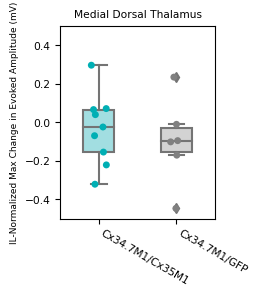

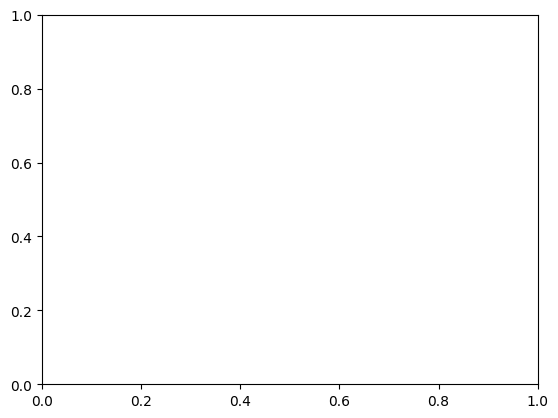

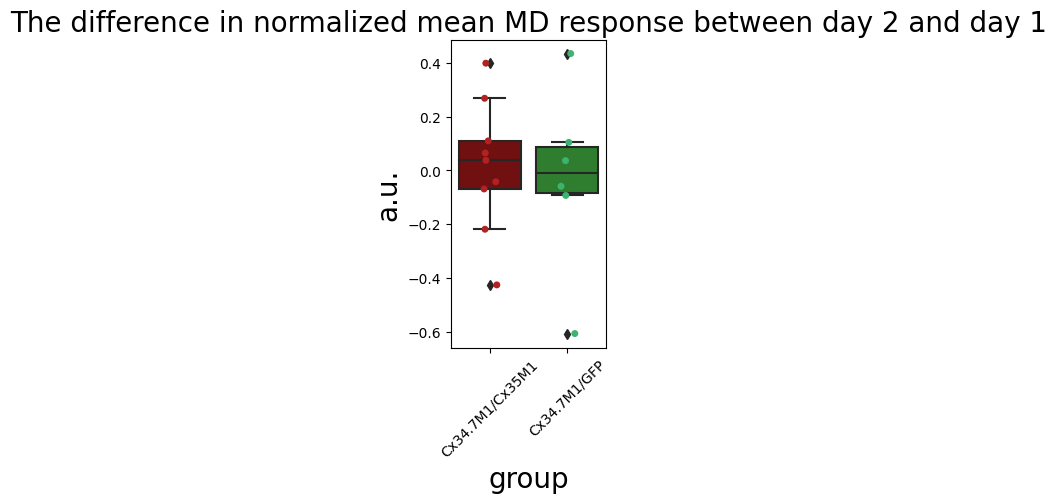

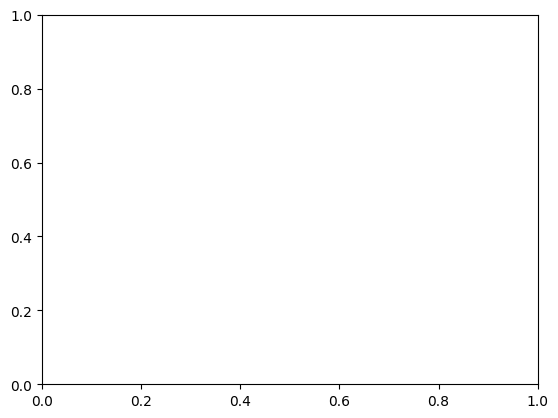

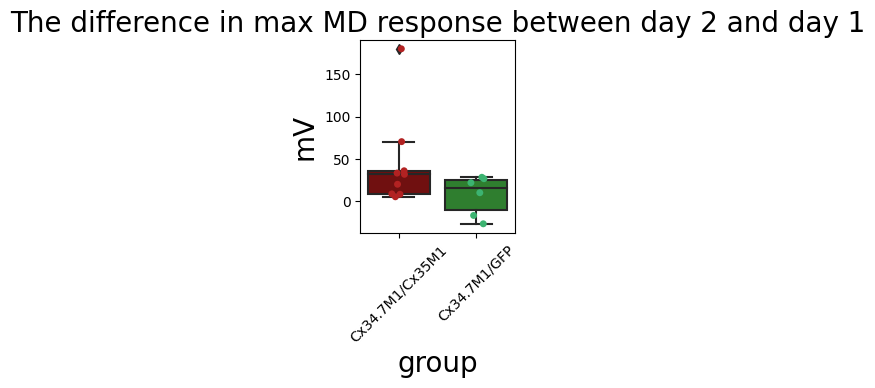

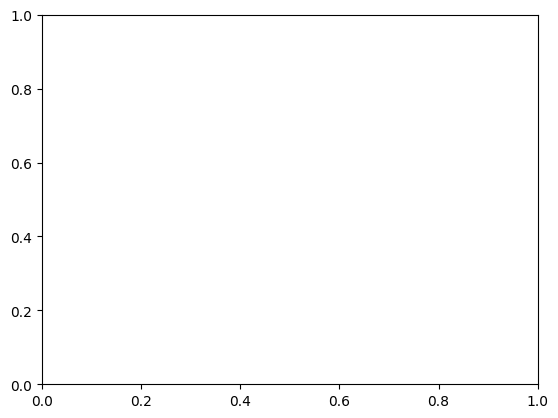

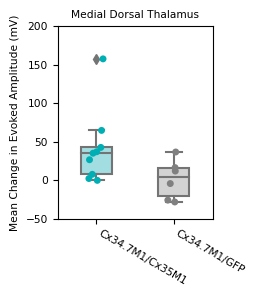

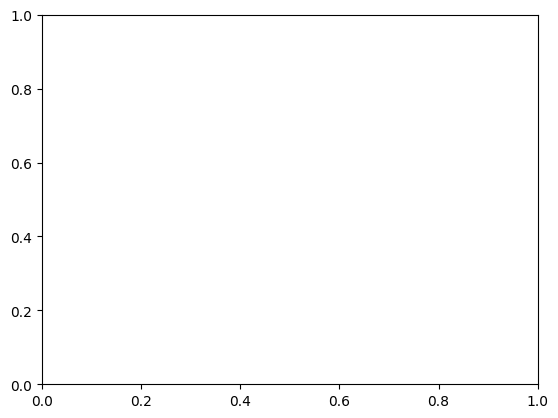

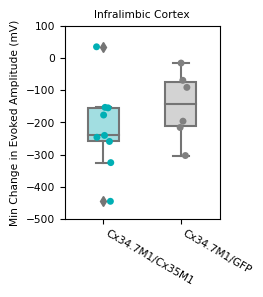

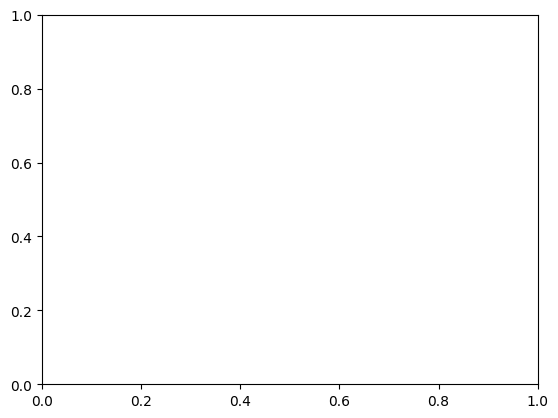

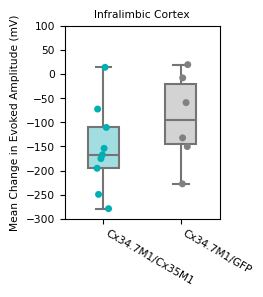

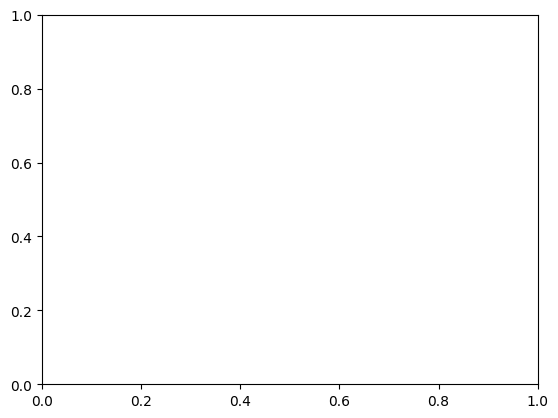

In [5]:
kaf_df = masterframe_m.copy()
kaf_df = kaf_df.sort_values(by=['mouseid', 'group'])
#Exclude mice that have no MD response on day 2 at 3mW:
kaf_df = kaf_df.loc[~(kaf_df['mouseid'].isin(['27324', '27353']))]
kaf_df = kaf_df[['mouseid', 'date', 'group', 'recording_session', 'stim_power',
      'IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min', 
      'MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']]
kaf_df['mean_IL'] = kaf_df[['IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min']].mean(axis=1)
kaf_df['mean_MD'] = kaf_df[['MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']].mean(axis=1)
kaf_df['min_IL'] = kaf_df[['IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min']].min(axis=1)
kaf_df['max_MD'] = kaf_df[['MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']].max(axis=1)
kaf_df = kaf_df.loc[kaf_df['stim_power'].isin(['1mW'])]
# for m in kaf_df['mouseid'].unique():
#       mouseslice = kaf_df.loc[kaf_df['mouseid'] == m]
#       if len(list(mouseslice['recording_session'].unique())) < 2:
#             continue
#       min_IL_d2 = list(mouseslice.loc[mouseslice['recording_session'] == 'Day 2']['min_IL'])[0]
#       min_IL_d2_channel = [i for i in range(8) if list(mouseslice.loc[mouseslice['recording_session'] == 'Day 2']['IL' + str(i) + '_min'])[0] == min_IL_d2][0]

#       min_IL_d1 = list(mouseslice.loc[mouseslice['recording_session'] == 'Day 1']['min_IL'])[0]
#       min_IL_d1_channel = [i for i in range(8) if list(mouseslice.loc[mouseslice['recording_session'] == 'Day 1']['IL' + str(i) + '_min'])[0] == min_IL_d1][0]
#       if min_IL_d1_channel != min_IL_d2_channel:
#            kaf_df.loc[(kaf_df['mouseid'] == m) & (kaf_df['recording_session'] == 'Day 1')]['min_IL'] = kaf_df.loc[(kaf_df['mouseid'] == m) & (kaf_df['recording_session'] == 'Day 1')]['IL' + str(min_IL_d2_channel) + '_min']
      
#       max_MD_d2 = list(mouseslice.loc[mouseslice['recording_session'] == 'Day 2']['max_MD'])[0]
#       max_MD_d2_channel = [i for i in range(8) if list(mouseslice.loc[mouseslice['recording_session'] == 'Day 2']['MD' + str(i) + '_10_to_25_max'])[0] == max_MD_d2][0]

#       max_MD_d1 = list(mouseslice.loc[mouseslice['recording_session'] == 'Day 1']['max_MD'])[0]
#       max_MD_d1_channel = [i for i in range(8) if list(mouseslice.loc[mouseslice['recording_session'] == 'Day 1']['MD' + str(i) + '_10_to_25_max'])[0] == max_MD_d1][0]
      
#       if max_MD_d1_channel != max_MD_d2_channel:
#            kaf_df.loc[(kaf_df['mouseid'] == m) & (kaf_df['recording_session'] == 'Day 1')]['max_MD'] = kaf_df.loc[(kaf_df['mouseid'] == m) & (kaf_df['recording_session'] == 'Day 1')]['MD' + str(max_MD_d2_channel) + '_10_to_25_max']

      # if min_IL_d1_channel != min_IL_d2_channel:
      #       print('IL')
      #       print(m)
      #       print('\n')
      # elif max_MD_d1_channel != max_MD_d2_channel:
      #       print('MD')
      #       print(m)
      #       print('\n')
# sns.scatterplot(kaf_df.loc[kaf_df['recording_session'] == 'Day 1']['mean_MD'], kaf_df.loc[kaf_df['recording_session'] == 'Day 1']['mean_IL'])
# print(kaf_df.loc[kaf_df['recording_session'] == 'Day 1'][['mean_MD', 'mean_IL']].corr(method='pearson'))

kaf_df_mean = kaf_df[['mouseid', 'date', 'group', 'recording_session', 'mean_IL', 'mean_MD', 'min_IL', 'max_MD']]
# kaf_df_mean = kaf_df_mean.loc[kaf_df_mean['stim_power'].isin(['1mW'])]
# kaf_df['split_value'] = kaf_df['chanid'].apply(lambda x: 'IL' if x < 8 else 'MD')
# kaf_df = kaf_df.loc[~((kaf_df['mouseid'].isin(['27335'])) & ((kaf_df['chanid'] == 13) | (kaf_df['chanid'] == 3)))]
day1_df = kaf_df_mean.loc[kaf_df_mean['recording_session'].isin(['Day 1'])]
day2_df = kaf_df_mean.loc[kaf_df_mean['recording_session'].isin(['Day 2'])]
day1_df['IL_mean_min_0_10_d1'] = day1_df['mean_IL']
day1_df['IL_min_min_0_10_d1'] = day1_df['min_IL']
day1_df['MD_mean_max_10_25_d1'] = day1_df['mean_MD']
day1_df['MD_max_max_10_25_d1'] = day1_df['max_MD']
day2_df['IL_mean_min_0_10_d2'] = day2_df['mean_IL']
day2_df['IL_min_min_0_10_d2'] = day2_df['min_IL']
day2_df['MD_mean_max_10_25_d2'] = day2_df['mean_MD']
day2_df['MD_max_max_10_25_d2'] = day2_df['max_MD']

day1_df = day1_df[['mouseid', 'group', 'IL_mean_min_0_10_d1', 'IL_min_min_0_10_d1', 'MD_mean_max_10_25_d1', 'MD_max_max_10_25_d1']]
day2_df = day2_df[['mouseid', 'group', 'IL_mean_min_0_10_d2', 'IL_min_min_0_10_d2', 'MD_mean_max_10_25_d2', 'MD_max_max_10_25_d2']]
day_region_split_df = day1_df.merge(day2_df, how='inner', on=['mouseid', 'group'])

day_region_split_df['norm_diff_max'] = (day_region_split_df['MD_max_max_10_25_d2']/day_region_split_df['IL_min_min_0_10_d2'] - day_region_split_df['MD_max_max_10_25_d1']/day_region_split_df['IL_min_min_0_10_d1'])/(day_region_split_df['MD_max_max_10_25_d1']/day_region_split_df['IL_min_min_0_10_d1'])

day_region_split_df['norm_diff_mean'] = (day_region_split_df['MD_mean_max_10_25_d2']/day_region_split_df['IL_mean_min_0_10_d2'] - day_region_split_df['MD_mean_max_10_25_d1']/day_region_split_df['IL_mean_min_0_10_d1'])/(day_region_split_df['MD_mean_max_10_25_d1']/day_region_split_df['IL_mean_min_0_10_d1'])

day_region_split_df['diff_max'] = (day_region_split_df['MD_max_max_10_25_d2'] - day_region_split_df['MD_max_max_10_25_d1'])

day_region_split_df['diff_mean'] = (day_region_split_df['MD_mean_max_10_25_d2'] - day_region_split_df['MD_mean_max_10_25_d1'])

day_region_split_df = day_region_split_df.sort_values(by=['group'])
day_region_split_df['group'] = day_region_split_df['group'].apply(lambda x: 'Cx35M1' if x == '1' else 'GFP')
day_region_split_df['IL_diff_mean'] = day_region_split_df['IL_mean_min_0_10_d2'] - day_region_split_df['IL_mean_min_0_10_d1']
day_region_split_df['IL_diff_min'] = day_region_split_df['IL_min_min_0_10_d2'] - day_region_split_df['IL_min_min_0_10_d1']
day_region_split_df.to_csv(join(base_dir, 'out/Finaldata.csv'))

day_region_split_df['group'] = day_region_split_df['group'].apply(lambda x: 'Cx34.7M1/Cx35M1' if x == 'Cx35M1' else 'Cx34.7M1/GFP')

#Normalized max MD
fig = plt.figure(figsize=(2,2.5))
plt.title('Medial Dorsal Thalamus', fontsize=7.7, color='black')
ax = sns.boxplot(data=day_region_split_df, x="group", y="norm_diff_max",  width=0.4, palette={'Cx34.7M1/Cx35M1' : '#98E8EB', 'Cx34.7M1/GFP' : 'lightgray'})
sns.stripplot(data=day_region_split_df, x="group", y="norm_diff_max", dodge=False, palette={'Cx34.7M1/Cx35M1' : '#00afb4', 'Cx34.7M1/GFP' : 'gray'})
plt.ylabel('IL-Normalized Max Change in Evoked Amplitude (mV)', fontsize=6.5)
ax.set_xticklabels(['Cx34.7M1/Cx35M1', 'Cx34.7M1/GFP'], rotation=-30, ha='left')
ax.set_ylim([-0.5,0.5])
ax.tick_params(axis='both', labelsize=7.7)
ax.set(xlabel=None)

# red and green colormap
# fig = plt.figure(figsize=(2,4))
# plt.title('The difference in normalized max MD response between day 2 and day 1', fontsize=20, color='black')
# plt.xlabel('Experimental Groups', fontsize=20)
# ax = sns.boxplot(data=day_region_split_df, x="group", y="norm_diff_max", palette={'Cx34.7M1/Cx35M1' : 'maroon', 'Cx34.7M1/GFP' : 'forestgreen'})
# sns.stripplot(data=day_region_split_df, x="group", y="norm_diff_max", dodge=True, palette={'Cx34.7M1/Cx35M1' : 'firebrick', 'Cx34.7M1/GFP' : 'mediumseagreen'})
# plt.ylabel('a.u.', fontsize=20)
# ax.tick_params(axis='x', rotation=45)

#for presentation on black background
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
# ax.spines['left'].set_color('white')
# ax.spines['bottom'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.spines['top'].set_color('white')
# for i, artist in enumerate(ax.artists):
#     col = artist.get_facecolor()
#     artist.set_edgecolor('gray')

#     for j in range(i*6, i*6+6):
#         line = ax.lines[j]
#         line.set_color('gray')
#         line.set_mfc('gray')
#         line.set_mec('gray')

plt.savefig(join(join(base_dir, 'out'), "max_norm_diff_new_colors.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.show()
plt.clf()
plt.cla()

#Normalized mean MD
fig = plt.figure(figsize=(2,4))
plt.title('The difference in normalized mean MD response between day 2 and day 1', fontsize=20, color='black')
plt.xlabel('Experimental Groups', fontsize=20)
ax = sns.boxplot(data=day_region_split_df, x="group", y="norm_diff_mean", palette={'Cx34.7M1/Cx35M1' : 'maroon', 'Cx34.7M1/GFP' : 'forestgreen'})
sns.stripplot(data=day_region_split_df, x="group", y="norm_diff_mean", dodge=True, palette={'Cx34.7M1/Cx35M1' : 'firebrick', 'Cx34.7M1/GFP' : 'mediumseagreen'})
plt.ylabel('a.u.', fontsize=20)
ax.tick_params(axis='x', rotation=45)
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
# ax.spines['left'].set_color('white')
# ax.spines['bottom'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.spines['top'].set_color('white')
# for i, artist in enumerate(ax.artists):
#     col = artist.get_facecolor()
#     artist.set_edgecolor('gray')

#     for j in range(i*6, i*6+6):
#         line = ax.lines[j]
#         line.set_color('gray')
#         line.set_mfc('gray')
#         line.set_mec('gray')

plt.savefig(join(join(base_dir, 'out'), "mean_norm_diff.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.show()
plt.clf()
plt.cla()

#Max MD
fig = plt.figure(figsize=(2,2.5))
plt.title('The difference in max MD response between day 2 and day 1', fontsize=20, color='black')
plt.xlabel('Experimental Groups', fontsize=20)
ax = sns.boxplot(data=day_region_split_df, x="group", y="diff_max", palette={'Cx34.7M1/Cx35M1' : 'maroon', 'Cx34.7M1/GFP' : 'forestgreen'})
sns.stripplot(data=day_region_split_df, x="group", y="diff_max", dodge=True, palette={'Cx34.7M1/Cx35M1' : 'firebrick', 'Cx34.7M1/GFP' : 'mediumseagreen'})
plt.ylabel('mV', fontsize=20)
ax.tick_params(axis='x', rotation=45)
plt.savefig(join(join(base_dir, 'out'), "max_diff.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.show()
plt.clf()
plt.cla()

#Mean MD
fig = plt.figure(figsize=(2,2.5))
plt.title('Medial Dorsal Thalamus', fontsize=7.7, color='black')
ax = sns.boxplot(data=day_region_split_df, x="group", y="diff_mean",  width=0.4, palette={'Cx34.7M1/Cx35M1' : '#98E8EB', 'Cx34.7M1/GFP' : 'lightgray'})
sns.stripplot(data=day_region_split_df, x="group", y="diff_mean", dodge=False, palette={'Cx34.7M1/Cx35M1' : '#00afb4', 'Cx34.7M1/GFP' : 'gray'})
plt.ylabel('Mean Change in Evoked Amplitude (mV)', fontsize=7.7)
ax.set_xticklabels(['Cx34.7M1/Cx35M1', 'Cx34.7M1/GFP'], rotation=-30, ha='left')
ax.set_ylim([-50,200])
ax.tick_params(axis='both', labelsize=7.7)
ax.set(xlabel=None)
plt.savefig(join(join(base_dir, 'out'), "MD_mean_diff.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.show()
plt.clf()
plt.cla()

#Min_IL
fig = plt.figure(figsize=(2,2.5))
plt.title('Infralimbic Cortex', fontsize=7.7, color='black')
ax = sns.boxplot(data=day_region_split_df, x="group", y="IL_diff_min",  width=0.4, palette={'Cx34.7M1/Cx35M1' : '#98E8EB', 'Cx34.7M1/GFP' : 'lightgray'})
sns.stripplot(data=day_region_split_df, x="group", y="IL_diff_min", dodge=False, palette={'Cx34.7M1/Cx35M1' : '#00afb4', 'Cx34.7M1/GFP' : 'gray'})
plt.ylabel('Min Change in Evoked Amplitude (mV)', fontsize=7.7)
ax.set_xticklabels(['Cx34.7M1/Cx35M1', 'Cx34.7M1/GFP'], rotation=-30, ha='left')
# ax.set_ylim([-50,200])
ax.tick_params(axis='both', labelsize=7.7)
ax.set(xlabel=None)
ax.set_ylim([-500,100])
plt.savefig(join(join(base_dir, 'out'), "IL_min_diff.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.show()
plt.clf()
plt.cla()

#Mean_IL
fig = plt.figure(figsize=(2,2.5))
plt.title('Infralimbic Cortex', fontsize=7.7, color='black')
ax = sns.boxplot(data=day_region_split_df, x="group", y="IL_diff_mean",  width=0.4, palette={'Cx34.7M1/Cx35M1' : '#98E8EB', 'Cx34.7M1/GFP' : 'lightgray'})
sns.stripplot(data=day_region_split_df, x="group", y="IL_diff_mean", dodge=False, palette={'Cx34.7M1/Cx35M1' : '#00afb4', 'Cx34.7M1/GFP' : 'gray'})
plt.ylabel('Mean Change in Evoked Amplitude (mV)', fontsize=7.7)
ax.set_xticklabels(['Cx34.7M1/Cx35M1', 'Cx34.7M1/GFP'], rotation=-30, ha='left')
ax.set_ylim([-300,100])
ax.tick_params(axis='both', labelsize=7.7)
ax.set(xlabel=None)
plt.savefig(join(join(base_dir, 'out'), "IL_mean_diff.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.show()
plt.clf()
plt.cla()

day_region_split_df['group'] = day_region_split_df['group'].apply(lambda x: 'Cx35M1' if x == 'Cx34.7M1/Cx35M1' else 'GFP')


# ANOVA for days/regions

/tmp/ipykernel_648334/2520993380.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_mean['group'] = sub_df_mean['group'].apply(lambda x: 'Cx34.7M1/Cx35M1' if x == '1' else 'Cx34.7M1/GFP')
/tmp/ipykernel_648334/2520993380.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_mean['mean_IL_log'] = np.log(sub_df_mean['mean_IL'] + shift_value)
/tmp/ipykernel_648334/2520993380.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde



Untransformed multivariate normality:
Group ('Cx34.7M1/Cx35M1', 'Day 1'): HZResults(hz=0.3590619903287115, pval=0.34187028360394345, normal=True)
Group ('Cx34.7M1/Cx35M1', 'Day 2'): HZResults(hz=0.40712284117908526, pval=0.2418744936328306, normal=True)
Group ('Cx34.7M1/GFP', 'Day 1'): HZResults(hz=0.3909495983598058, pval=0.18463448599776888, normal=True)
Group ('Cx34.7M1/GFP', 'Day 2'): HZResults(hz=0.3540139958501668, pval=0.25047272314874325, normal=True)


        Chi2   df      pval  equal_cov
box  6.49443  3.0  0.089882       True
                  Multivariate linear model
                                                             
-------------------------------------------------------------
        Intercept        Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.3590 2.0000 25.0000 22.3234 0.0000
          Pillai's trace 0.6410 2.0000 25.0000 22.3234 0.0000
  Hotelling-Lawley trace 1.7859 2.0000

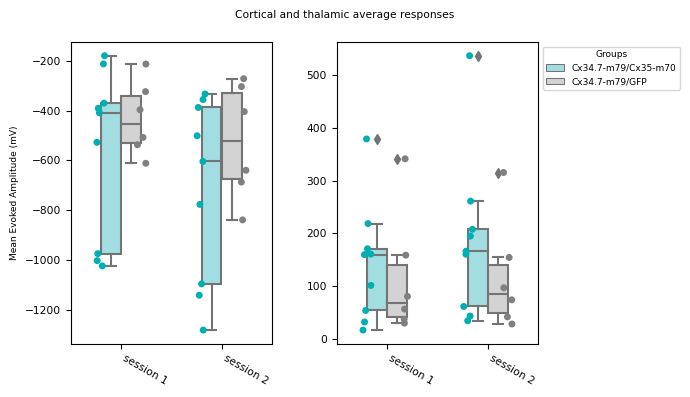

In [30]:
from statsmodels.multivariate.manova import MANOVA
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
import pingouin as pg
from scipy.stats import shapiro, levene
from statsmodels.formula.api import ols
import statsmodels.api as sm

sub_df = masterframe_m.copy()
sub_df = sub_df.sort_values(by=['mouseid', 'group'])
#Exclude mice that have no MD response on day 2 at 3mW:
sub_df = sub_df.loc[~(sub_df['mouseid'].isin(['27324', '27353']))]
sub_df = sub_df[['mouseid', 'date', 'group', 'recording_session', 'stim_power',
      'IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min', 
      'MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']]
sub_df['mean_IL'] = sub_df[['IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min']].mean(axis=1)
sub_df['mean_MD'] = sub_df[['MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']].mean(axis=1)
sub_df['min_IL'] = sub_df[['IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min']].min(axis=1)
sub_df['max_MD'] = sub_df[['MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']].max(axis=1)
sub_df = sub_df.loc[sub_df['stim_power'].isin(['1mW'])]
sub_df_mean = sub_df[['mouseid', 'date', 'group', 'recording_session', 'mean_IL', 'mean_MD', 'min_IL', 'max_MD']]

#Rename the group names for the boxplot
sub_df_mean['group'] = sub_df_mean['group'].apply(lambda x: 'Cx34.7M1/Cx35M1' if x == '1' else 'Cx34.7M1/GFP')

# Apply log transformation to the dependent variables
# Find the minimum value in 'mean_IL'
min_value = sub_df_mean['mean_IL'].min()

# If min_value is less than or equal to 0, shift all values to make them positive
if min_value <= 0:
    shift_value = abs(min_value) + 1  # Shift by more than the absolute minimum to ensure all positive
else:
    shift_value = 0  # No shift needed if all values are already positive

# Apply log transformation after shifting
sub_df_mean['mean_IL_log'] = np.log(sub_df_mean['mean_IL'] + shift_value)
sub_df_mean['mean_MD_log'] = np.log(sub_df_mean['mean_MD'] + 1)

# Apply square root transformation
sub_df_mean['mean_IL_sqrt'] = np.sqrt(sub_df_mean['mean_IL'] + shift_value)
sub_df_mean['mean_MD_sqrt'] = np.sqrt(sub_df_mean['mean_MD'])

# Apply Box-Cox transformation (requires data to be positive)
sub_df_mean['mean_IL_boxcox'], lambda_IL = boxcox(sub_df_mean['mean_IL'] + shift_value)  # Adding 1 to ensure positivity
sub_df_mean['mean_MD_boxcox'], lambda_MD = boxcox(sub_df_mean['mean_MD'] + 1)

# Apply inverse transformation
sub_df_mean['mean_IL_inverse'] = 1 / (sub_df_mean['mean_IL'] + 1)  # Adding 1 to avoid division by zero
sub_df_mean['mean_MD_inverse'] = 1 / (sub_df_mean['mean_MD'] + 1)

# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
transformed_data = pt.fit_transform(sub_df_mean[['mean_IL', 'mean_MD']])
sub_df_mean[['mean_IL_yeo', 'mean_MD_yeo']] = transformed_data

# #Test multivariate normality of each group
print('\n')
print('Untransformed multivariate normality:')
for name, group in sub_df_mean.groupby(['group', 'recording_session']):
    mardia_log = pg.multivariate_normality(group[['mean_IL', 'mean_MD']], alpha=0.05)
    print(f"Group {name}: {mardia_log}")
print('\n')

box_m_test = pg.box_m(dvs=['mean_IL', 'mean_MD'], group='group', data=sub_df_mean)
print(box_m_test)

# Perform MANOVA
manova = MANOVA.from_formula('mean_IL + mean_MD ~ group * recording_session', data=sub_df_mean)
print(manova.mv_test())

#Rename Cx34.7M1 to Cx34.7-m79 and Cx35M1 to Cx35-m70
sub_df_mean['group'] = sub_df_mean['group'].apply(lambda x: 'Cx34.7-m79/Cx35-m70' if x == 'Cx34.7M1/Cx35M1' else 'Cx34.7-m79/GFP')
#Sort the dataframe by group
sub_df_mean = sub_df_mean.sort_values(by=["recording_session", 'group'])
#Plot mean MD and IL side by side as a boxplots for each group and for each recording session (Day 1 and Day 2)
#Fig with two ax
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,4))
ax = sns.boxplot(data=sub_df_mean, x="recording_session", y="mean_IL", hue="group",
                    palette={'Cx34.7-m79/Cx35-m70' : '#98E8EB', 'Cx34.7-m79/GFP' : 'lightgray'}, width=0.4, ax=ax1)
sns.stripplot(data=sub_df_mean, x="recording_session", y="mean_IL", hue="group", dodge=True,
                palette={'Cx34.7-m79/Cx35-m70' : '#00afb4', 'Cx34.7-m79/GFP' : 'gray'}, ax=ax1)

#Set ax1 y axis label
ax1.set_ylabel('Mean Evoked Amplitude (mV)', fontsize=6.5)
ax1.set_xticklabels(['session 1', 'session 2'], rotation=-30, ha='left')
ax1.tick_params(axis='both', labelsize=7.7)
ax1.set(xlabel=None)
#Remove legend
ax1.get_legend().remove()
# plt.legend(title='Recording Session', title_fontsize='6.5', fontsize='6.5', loc='upper left', bbox_to_anchor=(1, 1))

#Remove stripplot legend
# handles, labels = ax.get_legend_handles_labels()
# l = plt.legend(handles[0:2], labels[0:2], loc='upper left', bbox_to_anchor=(1, 1), fontsize='6.5')
# l.set_title('Groups', prop={'size':6.5})

#Now add the MD boxplot
sns.boxplot(data=sub_df_mean, x="recording_session", y="mean_MD", hue="group", 
                    palette={'Cx34.7-m79/Cx35-m70' : '#98E8EB', 'Cx34.7-m79/GFP' : 'lightgray'}, width=0.4, ax=ax2)
sns.stripplot(data=sub_df_mean, x="recording_session", y="mean_MD", hue="group",
                dodge=True, palette={'Cx34.7-m79/Cx35-m70' : '#00afb4', 'Cx34.7-m79/GFP' : 'gray'}, ax=ax2)

ax2.set_xticklabels(['session 1', 'session 2'], rotation=-30, ha='left')
ax2.tick_params(axis='both', labelsize=7.7)
ax2.set(xlabel=None)
#Move the legend outside the plot
plt.legend(title='Recording Session', title_fontsize='6.5', fontsize='6.5', loc='upper left', bbox_to_anchor=(1, 1))

#Remove stripplot legend
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], loc='upper left', bbox_to_anchor=(1, 1), fontsize='6.5')
l.set_title('Groups', prop={'size':6.5})

#Set figure-wide title
fig.suptitle('Cortical and thalamic average responses', fontsize=7.7, color='black')

#Adjust spacing between two ax
plt.tight_layout()
#Hide ax2 y axis label
ax2.set_ylabel('')
plt.savefig(join(join(base_dir, 'out'), "IL_MD_mean_separate_days.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.show()

#2-way ANOVA using just MD values

#Check univariate normality of mean_MD_log
# 1. Normality of each group
# print("Shapiro-Wilk Test for Normality (untransformed data):")
# for name, group in sub_df_mean.groupby(['group', 'recording_session']):
#     stat, p_value = shapiro(group['mean_MD'])
#     print(f"Group {name}: Statistic={stat:.4f}, p-value={p_value:.4f}")

# print("\nShapiro-Wilk Test for Normality (log transformed data):")
# for name, group in sub_df_mean.groupby(['group', 'recording_session']):
#     stat, p_value = shapiro(group['mean_MD_log'])
#     print(f"Group {name}: Statistic={stat:.4f}, p-value={p_value:.4f}")

# # 2. Homogeneity of variances
# levene_stat, levene_p_value = levene(
#     *[group['mean_MD_log'].values for name, group in sub_df_mean.groupby(['group', 'recording_session'])]
# )
# print("\nLevene's Test for Homogeneity of Variances (log-transformed data):")
# print(f"Statistic: {levene_stat:.4f}, p-value: {levene_p_value:.4f}")

# # Fit the 2-way ANOVA model
# model = ols('mean_MD_log ~ C(group) * C(recording_session)', data=sub_df_mean).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# print("ANOVA Table:")
# print(anova_table)

# #Sort the dataframe by group
# sub_df_mean = sub_df_mean.sort_values(by=["recording_session", 'group'])
# #Plot mean MD as a boxplot for each group and for each recording session (Day 1 and Day 2) - four boxplots in total
# fig = plt.figure(figsize=(2,2.5))
# plt.title('Medial Dorsal Thalamus (log transform)', fontsize=7.7, color='black')
# ax = sns.boxplot(data=sub_df_mean, x="recording_session", y="mean_MD_log", hue="group", 
#                  palette={'Cx34.7M1/Cx35M1' : '#98E8EB', 'Cx34.7M1/GFP' : 'lightgray'}, width=0.4)
# sns.stripplot(data=sub_df_mean, x="recording_session", y="mean_MD_log", hue="group", 
#               dodge=True, palette={'Cx34.7M1/Cx35M1' : '#00afb4', 'Cx34.7M1/GFP' : 'gray'})
# plt.ylabel('log(Mean Evoked Amplitude) (mV)', fontsize=6.5)
# ax.set_xticklabels(['session 1', 'session 2'], rotation=-30, ha='left')
# ax.tick_params(axis='both', labelsize=7.7)
# ax.set(xlabel=None)
# #Move the legend outside the plot
# plt.legend(title='Recording Session', title_fontsize='6.5', fontsize='6.5', loc='upper left', bbox_to_anchor=(1, 1))

# #Remove stripplot legend
# handles, labels = ax.get_legend_handles_labels()
# l = plt.legend(handles[0:2], labels[0:2], loc='upper left', bbox_to_anchor=(1, 1), fontsize='6.5')
# l.set_title('Groups', prop={'size':6.5})
# plt.savefig(join(join(base_dir, 'out'), "MD_mean_separate_days.pdf"), format='pdf', bbox_inches='tight', transparent=True)
# plt.show()



# correlation b/w IL and MD

,mouseid,date,group,recording_session,stim_power,mean_IL,mean_MD,min_IL,max_MD
0,27322,092022,GFP,Day 1,1mW,-611.429469,37.737632,-777.438452,70.970690
0,27322,092022,GFP,Day 1,0.75mW,-535.977413,32.890441,-695.610838,56.471756
0,27322,092022,GFP,Day 1,0.5mW,-442.552297,58.178103,-587.637080,77.454765
0,27322,092022,GFP,Day 1,0.25mW,-227.443608,18.132106,-288.102881,38.740588
0,27322,093022,GFP,Day 2,3mW,-1209.686631,160.672578,-1538.356782,292.317519
0,27322,093022,GFP,Day 2,1mW,-839.037914,74.351092,-1080.625590,97.677472
0,27322,093022,GFP,Day 2,0.75mW,-793.149338,35.335914,-1036.663282,44.860193
0,27322,093022,GFP,Day 2,0.5mW,-580.692892,37.577902,-809.741286,46.375372
0,27322,093022,GFP,Day 2,0.25mW,-242.105948,0.932083,-331.410912,5.361689
0,27325,093022,GFP,Day 2,0.25mW,-36.938922,15.202449,-50.418121,17.012378


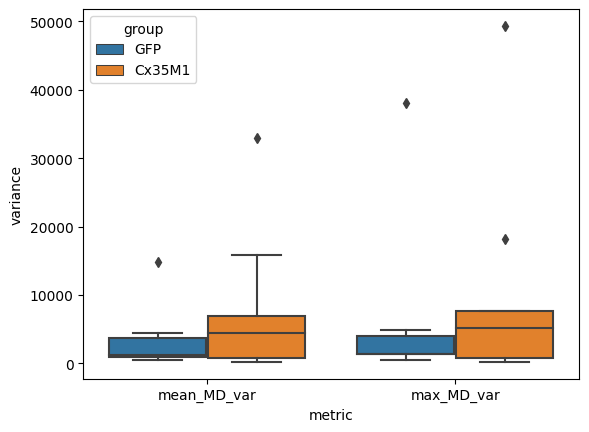

In [17]:
summary_df = masterframe_m.copy()
summary_df = summary_df.sort_values(by=['mouseid', 'group'])

#Exclude mice that have no MD response on day 2 at 3mW:
summary_df = summary_df.loc[~(summary_df['mouseid'].isin(['27324', '27353']))]
summary_df = summary_df[['mouseid', 'date', 'group', 'recording_session', 'stim_power',
      'IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min', 
      'MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 
      'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']]
summary_df['mean_IL'] = summary_df[['IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 
                            'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min']].mean(axis=1)
summary_df['mean_MD'] = summary_df[['MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 
                            'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']].mean(axis=1)
summary_df['min_IL'] = summary_df[['IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 
                           'IL5_min', 'IL6_min', 'IL7_min']].min(axis=1)
summary_df['max_MD'] = summary_df[['MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 
                                   'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']].max(axis=1)
summary_df = summary_df[['mouseid', 'date', 'group', 'recording_session', 'stim_power', 'mean_IL', 'mean_MD', 'min_IL', 'max_MD']]
summary_df['group'] = summary_df['group'].apply(lambda x: 'Cx35M1' if x == '1' else 'GFP')

# summary_df = summary_df.loc[summary_df['stim_power'].isin(['1mW'])]

d1_gfp_min_IL = list(summary_df.loc[(summary_df['group'] == 'GFP') & (summary_df['recording_session'] == 'Day 1')]['min_IL'])
d2_gfp_min_IL = list(summary_df.loc[(summary_df['group'] == 'GFP') & (summary_df['recording_session'] == 'Day 2')]['min_IL'])
d1_cx35_min_IL = list(summary_df.loc[(summary_df['group'] == 'Cx35M1') & (summary_df['recording_session'] == 'Day 1')]['min_IL'])
d2_cx35_min_IL = list(summary_df.loc[(summary_df['group'] == 'Cx35M1') & (summary_df['recording_session'] == 'Day 2')]['min_IL'])
d1_gfp_mean_IL = list(summary_df.loc[(summary_df['group'] == 'GFP') & (summary_df['recording_session'] == 'Day 1')]['mean_IL'])
d2_gfp_mean_IL = list(summary_df.loc[(summary_df['group'] == 'GFP') & (summary_df['recording_session'] == 'Day 2')]['mean_IL'])
d1_cx35_mean_IL = list(summary_df.loc[(summary_df['group'] == 'Cx35M1') & (summary_df['recording_session'] == 'Day 1')]['mean_IL'])
d2_cx35_mean_IL = list(summary_df.loc[(summary_df['group'] == 'Cx35M1') & (summary_df['recording_session'] == 'Day 2')]['mean_IL'])

d1_gfp_max_MD = list(summary_df.loc[(summary_df['group'] == 'GFP') & (summary_df['recording_session'] == 'Day 1')]['max_MD'])
d2_gfp_max_MD = list(summary_df.loc[(summary_df['group'] == 'GFP') & (summary_df['recording_session'] == 'Day 2')]['max_MD'])
d1_cx35_max_MD = list(summary_df.loc[(summary_df['group'] == 'Cx35M1') & (summary_df['recording_session'] == 'Day 1')]['max_MD'])
d2_cx35_max_MD = list(summary_df.loc[(summary_df['group'] == 'Cx35M1') & (summary_df['recording_session'] == 'Day 2')]['max_MD'])
d1_gfp_mean_MD = list(summary_df.loc[(summary_df['group'] == 'GFP') & (summary_df['recording_session'] == 'Day 1')]['mean_MD'])
d2_gfp_mean_MD = list(summary_df.loc[(summary_df['group'] == 'GFP') & (summary_df['recording_session'] == 'Day 2')]['mean_MD'])
d1_cx35_mean_MD = list(summary_df.loc[(summary_df['group'] == 'Cx35M1') & (summary_df['recording_session'] == 'Day 1')]['mean_MD'])
d2_cx35_mean_MD = list(summary_df.loc[(summary_df['group'] == 'Cx35M1') & (summary_df['recording_session'] == 'Day 2')]['mean_MD'])

mouse_day_df = summary_df.copy()
#exclude 3mW stim
mouse_day_df = mouse_day_df.loc[~mouse_day_df['stim_power'].isin(['3mW'])]
#compute per-mouse variance within day
mouse_day_df = mouse_day_df.groupby(['mouseid', 'date', 'group', 'recording_session']).agg({'mean_IL': 'var', 'mean_MD': 'var', 'min_IL': 'var', 'max_MD': 'var' }).reset_index()
mouse_day_df = mouse_day_df.rename(columns={'mean_IL': 'mean_IL_var', 'mean_MD': 'mean_MD_var', 'min_IL': 'min_IL_var', 'max_MD': 'max_MD_var'})

#melt the dataframe
mouse_day_df = pd.melt(mouse_day_df, id_vars=['mouseid', 'date', 'group', 'recording_session'], value_vars=['mean_IL_var', 'mean_MD_var', 'min_IL_var', 'max_MD_var'], var_name='metric', value_name='variance')

sns.boxplot(data=mouse_day_df.loc[(mouse_day_df['recording_session'] == 'Day 2') & (mouse_day_df['metric'].str.contains('MD'))], x='metric', y='variance', hue='group')
summary_df.head(50)

In [10]:
masterframe_m.head()

,mouseid,date,group,recording_session,IL0_min,IL1_min,IL2_min,IL3_min,IL4_min,IL5_min,...,MD7_10_to_25_max,MD0_100_to_200_max,MD1_100_to_200_max,MD2_100_to_200_max,MD3_100_to_200_max,MD4_100_to_200_max,MD5_100_to_200_max,MD6_100_to_200_max,MD7_100_to_200_max,stim_power
0,27322,092022,2,Day 1,-383.368005,-493.044323,-631.308305,-719.522490,-677.605165,-582.993813,...,70.970690,32.561626,36.542035,56.648185,72.526397,50.825113,62.405633,53.391085,70.970690,1mW
0,27322,092022,2,Day 1,-330.041148,-424.479901,-581.875175,-614.328873,-587.515329,-513.256770,...,56.471756,28.291446,28.207826,32.091622,60.359836,35.961737,47.455641,36.202959,56.471756,0.75mW
0,27322,092022,2,Day 1,-259.985922,-339.975132,-478.663434,-497.988891,-510.498133,-430.827263,...,65.139955,50.356970,50.521469,53.791043,77.653558,53.014216,75.806892,52.669508,65.139955,0.5mW
0,27322,092022,2,Day 1,-121.419280,-189.604564,-198.834743,-273.426761,-288.102881,-236.738838,...,38.740588,20.674490,11.556724,28.124675,25.192832,24.518309,39.726459,26.706788,42.049573,0.25mW
0,27322,093022,2,Day 2,-1047.870765,-1216.901047,-1028.309129,-1538.356782,-1178.812662,-1063.209012,...,292.317519,101.783876,112.214599,162.059778,187.405950,139.255157,166.359012,123.984731,292.317519,3mW


# Difference between groups on each day (individual wires)

Normality: {} NormaltestResult(statistic=9.16093978147576, pvalue=0.010250078747565852)
Normality: {} NormaltestResult(statistic=1.2962106536024445, pvalue=0.5230358205112896)
p value: {} 0.2788512114712308


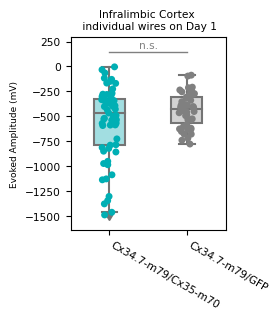

Normality: {} NormaltestResult(statistic=14.861703047139128, pvalue=0.0005926826137566727)
Normality: {} NormaltestResult(statistic=31.358378123824796, pvalue=1.5510103992595706e-07)
p value: {} 0.010348368904332241


<Figure size 640x480 with 0 Axes>

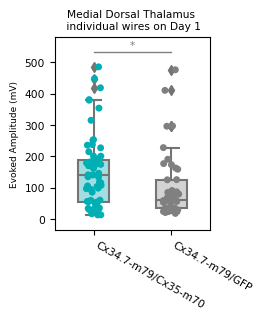

Normality: {} NormaltestResult(statistic=14.399820351477624, pvalue=0.0007466528729072965)
Normality: {} NormaltestResult(statistic=13.611999254492336, pvalue=0.0011071129175550677)
p value: {} 0.25032317674861415


<Figure size 640x480 with 0 Axes>

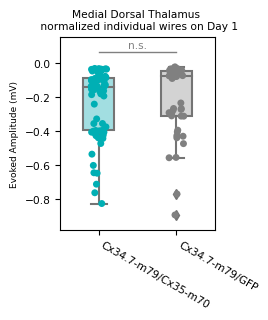

p value: {} 0.662004662004662


<Figure size 640x480 with 0 Axes>

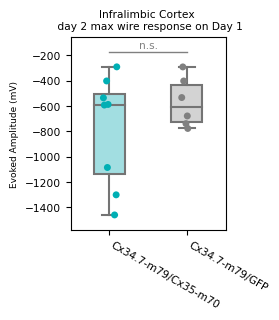

p value: {} 0.6889110889110889


<Figure size 640x480 with 0 Axes>

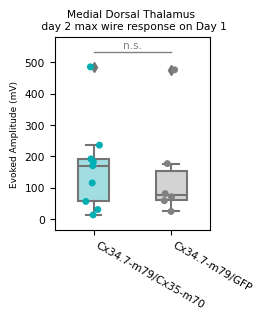

Normality: {} NormaltestResult(statistic=5.4553569056342255, pvalue=0.06537087521474395)
Normality: {} NormaltestResult(statistic=2.488990085725812, pvalue=0.2880863426634047)
p value: {} 0.07442825415949747


<Figure size 640x480 with 0 Axes>

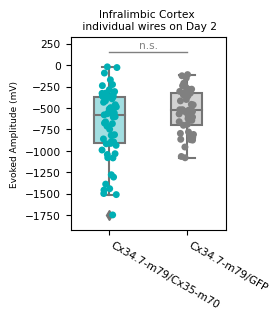

Normality: {} NormaltestResult(statistic=24.100447622202363, pvalue=5.843247650816189e-06)
Normality: {} NormaltestResult(statistic=37.35580285074946, pvalue=7.731975645982659e-09)
p value: {} 0.0004901336640981248


<Figure size 640x480 with 0 Axes>

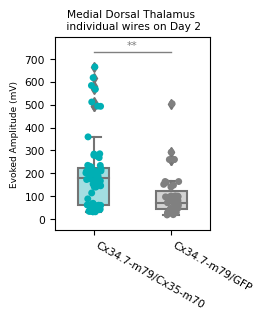

Normality: {} NormaltestResult(statistic=12.401739071812987, pvalue=0.002027666740484248)
Normality: {} NormaltestResult(statistic=11.995509344451968, pvalue=0.0024843240407632573)
p value: {} 0.05574000896990192


<Figure size 640x480 with 0 Axes>

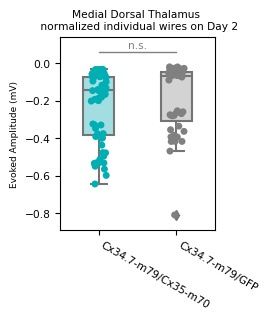

p value: {} 0.38841158841158835


<Figure size 640x480 with 0 Axes>

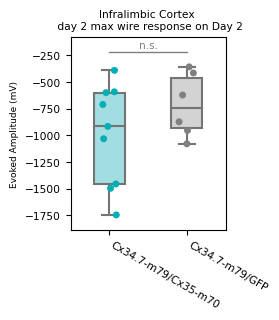

p value: {} 0.45594405594405585


<Figure size 640x480 with 0 Axes>

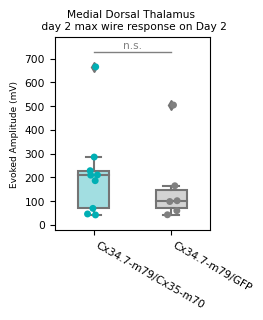

<Figure size 640x480 with 0 Axes>

In [11]:
#Copy masterframe_m
masterframe_copy = masterframe_m.copy(deep = True)

#Remove MD columns that are not 10_to_25_max
masterframe_copy = masterframe_copy.drop(columns=[col for col in masterframe_copy.columns if 'MD' in col and '10_to_25_max' not in col])

#Remove stim power that isn't 1mW
masterframe_copy = masterframe_copy.loc[masterframe_copy['stim_power'].isin(['1mW'])]

#Add a column with the smallest IL rsponse
masterframe_copy['IL_min'] = masterframe_copy[['IL{}_min'.format(i) for i in range(8)]].min(axis=1)

#For each MD column, normalize its value by the smallest IL value for that day
for i in range(8):
    masterframe_copy['MD{}_normalized'.format(i)] = masterframe_copy['MD{}_10_to_25_max'.format(i)]/masterframe_copy['IL_min']

# #Melt kaf_df such that all IL_min columns are in one column, all MD_max columns are in another column, and normalized MD values are in another column
master_il_melted = pd.melt(masterframe_copy, id_vars=['mouseid', 'date', 'group', 'recording_session', 
    'stim_power'], value_vars=['IL{}_min'.format(i)  for i in range(8)], var_name='electrode_id', value_name='IL_value')
master_il_melted['electrode_id'] = master_il_melted['electrode_id'].apply(lambda x: int(x.rsplit('_')[0].rsplit('L')[1]))

md_columns = ['MD{}_10_to_25_max'.format(i)  for i in range(8)]
md_norm_columns = ['MD{}_normalized'.format(i)  for i in range(8)]

master_md_melted = pd.melt(masterframe_copy, id_vars=['mouseid', 'date', 'group', 'recording_session', 
    'stim_power'], value_vars=md_columns, var_name='electrode_id', value_name='MD_value')
master_md_melted['electrode_id'] = master_md_melted['electrode_id'].apply(lambda x: int(x.rsplit('_')[0].rsplit('D')[1]))

master_md_norm_melted = pd.melt(masterframe_copy, id_vars=['mouseid', 'date', 'group', 'recording_session', 
    'stim_power'], value_vars=md_norm_columns, var_name='electrode_id', value_name='MD_value_norm')
master_md_norm_melted['electrode_id'] = master_md_norm_melted['electrode_id'].apply(lambda x: int(x.rsplit('_')[0].rsplit('D')[1]))

master_melt_temp = pd.merge(master_il_melted, master_md_melted, on=['mouseid', 'date', 'group', 
                                                               'recording_session', 'stim_power', 'electrode_id'])
master_melt = pd.merge(master_melt_temp, master_md_norm_melted, on=['mouseid', 'date', 'group', 
                                                               'recording_session', 'stim_power', 'electrode_id'])

#Change the group column to have the correct names
master_melt['group'] = master_melt['group'].apply(lambda x: 'Cx35M1' if x == '1' else 'GFP')

#Make a dictionary with mouseid as key and the value being the list with wire ids of the largest magnitude 
# IL and MD responses on day 2
mouse_dict = {}
for m in master_melt['mouseid'].unique():
    #Get the slice of the dataframe corresponding to this mouse on day 2
    mouseslice = master_melt.loc[(master_melt['mouseid'] == m) & (master_melt['recording_session'] == 'Day 2')]
    #Get the wire id of the IL response with the largest magnitude
    max_IL_wire = mouseslice.loc[mouseslice['IL_value'].idxmin()]['electrode_id']
    #Get the wire id of the MD response with the largest magnitude
    max_MD_wire = mouseslice.loc[mouseslice['MD_value'].idxmax()]['electrode_id']
    #Add these wire ids to the dictionary
    mouse_dict[m] = [max_IL_wire, max_MD_wire]

#Add is_max_IL column and is_max_MD column to the dataframe
master_melt['is_max_IL'] = master_melt.apply(lambda x: x['electrode_id'] == mouse_dict[x['mouseid']][0], axis=1)
master_melt['is_max_MD'] = master_melt.apply(lambda x: x['electrode_id'] == mouse_dict[x['mouseid']][1], axis=1)

comparison_variables = ['IL_value', 'MD_value', 'MD_value_norm', 'IL_value', 'MD_value']
region_naming = [['IL', 'Infralimbic Cortex \n individual wires on '], 
                 ['MD', 'Medial Dorsal Thalamus \n individual wires on '], 
                 ['MD', 'Medial Dorsal Thalamus \n normalized individual wires on '],
                 ['IL', 'Infralimbic Cortex \n day 2 max wire response on '],
                 ['MD', 'Medial Dorsal Thalamus \n day 2 max wire response on ']]
                    

for exp_day in ['Day 1', 'Day 2']:
    for j, cv in enumerate(comparison_variables):
        df_subset = master_melt.copy(deep=True)
        df_subset = master_melt.loc[master_melt['recording_session'] == exp_day]
        if 'max' in region_naming[j][1]:
            df_subset = df_subset.loc[df_subset['is_max_' + region_naming[j][0]]]
        fig = plt.figure(figsize=(2,2.5))
        plt.title(region_naming[j][1] + exp_day, fontsize=7.7, color='black')
        ax = sns.boxplot(data=df_subset, x="group", y=cv,  
                        width=0.4, palette={'Cx35M1' : '#98E8EB', 'GFP' : 'lightgray'}, order=['Cx35M1', 'GFP'])
        sns.stripplot(data=df_subset, x="group", y=cv, 
                    dodge=False, palette={'Cx35M1' : '#00afb4', 'GFP' : 'gray'}, order=['Cx35M1', 'GFP'])
        plt.ylabel('Evoked Amplitude (mV)', fontsize=6.5)
        ax.set_xticklabels(['Cx34.7-m79/Cx35-m70', 'Cx34.7-m79/GFP'], rotation=-30, ha='left')
        ax.tick_params(axis='both', labelsize=7.7)
        ax.set(xlabel=None)

        #Do group comparison and plot the p value on the plot

        #Isolate the two groups
        arr1 = np.array(df_subset.loc[df_subset['group'] == 'Cx35M1'][cv])
        arr2 = np.array(df_subset.loc[df_subset['group'] == 'GFP'][cv])

        #remove nan values from these arrays
        arr1 = arr1[~np.isnan(arr1)]
        arr2 = arr2[~np.isnan(arr2)]
        # print(len(arr1))
        # print(len(arr2))

        #print normality test for each group
        if len(arr1) > 8 and len(arr2) > 8:
            print('Normality: {}', stats.normaltest(arr1))
            print('Normality: {}', stats.normaltest(arr2))

        u_statistic, p_val = stats.mannwhitneyu(arr1, arr2, alternative='two-sided')
        # p_val = list(stats.ttest_ind(arr2, arr1))[1]
        print("p value: {}", p_val)
        if p_val < 0.001:
            p_sign = '**'
        elif p_val < 0.05:
            p_sign = '*'
        else:
            p_sign = 'n.s.'

        #Identify the highest and lowest y position of the strip plot
        max_y = df_subset[cv].max()
        min_y = df_subset[cv].min()
        p10 = 0.1*(max_y - min_y)

        #Plot a horizontal line at the top of the box plot
        plt.plot([0, 1], [max_y + p10, max_y + p10], color='gray', linewidth=1)
        plt.text(0.5, max_y + 1.25*p10, p_sign, fontsize=7.7, color='gray', ha='center')

        #set y lim to include the text
        plt.ylim([min_y - p10, max_y + p10*2])

        #save figure
        plt.savefig(join(join(base_dir, 'out'), region_naming[j][1] + exp_day + "_wire-wise.pdf"), format='pdf', bbox_inches='tight', transparent=True)
        plt.show()
        plt.cla()
        plt.clf()


# B/w days difference per-wire (aggregate)

0.3213387748173894


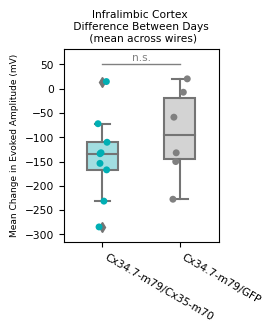

0.06633366633366634


<Figure size 640x480 with 0 Axes>

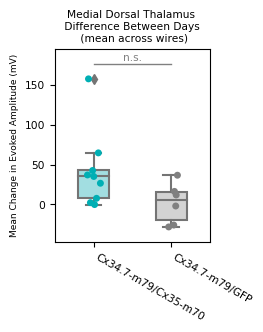

0.15997286754131834


<Figure size 640x480 with 0 Axes>

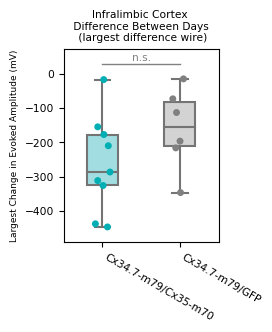

0.5286713286713286


<Figure size 640x480 with 0 Axes>

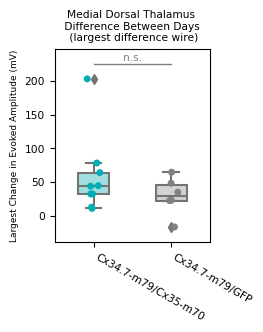

0.45594405594405585


<Figure size 640x480 with 0 Axes>

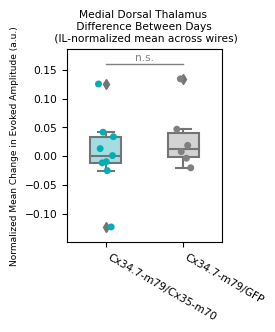

0.2721278721278721


<Figure size 640x480 with 0 Axes>

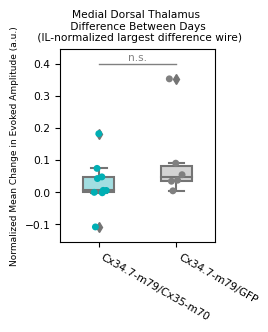

0.13818850167754604


<Figure size 640x480 with 0 Axes>

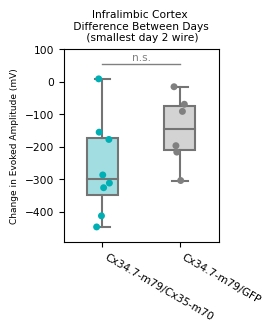

0.08791208791208792


<Figure size 640x480 with 0 Axes>

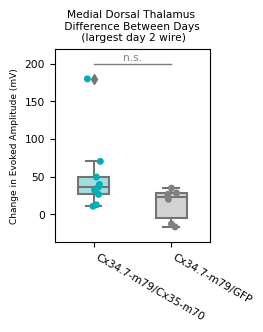

Index(['mouseid', 'group', 'IL0_min_Day 1', 'IL0_min_Day 2', 'IL1_min_Day 1',
       'IL1_min_Day 2', 'IL2_min_Day 1', 'IL2_min_Day 2', 'IL3_min_Day 1',
       'IL3_min_Day 2', 'IL4_min_Day 1', 'IL4_min_Day 2', 'IL5_min_Day 1',
       'IL5_min_Day 2', 'IL6_min_Day 1', 'IL6_min_Day 2', 'IL7_min_Day 1',
       'IL7_min_Day 2', 'MD0_10_to_25_max_Day 1', 'MD0_10_to_25_max_Day 2',
       'MD1_10_to_25_max_Day 1', 'MD1_10_to_25_max_Day 2',
       'MD2_10_to_25_max_Day 1', 'MD2_10_to_25_max_Day 2',
       'MD3_10_to_25_max_Day 1', 'MD3_10_to_25_max_Day 2',
       'MD4_10_to_25_max_Day 1', 'MD4_10_to_25_max_Day 2',
       'MD5_10_to_25_max_Day 1', 'MD5_10_to_25_max_Day 2',
       'MD6_10_to_25_max_Day 1', 'MD6_10_to_25_max_Day 2',
       'MD7_10_to_25_max_Day 1', 'MD7_10_to_25_max_Day 2', 'IL_min_Day 1',
       'IL_min_Day 2', 'MD_max_Day 2', 'IL_min_wire_Day 2',
       'MD_max_wire_Day 2', 'IL_day2_min_diff', 'MD_day2_max_diff',
       'MD0_norm_max_Day 1', 'MD0_norm_max_Day 2', 'MD1_norm_max

,mouseid,group,IL0_min_Day 1,IL0_min_Day 2,IL1_min_Day 1,IL1_min_Day 2,IL2_min_Day 1,IL2_min_Day 2,IL3_min_Day 1,IL3_min_Day 2,...,MD4_norm_diff,MD5_norm_diff,MD6_norm_diff,MD7_norm_diff,IL_mean_diff,MD_mean_diff,IL_max_diff,MD_max_diff,MD_mean_norm_diff,MD_max_norm_diff
0,27322,GFP,-383.368005,-591.802611,-493.044323,-779.275729,-631.308305,-827.440105,-719.522490,-1065.367977,...,-0.020310,-0.022185,-0.032762,0.000898,-227.608445,36.613460,-345.845487,48.196339,-0.020263,0.004417
1,27325,GFP,-272.454203,-345.530211,-253.886741,-326.286829,-290.587741,-359.350667,-87.243546,-110.075351,...,0.028663,-0.005372,0.001867,-0.002626,-58.802681,16.297387,-73.076008,22.950785,0.007899,0.037488
2,27332,Cx35M1,-1377.618429,-1441.374115,-1488.443412,-1510.460721,-857.330617,-913.242831,-1461.689332,-1747.748732,...,0.002406,0.005820,-0.002410,-0.001646,-72.208660,7.609286,-286.059400,12.652604,0.001047,0.005820
3,27335,GFP,-389.497852,-322.238049,-235.600847,-210.549711,NaN,NaN,NaN,NaN,...,0.046194,NaN,NaN,0.090435,20.082721,-2.023808,-14.964868,22.359436,0.018846,0.090435
4,27341,Cx35M1,-268.995736,-329.033233,-332.763481,-417.142526,-519.300118,-682.562077,-342.740222,-432.800955,...,0.039773,0.066801,0.026622,0.027009,-110.383007,42.557842,-176.953945,63.937268,0.041816,0.074275


<Figure size 640x480 with 0 Axes>

In [12]:
#Make a new table with masterframe_m where for each IL and MD channel there is two columns: one for day 1 and one for day 2
by_day_masterframe = masterframe_m.copy(deep=True)

#Only keep the 1mW stim power
by_day_masterframe = by_day_masterframe.loc[by_day_masterframe['stim_power'].isin(['1mW'])]

# Use pivot_table to reshape the DataFrame
og_columns = ['IL{}_min'.format(i)  for i in range(8)]
og_columns.extend(['MD{}_10_to_25_max'.format(i)  for i in range(8)])

by_day_masterframe = by_day_masterframe.pivot_table(index=['mouseid', 'group'], 
    columns='recording_session', values=og_columns, aggfunc='first')

# Flatten the multi-level column index
by_day_masterframe.columns = ['{}_{}'.format(col[0], col[1]) for col in by_day_masterframe.columns]

# Reset the index to make id a regular column
by_day_masterframe.reset_index(inplace=True)

#Add a column with the smallest IL value for each day across wires
by_day_masterframe['IL_min_Day 1'] = by_day_masterframe[['IL{}_min_Day 1'.format(i) for i in range(8)]].min(axis=1)
by_day_masterframe['IL_min_Day 2'] = by_day_masterframe[['IL{}_min_Day 2'.format(i) for i in range(8)]].min(axis=1)

#Add a column with the largest MD value for day 2 across wires
by_day_masterframe['MD_max_Day 2'] = by_day_masterframe[['MD{}_10_to_25_max_Day 2'.format(i) for i in range(8)]].max(axis=1)

#Add a column with the wire id of the smallest IL value for day 2
by_day_masterframe['IL_min_wire_Day 2'] = by_day_masterframe[['IL{}_min_Day 2'.format(i) for i in range(8)]].idxmin(axis=1).apply(lambda x: int(x.rsplit('_')[0].rsplit('L')[1]))
#Add a column with the wire id of the largest MD value for day 2
by_day_masterframe['MD_max_wire_Day 2'] = by_day_masterframe[['MD{}_10_to_25_max_Day 2'.format(i) for i in range(8)]].idxmax(axis=1).apply(lambda x: int(x.rsplit('_')[0].rsplit('D')[1]))

#Using the wire id of the smallest IL value for day 2, compute the difference between day 2 and day 1 for that wire
by_day_masterframe['IL_day2_min_diff'] = by_day_masterframe.apply(lambda x : x['IL{}_min_Day 2'.format(x['IL_min_wire_Day 2'])] - x['IL{}_min_Day 1'.format(x['IL_min_wire_Day 2'])], axis=1)
#Do the same for MD
by_day_masterframe['MD_day2_max_diff'] = by_day_masterframe.apply(lambda x : x['MD{}_10_to_25_max_Day 2'.format(x['MD_max_wire_Day 2'])] - x['MD{}_10_to_25_max_Day 1'.format(x['MD_max_wire_Day 2'])], axis=1)

#For each MD column, normalize its value by the smallest IL value for that day
for md_chan_id in range(8):
    by_day_masterframe['MD{}_norm_max_Day 1'.format(md_chan_id)] = by_day_masterframe['MD{}_10_to_25_max_Day 1'.format(md_chan_id)]/by_day_masterframe['IL_min_Day 1']
    by_day_masterframe['MD{}_norm_max_Day 2'.format(md_chan_id)] = by_day_masterframe['MD{}_10_to_25_max_Day 2'.format(md_chan_id)]/by_day_masterframe['IL_min_Day 2']

#Calculate the difference between day 2 and day 1 for each non-normalized channel
for il_chan_id in range(8):
    by_day_masterframe['IL{}_diff'.format(il_chan_id)] = by_day_masterframe['IL{}_min_Day 2'.format(il_chan_id)] - by_day_masterframe['IL{}_min_Day 1'.format(il_chan_id)]
for md_chan_id in range(8):
    by_day_masterframe['MD{}_diff'.format(md_chan_id)] = by_day_masterframe['MD{}_10_to_25_max_Day 2'.format(md_chan_id)] - by_day_masterframe['MD{}_10_to_25_max_Day 1'.format(md_chan_id)]

#Compute the difference between day 2 and day 1 for the normalized MD wires
for md_chan_id in range(8):
    by_day_masterframe['MD{}_norm_diff'.format(md_chan_id)] = by_day_masterframe['MD{}_norm_max_Day 2'.format(md_chan_id)] - by_day_masterframe['MD{}_norm_max_Day 1'.format(md_chan_id)]

#Compute the mean difference across non-normalized wires for both regions
by_day_masterframe['IL_mean_diff'] = by_day_masterframe[['IL{}_diff'.format(i) for i in range(8)]].mean(axis=1)
by_day_masterframe['MD_mean_diff'] = by_day_masterframe[['MD{}_diff'.format(i)  for i in range(8)]].mean(axis=1)

#Compute the max difference across non-normalized wires for both regions
by_day_masterframe['IL_max_diff'] = by_day_masterframe[['IL{}_diff'.format(i) for i in range(8)]].min(axis=1)
by_day_masterframe['MD_max_diff'] = by_day_masterframe[['MD{}_diff'.format(i)  for i in range(8)]].max(axis=1)

#Compute the mean difference across normalized wires for MD
by_day_masterframe['MD_mean_norm_diff'] = by_day_masterframe[['MD{}_norm_diff'.format(i)  for i in range(8)]].mean(axis=1)

#Compute the max difference across normalized wires for MD
by_day_masterframe['MD_max_norm_diff'] = by_day_masterframe[['MD{}_norm_diff'.format(i)  for i in range(8)]].max(axis=1)

#Change the group column to have the correct names
by_day_masterframe['group'] = by_day_masterframe['group'].apply(lambda x: 'Cx35M1' if x == '1' else 'GFP')

#Plot the mean difference for each region as a boxplot
comparison_variables = ['IL_mean_diff', 'MD_mean_diff', 'IL_max_diff', 'MD_max_diff', 'MD_mean_norm_diff', 
                        'MD_max_norm_diff', 'IL_day2_min_diff', 'MD_day2_max_diff']

region_naming = [['Infralimbic Cortex \n Difference Between Days \n (mean across wires)', 'Mean Change in Evoked Amplitude (mV)'], 
                 ['Medial Dorsal Thalamus \n Difference Between Days \n (mean across wires)', 'Mean Change in Evoked Amplitude (mV)'],
                 ['Infralimbic Cortex \n Difference Between Days \n (largest difference wire)', 'Largest Change in Evoked Amplitude (mV)'],
                 ['Medial Dorsal Thalamus \n Difference Between Days \n (largest difference wire)', 'Largest Change in Evoked Amplitude (mV)'],
                 ['Medial Dorsal Thalamus \n Difference Between Days \n (IL-normalized mean across wires)', 'Normalized Mean Change in Evoked Amplitude (a.u.)'],
                 ['Medial Dorsal Thalamus \n Difference Between Days \n (IL-normalized largest difference wire)', 'Normalized Mean Change in Evoked Amplitude (a.u.)'],
                 ['Infralimbic Cortex \n Difference Between Days \n (smallest day 2 wire)', 'Change in Evoked Amplitude (mV)'],
                 ['Medial Dorsal Thalamus \n Difference Between Days \n (largest day 2 wire)', 'Change in Evoked Amplitude (mV)']]

for j, cv in enumerate(comparison_variables):
    fig = plt.figure(figsize=(2,2.5))
    plt.title(region_naming[j][0], fontsize=7.7, color='black')
    ax = sns.boxplot(data=by_day_masterframe, x="group", y=cv,  
                    width=0.4, palette={'Cx35M1' : '#98E8EB', 'GFP' : 'lightgray'}, order=['Cx35M1', 'GFP'])
    sns.stripplot(data=by_day_masterframe, x="group", y=cv, 
                dodge=False, palette={'Cx35M1' : '#00afb4', 'GFP' : 'gray'}, order=['Cx35M1', 'GFP'])
    plt.ylabel(region_naming[j][1], fontsize=6.5)
    ax.set_xticklabels(['Cx34.7-m79/Cx35-m70', 'Cx34.7-m79/GFP'], rotation=-30, ha='left')
    ax.tick_params(axis='both', labelsize=7.7)
    ax.set(xlabel=None)

    #Do group comparison and plot the p value on the plot

    #Isolate the two groups
    arr1 = np.array(by_day_masterframe.loc[by_day_masterframe['group'] == 'Cx35M1'][cv])
    arr2 = np.array(by_day_masterframe.loc[by_day_masterframe['group'] == 'GFP'][cv])

    #remove nan values from these arrays
    arr1 = arr1[~np.isnan(arr1)]
    arr2 = arr2[~np.isnan(arr2)]
    if 'IL' in cv:
        # u_statistic, p_val = stats.mannwhitneyu(arr1, arr2, alternative='two-sided')
        # p_val = list(stats.ttest_ind(arr1, arr2, alternative='less'))[1]
        p_val = list(stats.ttest_ind(arr1, arr2, alternative='two-sided'))[1]
    else:
        u_statistic, p_val = stats.mannwhitneyu(arr1, arr2, alternative='two-sided')
        # p_val = list(stats.ttest_ind(arr2, arr1, alternative='less'))[1]
    print(p_val)
    if p_val < 0.001:
        p_sign = '**'
    elif p_val < 0.05:
        p_sign = '*'
    else:
        p_sign = 'n.s.'

    #Identify the highest and lowest y position of the strip plot
    max_y = by_day_masterframe[cv].max()
    min_y = by_day_masterframe[cv].min()
    p10 = 0.1*(max_y - min_y)

    #Plot a horizontal line at the top of the box plot
    plt.plot([0, 1], [max_y + p10, max_y + p10], color='gray', linewidth=1)

    p_text = p_sign
    # if cv == 'IL_max_diff':
    #     p_text = 'p = ' + str(round(p_val, 2)) 
    plt.text(0.5, max_y + 1.25*p10, p_text, fontsize=7.7, color='gray', ha='center')

    #set y lim to include the text
    plt.ylim([min_y - p10, max_y + p10*2])

    #save figure
    plt.savefig(join(join(base_dir, 'out'), cv + "_wire-wise_across_days.pdf"), format='pdf', bbox_inches='tight', transparent=True)
    plt.show()
    plt.cla()
    plt.clf()
print(by_day_masterframe.columns)
by_day_masterframe.head()

# B/w days difference per-wire (single wires)

0.12561786827825255
NormaltestResult(statistic=2.9990656753228717, pvalue=0.22323442250767656)
NormaltestResult(statistic=0.7102950912683448, pvalue=0.7010699957600266)


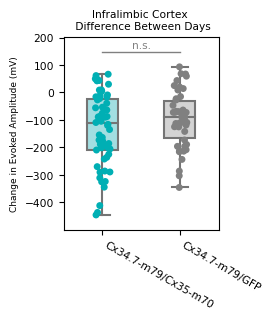

0.00011087830965168418
NormaltestResult(statistic=95.29877745007539, pvalue=2.0236407241488837e-21)
NormaltestResult(statistic=68.60457844008712, pvalue=1.266791308749087e-15)


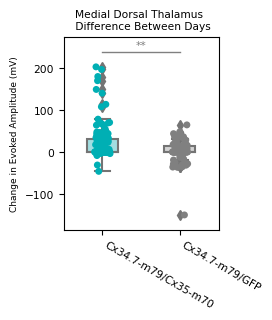

In [13]:
'''
Melt by_day_masterframe such that there are the following columns:
- mouseid
- group
- region
- wire_id
- difference
'''
by_day_masterframe_melted = pd.melt(by_day_masterframe, id_vars=['mouseid', 'group'], 
    value_vars=['IL{}_diff'.format(i) for i in range(8)] + ['MD{}_diff'.format(i) for i in range(8)] + 
    ['MD{}_norm_diff'.format(i) for i in range(8)], var_name='wire_id', value_name='difference')

by_day_masterframe_melted['region'] = by_day_masterframe_melted['wire_id'].apply(lambda x: 'IL' if 'IL' in x else 'MD')
by_day_masterframe_melted['wire_id'] = by_day_masterframe_melted['wire_id'].apply(lambda x: int(x.rsplit('_')[0][2]))

#Plot a boxplot for the two regions with group on x axis and difference on y axis
regions = ['IL', 'MD']
full_names = ['Infralimbic Cortex', 'Medial Dorsal Thalamus']

for pos, region in enumerate(regions):
    fig = plt.figure(figsize=(2,2.5))
    plt.title(full_names[pos] + ' \n Difference Between Days', fontsize=7.7, color='black')
    ax = sns.boxplot(data=by_day_masterframe_melted.loc[by_day_masterframe_melted['region'] == region], x="group", y="difference",  
                    width=0.4, palette={'Cx35M1' : '#98E8EB', 'GFP' : 'lightgray'}, order=['Cx35M1', 'GFP'])
    sns.stripplot(data=by_day_masterframe_melted.loc[by_day_masterframe_melted['region'] == region], x="group", y="difference",
                dodge=False, palette={'Cx35M1' : '#00afb4', 'GFP' : 'gray'}, order=['Cx35M1', 'GFP'])
    plt.ylabel('Change in Evoked Amplitude (mV)', fontsize=6.5)
    ax.set_xticklabels(['Cx34.7-m79/Cx35-m70', 'Cx34.7-m79/GFP'], rotation=-30, ha='left')
    ax.tick_params(axis='both', labelsize=7.7)
    ax.set(xlabel=None)

    #Do group comparison and plot the p value on the plot

    #Isolate the two groups
    arr1 = np.array(by_day_masterframe_melted.loc[(by_day_masterframe_melted['region'] == region) & (by_day_masterframe_melted['group'] == 'Cx35M1')]['difference'])
    arr2 = np.array(by_day_masterframe_melted.loc[(by_day_masterframe_melted['region'] == region) & (by_day_masterframe_melted['group'] == 'GFP')]['difference'])

    #remove nan values from these arrays    
    arr1 = arr1[~np.isnan(arr1)]
    arr2 = arr2[~np.isnan(arr2)]
    # u_statistic, p_val = stats.mannwhitneyu(arr1, arr2, alternative='two-sided')

    p_val = list(stats.ttest_ind(arr2, arr1))[1]
    print(p_val)
    if p_val < 0.001:
        p_sign = '**'
    elif p_val < 0.05:
        p_sign = '*'
    else:
        p_sign = 'n.s.'

    #Identify the highest and lowest y position of the strip plot
    max_y = by_day_masterframe_melted.loc[by_day_masterframe_melted['region'] == region]['difference'].max()
    min_y = by_day_masterframe_melted.loc[by_day_masterframe_melted['region'] == region]['difference'].min()
    p10 = 0.1*(max_y - min_y)

    #Plot a horizontal line at the top of the box plot

    plt.plot([0, 1], [max_y + p10, max_y + p10], color='gray', linewidth=1)
    plt.text(0.5, max_y + 1.25*p10, p_sign, fontsize=7.7, color='gray', ha='center')

    #Test normality of each group
    print(stats.normaltest(arr1))
    print(stats.normaltest(arr2))

    #set y lim to include the text
    plt.ylim([min_y - p10, max_y + p10*2])

    #save figure
    plt.savefig(join(join(base_dir, 'out'), region + "_wire-wise_across_days.pdf"), format='pdf', bbox_inches='tight', transparent=True)
    plt.show()



# Aggregate difference 

0.662004662004662
0.22879751090109707
0.13818850167754604
0.6889110889110889
0.45594405594405585
0.08791208791208792


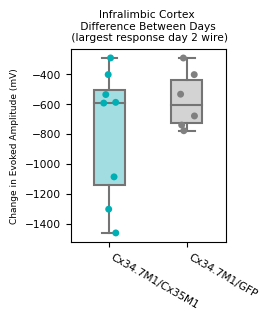

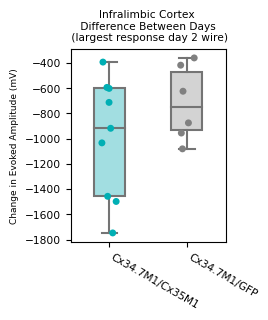

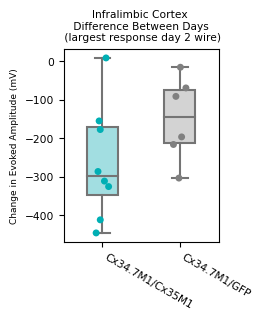

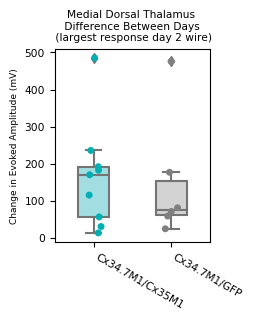

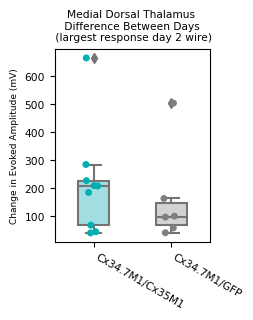

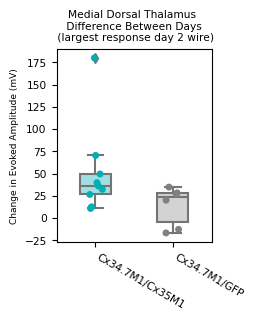

In [14]:
largest_d2_wires = masterframe_m.copy(deep=True)

#Only keep the 1mW stim power
largest_d2_wires = largest_d2_wires.loc[largest_d2_wires['stim_power'].isin(['1mW'])]

#Only keep non-MD columns and MD columns that are _10_to_25_max
largest_d2_wires = largest_d2_wires[['mouseid', 'date', 'group', 'recording_session', 'stim_power'] + 
    ['IL{}_min'.format(i) for i in range(8)] + ['MD{}_10_to_25_max'.format(i) for i in range(8)]]

#For each mouse, identify which IL and MD wire had the largest response on day 2
mouse_to_largest_MD = {mouse : list(largest_d2_wires.loc[(largest_d2_wires['recording_session']=='Day 2') & (largest_d2_wires['mouseid'] == mouse)][['MD{}_10_to_25_max'.format(i) for i in range(8)]].idxmax(axis=1))[0] for mouse in largest_d2_wires['mouseid'].unique()}
mouse_to_largest_IL = {mouse : list(largest_d2_wires.loc[(largest_d2_wires['recording_session']=='Day 2') & (largest_d2_wires['mouseid'] == mouse)][['IL{}_min'.format(i) for i in range(8)]].idxmin(axis=1))[0] for mouse in largest_d2_wires['mouseid'].unique()}
largest_d2_wires['largest_MD_wire_id'] = largest_d2_wires.apply(lambda x : mouse_to_largest_MD[x['mouseid']], axis=1)
largest_d2_wires['largest_MD_wire_val'] = largest_d2_wires.apply(lambda x: x[x['largest_MD_wire_id']], axis=1)
largest_d2_wires['largest_IL_wire_id'] = largest_d2_wires.apply(lambda x : mouse_to_largest_IL[x['mouseid']], axis=1)
largest_d2_wires['largest_IL_wire_val'] = largest_d2_wires.apply(lambda x: x[x['largest_IL_wire_id']], axis=1)

# #Add a column with the value of the largest MD wire
largest_d2_wires = largest_d2_wires[['mouseid', 'date', 'group', 'recording_session', 'largest_MD_wire_val', 'largest_IL_wire_val']]
#Reshape the dataframe such that instead of recording_session, largest_MD_wire_val, and largest_IL_wire_val there are 
# columns largest_MD_wire_val_day1, largest_MD_wire_val_day2, largest_IL_wire_val_day1, largest_IL_wire_val_day2
largest_d2_wires = largest_d2_wires.pivot_table(index=['mouseid', 'group'], columns='recording_session', values=['largest_MD_wire_val', 'largest_IL_wire_val'], aggfunc='first')
largest_d2_wires.columns = ['_'.join(col).strip() for col in largest_d2_wires.columns.values]
largest_d2_wires.reset_index(inplace=True)

#Compute the difference between day 2 and day 1 for the largest MD and IL wires
largest_d2_wires['diff_MD'] = largest_d2_wires['largest_MD_wire_val_Day 2'] - largest_d2_wires['largest_MD_wire_val_Day 1']
largest_d2_wires['diff_IL'] = largest_d2_wires['largest_IL_wire_val_Day 2'] - largest_d2_wires['largest_IL_wire_val_Day 1']

#Change the group column to have the correct names
largest_d2_wires['group'] = largest_d2_wires['group'].apply(lambda x: 'Cx35M1' if x == '1' else 'GFP')

#Plot the mean difference for each region as a boxplot
comparison_variables = ['largest_IL_wire_val_Day 1', 
                        'largest_IL_wire_val_Day 2', 'diff_IL', 
                        'largest_MD_wire_val_Day 1',
                        'largest_MD_wire_val_Day 2', 'diff_MD']
region_naming = ['Infralimbic Cortex', 'Medial Dorsal Thalamus']

for j, cv in enumerate(comparison_variables):
    fig = plt.figure(figsize=(2,2.5))
    plt.title(region_naming[j//3] + ' \n Difference Between Days \n (largest response day 2 wire)', fontsize=7.7, color='black')
    ax = sns.boxplot(data=largest_d2_wires, x="group", y=cv,  
                    width=0.4, palette={'Cx35M1' : '#98E8EB', 'GFP' : 'lightgray'}, order=['Cx35M1', 'GFP'])
    sns.stripplot(data=largest_d2_wires, x="group", y=cv, 
                dodge=False, palette={'Cx35M1' : '#00afb4', 'GFP' : 'gray'}, order=['Cx35M1', 'GFP'])
    plt.ylabel('Change in Evoked Amplitude (mV)', fontsize=6.5)
    ax.set_xticklabels(['Cx34.7M1/Cx35M1', 'Cx34.7M1/GFP'], rotation=-30, ha='left')
    ax.tick_params(axis='both', labelsize=7.7)
    ax.set(xlabel=None)

    #Do group comparison and plot the p value on the plot

    #Isolate the two groups
    arr1 = np.array(largest_d2_wires.loc[largest_d2_wires['group'] == 'Cx35M1'][cv])
    arr2 = np.array(largest_d2_wires.loc[largest_d2_wires['group'] == 'GFP'][cv])

    #remove nan values from these arrays
    arr1 = arr1[~np.isnan(arr1)]
    arr2 = arr2[~np.isnan(arr2)]
    # u_statistic, p_val = stats.mannwhitneyu(arr1, arr2, alternative='two-sided')
    if 'IL' in cv and 'Day 1' not in cv:
        p_val = list(stats.ttest_ind(arr1, arr2))[1]
    else:
        u_statistic, p_val = stats.mannwhitneyu(arr1, arr2, alternative='two-sided')
    print(p_val)
    if p_val < 0.001:
        p_sign = '**'
    elif p_val < 0.05:
        p_sign = '*'
    else:
        p_sign = 'n.s.'

    #Identify the highest and lowest y position of the strip plot
    max_y = largest_d2_wires[cv].max()
    min_y = largest_d2_wires[cv].min()


In [15]:
mouse_to_largest_MD

{'27322': 'MD7_10_to_25_max',
 '27325': 'MD7_10_to_25_max',
 '27332': 'MD7_10_to_25_max',
 '27335': 'MD4_10_to_25_max',
 '27341': 'MD4_10_to_25_max',
 '27343': 'MD2_10_to_25_max',
 '27344': 'MD3_10_to_25_max',
 '27351': 'MD6_10_to_25_max',
 '27352': 'MD3_10_to_25_max',
 '73591': 'MD0_10_to_25_max',
 '73592': 'MD0_10_to_25_max',
 '73593': 'MD7_10_to_25_max',
 '73601': 'MD2_10_to_25_max',
 '73602': 'MD6_10_to_25_max',
 '73604': 'MD4_10_to_25_max'}

# IL-MD correlations

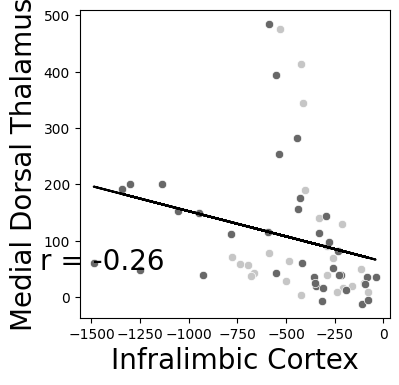

In [18]:
IL_mins = [d1_gfp_min_IL, d2_gfp_min_IL, d1_cx35_min_IL, d2_cx35_min_IL]
MD_maxs = [d1_gfp_max_MD, d2_gfp_max_MD, d1_cx35_max_MD, d2_cx35_max_MD]
all_minmax = [IL_mins, MD_maxs]

IL_means = [d1_gfp_mean_IL, d2_gfp_mean_IL, d1_cx35_mean_IL, d2_cx35_mean_IL]
MD_means = [d1_gfp_mean_MD, d2_gfp_mean_MD, d1_cx35_mean_MD, d2_cx35_mean_MD]
all_means = [IL_means, MD_means]

IL_mins_d1 = [d1_gfp_min_IL, d1_cx35_min_IL]
MD_maxs_d1 = [d1_gfp_max_MD, d1_cx35_max_MD]
d1_minmax = [IL_mins_d1, MD_maxs_d1]

IL_means_d1 = [d1_gfp_mean_IL, d1_cx35_mean_IL]
MD_means_d1 = [d1_gfp_mean_MD, d1_cx35_mean_MD]
d1_means = [IL_means_d1, MD_means_d1]

IL_mins_d2 = [d2_gfp_min_IL, d2_cx35_min_IL]
MD_maxs_d2 = [d2_gfp_max_MD, d2_cx35_max_MD]
d2_minmax = [IL_mins_d2, MD_maxs_d2]

IL_means_d2 = [d2_gfp_mean_IL, d2_cx35_mean_IL]
MD_means_d2 = [d2_gfp_mean_MD, d2_cx35_mean_MD]
d2_means = [IL_means_d2, MD_means_d2]

IL_gfp_only_mins = [d1_gfp_min_IL, d2_gfp_min_IL]
MD_gfp_only_maxs = [d1_gfp_max_MD, d2_gfp_max_MD]
gfp_minmax = [IL_gfp_only_mins, MD_gfp_only_maxs]

IL_gfp_only_means = [d1_gfp_mean_IL, d2_gfp_mean_IL]
MD_gfp_only_means = [d1_gfp_mean_MD, d2_gfp_mean_MD]
gfp_means = [IL_gfp_only_means, MD_gfp_only_means]

IL_controls_minmax = [d1_gfp_min_IL, d2_gfp_min_IL, d1_cx35_min_IL]
MD_controls_minmax = [d1_gfp_max_MD, d2_gfp_max_MD, d1_cx35_max_MD]
controls_minmax = [IL_controls_minmax, MD_controls_minmax]

IL_controls_means = [d1_gfp_mean_IL, d2_gfp_mean_IL, d1_cx35_mean_IL]
MD_controls_means = [d1_gfp_mean_MD, d2_gfp_mean_MD, d1_cx35_mean_MD]
controls_means = [IL_controls_means, MD_controls_means]

x_subset, y_subset = d1_minmax

#using day_region_split_df, plot the swarm plot of IL mean against corresponding MD mean for each mouse on day 1
fig = plt.figure(figsize=(4,4))
# plt.title('Day 1', fontsize=20, color='black')
plt.xlabel('Infralimbic Cortex', fontsize=20)
plt.ylabel('Medial Dorsal Thalamus', fontsize=20)
colors = sns.color_palette("Greys", len(x_subset))
for i in range(len(x_subset)):
      sns.scatterplot(x=x_subset[i], y=y_subset[i], color=colors[i])

#compute the correlation coefficient and plot the best fit line
x_var = [item for sublist in x_subset for item in sublist]
y_var = [item for sublist in y_subset for item in sublist]
m, b = np.polyfit(x_var, y_var, 1)
plt.plot(x_var, [m*i for i in x_var] + b, color='black')
#add correlation coefficient to the line of best fit
plt.text(0.5, 0.5, 'r = ' + str(round(np.corrcoef(x_var, y_var)[0,1], 2)), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=20)
plt.savefig(join(join(base_dir, 'out'), "allmeanIL_MD_correlation.pdf"), format='pdf', bbox_inches='tight', transparent=True)

In [ ]:
#Normalized max MD
fig = plt.figure(figsize=(2,2.5))
# plt.title('Medial Dorsal Thalamus', fontsize=7.7, color='black')
ax = sns.boxplot(data=day_region_split_df, x="group", y="norm_diff_max",  width=0.4, palette={'Cx34.7M1/Cx35M1' : '#98E8EB', 'Cx34.7M1/GFP' : 'lightgray'})
sns.stripplot(data=day_region_split_df, x="group", y="norm_diff_max", dodge=False, palette={'Cx34.7M1/Cx35M1' : '#00afb4', 'Cx34.7M1/GFP' : 'gray'})
plt.ylabel('IL-Normalized Max Change in Evoked Amplitude (mV)', fontsize=6.5)
ax.set_xticklabels(['Cx34.7M1/Cx35M1', 'Cx34.7M1/GFP'], rotation=-30, ha='left')
ax.set_ylim([-0.5,0.5])
ax.tick_params(axis='both', labelsize=7.7)
ax.set(xlabel=None)

In [17]:
kaf_df.head(60)

,mouseid,date,group,recording_session,stim_power,IL0_min,IL1_min,IL2_min,IL3_min,IL4_min,...,MD2_10_to_25_max,MD3_10_to_25_max,MD4_10_to_25_max,MD5_10_to_25_max,MD6_10_to_25_max,MD7_10_to_25_max,mean_IL,mean_MD,min_IL,max_MD
0,27322,092022,2,Day 1,1mW,-383.368005,-493.044323,-631.308305,-719.522490,-677.605165,...,35.161038,61.384036,36.087250,34.420841,25.399317,70.970690,-611.429469,37.737632,-777.438452,70.970690
0,27322,093022,2,Day 2,1mW,-591.802611,-779.275729,-827.440105,-1065.367977,-796.246272,...,71.597797,80.549151,72.108197,71.818273,70.708199,97.677472,-839.037914,74.351092,-1080.625590,97.677472
0,27325,093022,2,Day 2,1mW,-345.530211,-326.286829,-359.350667,-110.075351,-343.909234,...,100.410200,93.212006,96.831966,100.091552,95.480064,101.055615,-271.431713,97.164365,-359.350667,101.055615
0,27325,092022,2,Day 1,1mW,-272.454203,-253.886741,-290.587741,-87.243546,-279.959394,...,84.954938,78.018624,86.631929,79.377644,77.752301,80.955113,-212.629033,80.866978,-290.587741,90.894714
0,27332,093022,1,Day 2,1mW,-1441.374115,-1510.460721,-913.242831,-1747.748732,-889.989868,...,61.844580,58.075231,66.234839,59.732105,60.408355,68.767517,-1096.284031,61.795391,-1747.748732,68.767517
0,27332,092022,1,Day 1,1mW,-1377.618429,-1488.443412,-857.330617,-1461.689332,-726.213215,...,55.480082,49.410103,59.989140,59.532211,47.859048,56.114913,-1024.075371,54.186106,-1488.443412,59.989140
0,27335,100122,2,Day 2,1mW,-322.238049,-210.549711,NaN,NaN,-234.827269,...,151.588456,163.838303,164.047940,NaN,NaN,159.963985,-303.292366,154.547790,-416.797454,164.047940
0,27335,092122,2,Day 1,1mW,-389.497852,-235.600847,NaN,NaN,-254.774427,...,158.787802,162.753615,176.720349,NaN,173.069684,190.560214,-323.375087,158.928467,-401.832586,190.560214
0,27341,092322,1,Day 1,1mW,-268.995736,-332.763481,-519.300118,-342.740222,-535.131816,...,201.052694,227.078415,235.587014,237.331436,190.608290,190.464700,-390.489265,218.748456,-535.131816,253.297362
0,27341,100322,1,Day 2,1mW,-329.033233,-417.142526,-682.562077,-432.800955,-712.085761,...,230.913355,274.562235,285.167350,268.242768,234.680212,234.213815,-500.872272,261.306298,-712.085761,285.167350


# Randomly match IL and MD and plot together

<Axes: xlabel='IL_value', ylabel='MD_value'>

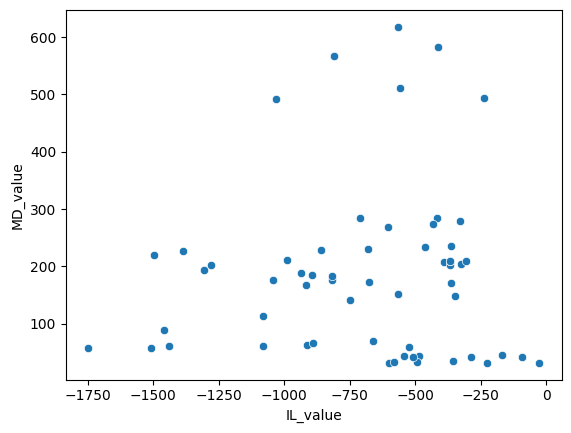

In [27]:
#Melt kaf_df such that all IL_min columns are in one column and all MD_max columns are in another column
il_melted = pd.melt(kaf_df, id_vars=['mouseid', 'date', 'group', 'recording_session', 'stim_power'], value_vars=['IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min'], var_name='electrode_id', value_name='IL_value')
il_melted['electrode_id'] = il_melted['electrode_id'].apply(lambda x: int(x.rsplit('_')[0].rsplit('L')[1]))

md_melted = pd.melt(kaf_df, id_vars=['mouseid', 'date', 'group', 'recording_session', 'stim_power'], value_vars=['MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max'], var_name='electrode_id', value_name='MD_value')
md_melted['electrode_id'] = md_melted['electrode_id'].apply(lambda x: int(x.rsplit('_')[0].rsplit('D')[1]))
melt_kaf_df = pd.merge(il_melted, md_melted, on=['mouseid', 'date', 'group', 'recording_session', 'stim_power', 'electrode_id'])

#plot the correlation between il and md value for all mice on day 2 group 1
sns.scatterplot(data=melt_kaf_df.loc[(melt_kaf_df['recording_session'] == 'Day 2') & (melt_kaf_df['group'] == '1')], x='IL_value', y='MD_value')




# Overplotted IL and MD Variability boxplot

['27322' '27325' '27335' '27343' '27344' '73604']
['27332' '27341' '27351' '27352' '73591' '73592' '73593' '73601' '73602']


/tmp/ipykernel_333687/2990583516.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day1_1mW['color'] = day1_1mW['mouseid'].apply(lambda x: gfp_m_to_c[x] if x in unique_gfp_mice else cx35_m_to_c[x])


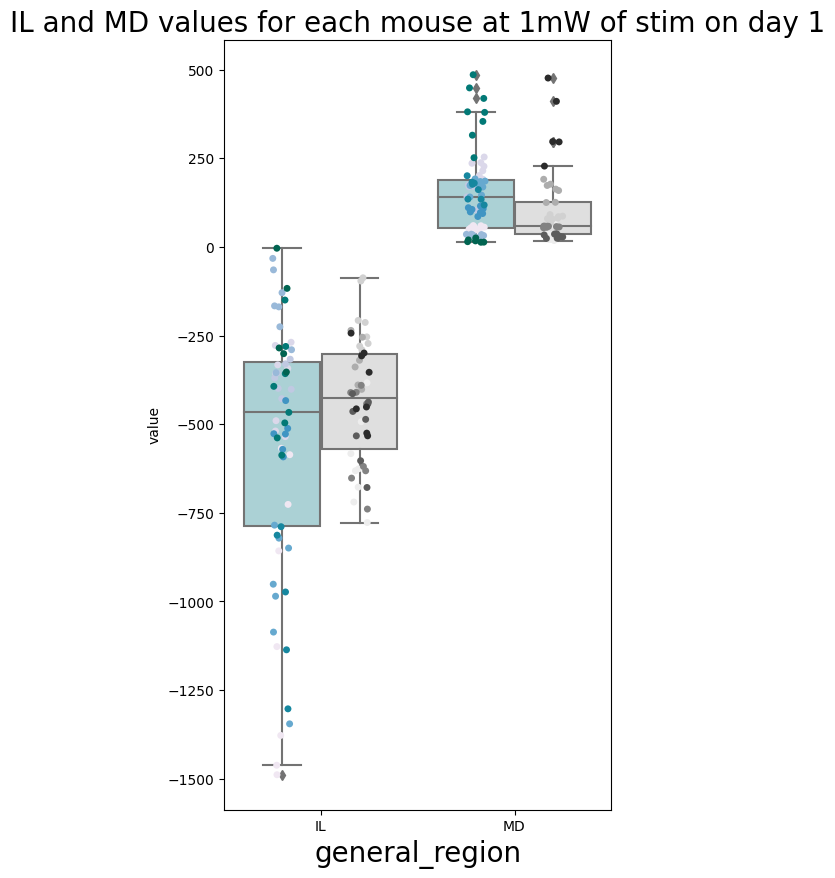

In [85]:
#Melt kaf_df that all IL_min are in one column, all MD_max are in one column, etc.
melt_1c_kaf_df = pd.melt(kaf_df, id_vars=['mouseid', 'date', 'group', 'recording_session', 'stim_power'], value_vars=['IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min', 'MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max'], var_name='region', value_name='value')
melt_1c_kaf_df['general_region'] = melt_1c_kaf_df['region'].apply(lambda x: 'IL' if 'IL' in x else 'MD')
melt_1c_kaf_df['group'] = melt_1c_kaf_df['group'].apply(lambda x: 'Cx35M1' if x == '1' else 'GFP')
#Make a box plot showing the distribution of IL and MD values for each mouse at 1mW of stim on day 1
fig = plt.figure(figsize=(5,10))
plt.title('IL and MD values for each mouse at 1mW of stim on day 1', fontsize=20, color='black')
plt.xlabel('Mouse ID', fontsize=20)
day1_1mW = melt_1c_kaf_df.loc[(melt_1c_kaf_df['recording_session'] == 'Day 1') & (melt_1c_kaf_df['stim_power'] == '1mW')]
ax = sns.boxplot(data=day1_1mW, x="general_region", y="value", hue='group', 
                 palette={'Cx35M1' : '#a4d7dc', 'GFP' : '#dfdfdf'}, hue_order=['Cx35M1', 'GFP'])

unique_gfp_mice = day1_1mW.loc[day1_1mW['group'] == 'GFP']['mouseid'].unique()
unique_cx35_mice = day1_1mW.loc[day1_1mW['group'] == 'Cx35M1']['mouseid'].unique()
print(unique_gfp_mice)
print(unique_cx35_mice)
gfp_grays = sns.color_palette("Greys", len(unique_gfp_mice))
cx35_torquise = sns.color_palette("PuBuGn", len(unique_cx35_mice))
gfp_m_to_c = {val : gfp_grays[i] for i, val in enumerate(unique_gfp_mice)}
cx35_m_to_c = {val : cx35_torquise[i] for i, val in enumerate(unique_cx35_mice)}
day1_1mW['color'] = day1_1mW['mouseid'].apply(lambda x: gfp_m_to_c[x] if x in unique_gfp_mice else cx35_m_to_c[x])
#On top of the boxplot, plot the IL and MD values for each mouse at 1mW of stim on day 1 as a striplot with dot colors signifying mouse id 

# for gfp_m in gfp_m_to_c:
#     sns.stripplot(data=day1_1mW.loc[day1_1mW['mouseid'] == gfp_m], x="general_region", 
#                   y="value", hue='group', palette={'Cx35M1' : 'white', 'GFP' : gfp_m_to_c[gfp_m]}, split=True)
for i, cx35_m in enumerate(unique_cx35_mice):
    sns.stripplot(data=day1_1mW.loc[(day1_1mW['mouseid'] == cx35_m) | (day1_1mW['mouseid'] == unique_gfp_mice[i%len(unique_gfp_mice)])], 
                  x="general_region", y="value", hue='group', dodge=True, hue_order=['Cx35M1', 'GFP'],
                  palette={'Cx35M1' : cx35_m_to_c[cx35_m], 'GFP' : gfp_m_to_c[unique_gfp_mice[i%len(unique_gfp_mice)]]})

#save plot as pdf
plt.savefig(join(join(base_dir, 'out'), "IL_MD_values_day1_1mW_before_delete.pdf"), format='pdf', bbox_inches='tight', transparent=True)
#hide legend
plt.legend().remove()

#iterate over individual stripplot points in the gfp group on the plot and identify points plotted twice
seen_before_gfp = []
points_to_delete = []
for i, point in enumerate(ax.collections):
        for j, x in enumerate(point.get_offsets()):
            point_to_group = list(day1_1mW.loc[day1_1mW['value'] == x[1]]['group'])
            is_gfp = len(point_to_group) > 0 and point_to_group[0] == 'GFP'
            if is_gfp:
                if x[1] in seen_before_gfp:
                    points_to_delete.append(point)     
                else:
                    seen_before_gfp.append(x[1])    
            
#delete points that are plotted twice
for point_d in set(points_to_delete):
    for i, point_c in enumerate(ax.collections):
        if point_c == point_d:
            ax.collections[i].remove()
            continue
plt.savefig(join(join(base_dir, 'out'), "IL_MD_values_day1_1mW_after_delete.pdf"), format='pdf', bbox_inches='tight', transparent=True)

In [14]:
kaf_df.head(60)

,mouseid,date,group,recording_session,stim_power,IL0_min,IL1_min,IL2_min,IL3_min,IL4_min,...,MD2_10_to_25_max,MD3_10_to_25_max,MD4_10_to_25_max,MD5_10_to_25_max,MD6_10_to_25_max,MD7_10_to_25_max,mean_IL,mean_MD,min_IL,max_MD
0,27322,092022,2,Day 1,1mW,-383.368005,-493.044323,-631.308305,-719.522490,-677.605165,...,35.161038,61.384036,36.087250,34.420841,25.399317,70.970690,-611.429469,37.737632,-777.438452,70.970690
0,27322,093022,2,Day 2,1mW,-591.802611,-779.275729,-827.440105,-1065.367977,-796.246272,...,71.597797,80.549151,72.108197,71.818273,70.708199,97.677472,-839.037914,74.351092,-1080.625590,97.677472
0,27325,093022,2,Day 2,1mW,-345.530211,-326.286829,-359.350667,-110.075351,-343.909234,...,100.410200,93.212006,96.831966,100.091552,95.480064,101.055615,-271.431713,97.164365,-359.350667,101.055615
0,27325,092022,2,Day 1,1mW,-272.454203,-253.886741,-290.587741,-87.243546,-279.959394,...,84.954938,78.018624,86.631929,79.377644,77.752301,80.955113,-212.629033,80.866978,-290.587741,90.894714
0,27332,093022,1,Day 2,1mW,-1441.374115,-1510.460721,-913.242831,-1747.748732,-889.989868,...,61.844580,58.075231,66.234839,59.732105,60.408355,68.767517,-1096.284031,61.795391,-1747.748732,68.767517
0,27332,092022,1,Day 1,1mW,-1377.618429,-1488.443412,-857.330617,-1461.689332,-726.213215,...,55.480082,49.410103,59.989140,59.532211,47.859048,56.114913,-1024.075371,54.186106,-1488.443412,59.989140
0,27335,100122,2,Day 2,1mW,-322.238049,-210.549711,NaN,NaN,-234.827269,...,151.588456,163.838303,164.047940,NaN,NaN,159.963985,-303.292366,154.547790,-416.797454,164.047940
0,27335,092122,2,Day 1,1mW,-389.497852,-235.600847,NaN,NaN,-254.774427,...,158.787802,162.753615,176.720349,NaN,173.069684,190.560214,-323.375087,158.928467,-401.832586,190.560214
0,27341,092322,1,Day 1,1mW,-268.995736,-332.763481,-519.300118,-342.740222,-535.131816,...,201.052694,227.078415,235.587014,237.331436,190.608290,190.464700,-390.489265,218.748456,-535.131816,253.297362
0,27341,100322,1,Day 2,1mW,-329.033233,-417.142526,-682.562077,-432.800955,-712.085761,...,230.913355,274.562235,285.167350,268.242768,234.680212,234.213815,-500.872272,261.306298,-712.085761,285.167350


# Hue by mouse variability plot

In [20]:
#Melt kaf_df that all IL_min are in one column, all MD_max are in one column, etc.
melt_1c_kaf_df = pd.melt(kaf_df.sort_values(by=['group', 'mean_IL']), id_vars=['mouseid', 'date', 'group', 'recording_session', 'stim_power'], value_vars=['IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min', 'MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max'], var_name='region', value_name='value')
melt_1c_kaf_df['general_region'] = melt_1c_kaf_df['region'].apply(lambda x: 'IL' if 'IL' in x else 'MD')
melt_1c_kaf_df['group'] = melt_1c_kaf_df['group'].apply(lambda x: 'Cx35-m70' if x == '1' else 'GFP')

for d in ['Day 1', 'Day 2']:
    #Just select the data with 1mW stim on either day
    day_1mW = melt_1c_kaf_df.loc[(melt_1c_kaf_df['recording_session'] == d) & (melt_1c_kaf_df['stim_power'] == '1mW')]

    #Split the day data into IL and MD and get corresponding IL ordering
    day_1mW_IL = day_1mW.loc[day_1mW['general_region'] == 'IL']
    day_il_mouse_ordring = list(day_1mW_IL['mouseid'].unique())
    day_1mW_MD = day_1mW.loc[day_1mW['general_region'] == 'MD']

    unique_gfp_mice = day_1mW.loc[day_1mW['group'] == 'GFP']['mouseid'].unique()
    unique_cx35_mice = day_1mW.loc[day_1mW['group'] == 'Cx35-m70']['mouseid'].unique()

    msid_to_box_col = {ms : '#a4d7dc' for ms in unique_cx35_mice}
    msid_to_box_col.update({ms : '#dfdfdf' for ms in unique_gfp_mice})

    msid_to_dot_col = {ms : '#0cadb3' for ms in unique_cx35_mice}
    msid_to_dot_col.update({ms : '#9d9d9c' for ms in unique_gfp_mice})

    region_to_df = {'IL' : day_1mW_IL, 'MD' : day_1mW_MD}
    for r in region_to_df:
        #Make a box plot showing the distribution of IL and MD values for each mouse at 1mW of stim on day 1
        fig = plt.figure(figsize=(6,10))
        plt.title(r + ' value variability across mice at 1mW of stim on ' + d)
        # print(region_to_df[r]['mouseid'].unique())
        # print(msid_to_box_col.keys())
        ax = sns.boxplot(data=region_to_df[r], x="group", y="value", hue='mouseid', palette=msid_to_box_col, hue_order=day_il_mouse_ordring)

        sns.stripplot(data=region_to_df[r], x="group", y="value", hue='mouseid', dodge=True, palette=msid_to_dot_col, hue_order=day_il_mouse_ordring)
        ax.set(xlabel=None)
        plt.ylabel('Evoked Amplitude (mV)')
        #get an array of values for the Cx35 and GFP groups
        cx35_values = list(region_to_df[r].loc[region_to_df[r]['group'] == 'Cx35-m70']['value'])
        gfp_values = list(region_to_df[r].loc[region_to_df[r]['group'] == 'GFP']['value'])

        cx35_normality = scipy.stats.normaltest(cx35_values, nan_policy='omit').pvalue
        gfp_normality = scipy.stats.normaltest(gfp_values, nan_policy='omit').pvalue

        #convert p values into exponential format
        if cx35_normality < 0.01:
            cx35_normality = '%.2E' % Decimal(cx35_normality)
        elif cx35_normality > 0.05:
            cx35_normality = 'n.s.'
        else:
            cx35_normality = str(round(cx35_normality, 2))
        
        if gfp_normality < 0.01:
            gfp_normality = '%.2E' % Decimal(gfp_normality)
        elif gfp_normality > 0.05:
            gfp_normality = 'n.s.'
        else:
            gfp_normality = str(round(gfp_normality, 2))

        #plot normality value above the corresponding group
        #identify the x position of the Cx35 tick on the plot
        max_y = region_to_df[r]["value"].max()
        min_y = region_to_df[r]["value"].min()
        p10 = 0.1*(max_y - min_y)

        #set y limit
        plt.ylim([min_y - p10, max_y + p10])
        

        plt.text(0.25, 0.95, 'p normal = ' + cx35_normality, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        plt.text(0.75, 0.95, 'p normal = ' + gfp_normality, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        #save plot as pdf
        plt.legend().remove()
        plt.savefig(join(join(base_dir, 'out'), r + "_values_" + d + "_1mW.pdf"), format='pdf', bbox_inches='tight', transparent=True)
        
        plt.cla()
        plt.clf()

dict_keys(['27332', '73593', '73591', '73592', '73601', '27341', '27351', '73602', '27352'])
dict_keys(['27332', '73593', '73591', '73592', '73601', '27341', '27351', '73602', '27352', '27322', '27343', '27344', '73604', '27335', '27325'])
dict_keys(['73593', '73591', '27332', '73592', '73601', '27341', '73602', '27351', '27352'])
dict_keys(['73593', '73591', '27332', '73592', '73601', '27341', '73602', '27351', '27352', '27322', '27343', '27344', '73604', '27335', '27325'])


<Figure size 600x1000 with 0 Axes>

<Figure size 600x1000 with 0 Axes>

<Figure size 600x1000 with 0 Axes>

<Figure size 600x1000 with 0 Axes>

In [ ]:
kaf_df_3w = masterframe_m.copy()
kaf_df_3w = kaf_df_3w.sort_values(by=['mouseid', 'group'])

kaf_df_3w = kaf_df_3w[['mouseid', 'date', 'group', 'recording_session', 'stim_power',
      'MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']]
kaf_df_3w['mean_MD'] = kaf_df_3w[['MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']].mean(axis=1)
kaf_df_3w['max_MD'] = kaf_df_3w[['MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']].max(axis=1)
kaf_df_3w = kaf_df_3w.loc[kaf_df_3w['recording_session'].isin(['Day 2'])]
kaf_df_3w = kaf_df_3w.loc[kaf_df_3w['stim_power'].isin(['3mW'])]
kaf_df_3w = kaf_df_3w[['mouseid', 'date', 'group', 'mean_MD', 'max_MD']]
kaf_df_3w = kaf_df_3w.sort_values(by=['group', 'mouseid'])
kaf_df_3w.to_csv(join(base_dir, 'out/Finaldata_3w.csv'))

In [ ]:
day_region_split_df = day_region_split_df.sort_values(by=['group', 'mouseid'])
day_region_split_df.head(60)

In [ ]:
from scipy import stats
['norm_diff_max', 'norm_diff_mean', 'diff_max', 'diff_mean']
arr1 = np.array(day_region_split_df.loc[day_region_split_df['group'] == 'Cx35M1']['diff_max'])
arr2 = np.array(day_region_split_df.loc[day_region_split_df['group'] == 'GFP']['diff_max'])
print(arr1)
stats.ttest_ind(arr1, arr2, alternative='greater')

In [ ]:
from scipy.stats import sem
sem(arr2)

In [13]:
arr1 = np.array(day_region_split_df.loc[day_region_split_df['group'] == 'Cx35M1']['IL_diff_min'])
arr2 = np.array(day_region_split_df.loc[day_region_split_df['group'] == 'GFP']['IL_diff_min'])
print(arr1)
stats.ttest_ind(arr1, arr2, alternative='less')

[-259.30532014 -176.95394477   35.74449575 -246.27469546 -153.05581393
 -325.26698009 -154.59742275 -445.83681572 -240.46389927]


Ttest_indResult(statistic=-1.0761467268903753, pvalue=0.15071411758129769)

In [ ]:
day_region_split_df.loc[day_region_split_df['group'] == 'Cx35M1'][['diff_max', 'IL_diff_min']].corr(method='pearson')
sns.scatterplot(day_region_split_df['diff_max'], day_region_split_df['IL_diff_min'])
day_region_split_df[['diff_max', 'IL_diff_min']].corr(method='pearson')

In [ ]:
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.mean(d1), np.mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

arr1 = np.array(day_region_split_df.loc[day_region_split_df['group'] == 'Cx35M1']['diff_max'])
arr2 = np.array(day_region_split_df.loc[day_region_split_df['group'] == 'GFP']['diff_max'])

k2, p = stats.normaltest(arr1)
alpha = 1e-3
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("Distribution is not normal")
else:
    print("Distribution is normal")
cohend(arr1, arr2)


In [ ]:
# from matplotlib.legend_handler import HandlerTuple

# def categorise(row):  
#     if row['stim_v'] == 3.0 and row['recording_session'] == 'Day 1':
#         return '1mW'
#     elif row['stim_v'] == 3.0 and row['recording_session'] == 'Day 2':
#         return '3mW'
#     elif row['stim_v'] == 2.758:
#         return '0.75mW'
#     elif row['stim_v'] == 2.676:
#         return '0.5mW'
#     elif row['stim_v'] == 2.622:
#         return '0.25mW'
#     elif row['stim_v'] == 2.532:
#         return '1mW'
#     elif row['stim_v'] == 2.522:
#         return '0.75mW'
#     elif row['stim_v'] == 2.513:
#         return '0.5mW'
#     else:
#         return '0.25mW'

# mf = masterframe.copy()
# mf['stim_power'] = mf.apply(lambda row: categorise(row), axis=1)
# mf = mf.sort_values(by=['stim_power'])

# for mouse in mf['mouseid'].unique():
#   for metric in ['min_0_10', 'min_10_100', 'max_10_25', 'max_50_200']:
#     plt.rcParams['figure.figsize'] = (16, 8)
#     fig, axs = plt.subplots(4, 4)
#     mouse_subframe = mf.loc[mf['mouseid'] == mouse]
#     for chanid in mouse_subframe['chanid'].unique():
#         frame = mouse_subframe.loc[mouse_subframe['chanid'] == chanid]
#         if chanid < 8:
#             sns.boxplot(data=frame, x="stim_power", y="min_0_10", hue="recording_session", hue_order=['Day 1', 'Day 2'], 
#               ax=axs[math.floor(chanid / 4), chanid % 4])
#             sns.stripplot(data=frame, x="stim_power", y="min_0_10", hue="recording_session", hue_order=['Day 1', 'Day 2'], 
#               dodge=True, ax=axs[math.floor(chanid / 4), chanid % 4], size=2)
#             axs[math.floor(chanid / 4), chanid % 4].set_title('IL' + str(chanid), fontsize=10)
#             axs[math.floor(chanid / 4), chanid % 4].set_ylabel('Peak response [mV]', fontsize=8)
#             axs[math.floor(chanid / 4), chanid % 4].set_xlabel('Stimulation Power', fontsize=8)
#         else:
#             sns.boxplot(data=frame, x="stim_power", y=metric, hue="recording_session", hue_order=['Day 1', 'Day 2'], 
#               ax=axs[math.floor(chanid / 4), chanid % 4])
#             sns.stripplot(data=frame, x="stim_power", y=metric, hue="recording_session", hue_order=['Day 1', 'Day 2'], 
#               dodge=True, ax=axs[math.floor(chanid / 4), chanid % 4], size=2)
#             axs[math.floor(chanid / 4), chanid % 4].set_title('MD' + str(chanid-8), fontsize=10)
#             axs[math.floor(chanid / 4), chanid % 4].set_ylabel('Peak response [mV]', fontsize=8)
#             axs[math.floor(chanid / 4), chanid % 4].set_xlabel('Stimulation Power', fontsize=8)
#     handles, labels = axs[math.floor(chanid / 4), chanid % 4].get_legend_handles_labels()
#     fig.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
#               labels=['Day 1', 'Day 2'],
#               loc='upper right', handlelength=4,
#               handler_map={tuple: HandlerTuple(ndivide=None)})
#     for chanid in mouse_subframe['chanid'].unique():
#       axs[math.floor(chanid / 4), chanid % 4].legend_.remove()
#     plt.tight_layout()
#     fig.subplots_adjust(top=0.9)
#     fig.suptitle('Responses in Mouse' + mouse, y=0.98)
#     plt.savefig(join(join(base_dir, 'out'), "Mouse" + str(mouse) +'Peak ' + metric + 'Response.pdf'), format='pdf', bbox_inches='tight', transparent=True)
#     plt.clf()
#     plt.cla()
    
        

In [ ]:
#Plot 16 with standard deviations:
mouseid = "27351"
date = "100322"

plt.rcParams['figure.figsize'] = (16, 8)
normalized_all_plotted = data.get_stimcalc(mouseid, date)
fig, axs = plt.subplots(4, 4)
excluded = data.bad_chan_ids(mouseid, date)
reason_bad = data.database[mouseid][date]['bad_channels_reason']

csv_path = join(Path(join(join(join(data.output_folder, '..'), 'Mouse' + mouseid), date)))
true_labels = pd.read_csv(join(csv_path, 'Mouse' + mouseid + '_' + date + '_OptoLinCx.csv'), header = None)
true_labels = list(true_labels.iloc[0])
true_voltage_inputs = true_labels[int(len(true_labels)/2) :]

possible_means = ['means_r', 'means_o', 'means_y', 'means_g']
possible_stds = ['stds_r', 'stds_o', 'stds_y', 'stds_g']
colors = ['#00afb4', 'orange', 'yellow', 'green']
if len(np.unique(true_voltage_inputs)) == 4:
  possible_voltages = [3.0, 2.758, 2.676, 2.622]
else: 
  possible_voltages = [3.0, 2.532, 2.522, 2.513, 2.504]
  possible_means.insert(0, 'means_m')
  possible_stds.insert(0, 'stds_m')
  colors.insert(0, 'maroon')
assignment = data.database[mouseid][date]['good_trials']
for chanid in range(16):
  means_dict = {i : [] for i in possible_means}
  std_dict = {i : [] for i in possible_stds}
  for j in range(normalized_all_plotted.shape[2]):
    [means_dict[possible_means[i]].append(np.mean(normalized_all_plotted[chanid, assignment[chanid][possible_voltages[i]], j])) for i in range(len(possible_means))]
    [std_dict[possible_stds[i]].append(np.std(normalized_all_plotted[chanid, assignment[chanid][possible_voltages[i]], j])) for i in range(len(possible_stds))]
    # stds.append(np.std(normalized_all_plotted[chanid, good_ones, :]))
  title = data.chanid_name[chanid] + ' response'
  # m_10_25 = {val : max(means_dict[possible_means[i]][data.pre_window + 10: data.pre_window + 25]) for i, val in enumerate(possible_voltages)}
  # mn_0_10 = {val : min(means_dict[possible_means[i]][data.pre_window: data.pre_window + 10]) for i, val in enumerate(possible_voltages)}
  for i in range(len(possible_means)):
    if possible_means[i] == 'means_r':
      # axs[math.floor(chanid / 4), chanid % 4].plot(range(-data.pre_window, data.post_window+7), means_dict[possible_means[i]], linewidth=1, color=colors[i]) 
      # axs[math.floor(chanid / 4), chanid % 4].fill_between(range(-data.pre_window, data.post_window+7), np.array(means_dict[possible_means[i]]) - np.array(std_dict[possible_stds[i]]), np.array(means_dict[possible_means[i]]) + np.array(std_dict[possible_stds[i]]), linewidth=1, color=colors[i], alpha=.1) 
      axs[math.floor(chanid / 4), chanid % 4].plot(range(-200, 100), means_dict[possible_means[i]][:300], linewidth=1, color=colors[i]) 
      axs[math.floor(chanid / 4), chanid % 4].fill_between(range(-200, 100), np.array(means_dict[possible_means[i]])[:300] - np.array(std_dict[possible_stds[i]])[:300], np.array(means_dict[possible_means[i]])[:300] + np.array(std_dict[possible_stds[i]])[:300], linewidth=1, color=colors[i], alpha=.1) 
    # if i == 0:
    #   for trl in assignment[chanid][possible_voltages[i]]:
    #     axs[math.floor(chanid / 4), chanid % 4].plot(range(-self.pre_window, self.post_window+7), normalized_all_plotted[chanid, trl, :], linewidth=1, alpha=.1, color=colors[i])
    # axs[math.floor(chanid / 4), chanid % 4].text(0.8, 0.45 - 0.08*i, 'n=' + str(len(assignment[chanid][possible_voltages[i]])), horizontalalignment='right', verticalalignment='bottom', fontsize=4, color=colors[i], transform = axs[math.floor(chanid / 4), chanid % 4].transAxes)
    # if chanid < 8:
    #   lookup_dict = mn_0_10
    # else:
    #   lookup_dict = m_10_25
    # axs[math.floor(chanid / 4), chanid % 4].axhspan(lookup_dict[possible_voltages[i]]-0.05, lookup_dict[possible_voltages[i]] + 0.05, color=colors[i])
    # axs[math.floor(chanid / 4), chanid % 4].text(0.4, 0.9 - 0.08*i, str(lookup_dict[possible_voltages[i]]), horizontalalignment='right', verticalalignment='bottom', fontsize=4, color=colors[i], transform = axs[math.floor(chanid / 4), chanid % 4].transAxes)
  # lower_std = [means[i] - stds[i] for i in range(len(means))]
  # upper_std = [means[i] + stds[i] for i in range(len(means))]
  axs[math.floor(chanid / 4), chanid % 4].set_title(title)
  
  # axs[math.floor(chanid / 4), chanid % 4].fill_between(range(-self.pre_window, self.post_window+15), lower_std, upper_std, alpha=.1, color=color)
  axs[math.floor(chanid / 4), chanid % 4].axvspan(0, 7, alpha=0.3, color='blue')
  axs[math.floor(chanid / 4), chanid % 4].axhspan(-0.1, 0.1, color='black')
  # axs[math.floor(chanid / 4), chanid % 4].set_ylabel('Normalized Potential [mV]', fontsize=20)
  # axs[math.floor(chanid / 4), chanid % 4].set_xlabel('Time [msec]', fontsize=20)
  if chanid < 8:
    axs[math.floor(chanid / 4), chanid % 4].set_ylim([-500,500])
  else:
    axs[math.floor(chanid / 4), chanid % 4].set_ylim([-500,500])
  # axs[math.floor(chanid / 4), chanid % 4].xaxis.label.set_color('white')
  # axs[math.floor(chanid / 4), chanid % 4].yaxis.label.set_color('white')
  # axs[math.floor(chanid / 4), chanid % 4].tick_params(axis='x', colors='white')
  # axs[math.floor(chanid / 4), chanid % 4].tick_params(axis='y', colors='white')
  # axs[math.floor(chanid / 4), chanid % 4].spines['left'].set_color('white')
  # axs[math.floor(chanid / 4), chanid % 4].spines['bottom'].set_color('white')
  # axs[math.floor(chanid / 4), chanid % 4].spines['right'].set_color('white')
  # axs[math.floor(chanid / 4), chanid % 4].spines['top'].set_color('white')
  # if chanid < 8:
  #   axs[math.floor(chanid / 4), chanid % 4].set_ylim([-1500, 550])
  # else:
  #   axs[math.floor(chanid / 4), chanid % 4].set_ylim([-300, 550])
  if chanid in excluded:
    axs[math.floor(chanid / 4), chanid % 4].text(0.5, 0.1, reason_bad[chanid], 
    horizontalalignment='center', 
    verticalalignment='center', fontsize=20,
    transform = axs[math.floor(chanid / 4), chanid % 4].transAxes)
    axs[math.floor(chanid / 4), chanid % 4].set_facecolor('lightsalmon')
custom_output = '/Users/kirill/Desktop/'
d = Path(join(join(custom_output, 'Mouse' + mouseid), date))
try:
  Path.mkdir(d, parents=True)
except FileExistsError:
  pass
title_main = 'All responses in Mouse' + mouseid + ' on ' + date
plt.tight_layout()
fig.subplots_adjust(top=0.8)
fig.suptitle('Responses in Mouse' + mouseid + ' on ' + date, y=0.98)
plt.savefig(join(d, title_main + ".pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.clf()
plt.cla()
plt.close('all')

In [ ]:
data.post_window

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

disambig = {'0.25mW' : 0.25, '0.5mW' : 0.5, '0.75mW' : 0.75, '1mW' : 1, '3mW' : 3}

mf = masterframe_m.copy()

# mf = mf.loc[~(mf['mouseid'].isin(['27324', '27353', '27352']))]
mf = mf[['mouseid', 'date', 'group', 'recording_session', 'stim_power',
      'IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min', 
      'MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']]
mf['mean_IL'] = mf[['IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min']].mean(axis=1)
mf['mean_MD'] = mf[['MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']].mean(axis=1)
mf['min_IL'] = mf[['IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min']].min(axis=1)
mf['max_MD'] = mf[['MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']].max(axis=1)
mf = mf[['mouseid', 'group', 'recording_session', 'stim_power', 'mean_IL', 'mean_MD', 'min_IL', 'max_MD']]
mf = mf.sort_values(by=['mouseid', 'stim_power', 'recording_session', 'group'])
mf.to_csv(join('/Users/kirill/Desktop/', 'masterframe.csv'))
# mf['split_value'] = mf['chanid'].apply(lambda x: 'IL' if x < 8 else 'MD')
# mean_vals = mf[['mouseid', 'group', 'recording_session', 'split_value', 'trial', 'min_0_10', 'min_10_100', 'max_10_25',
#        'max_50_200', 'stim_power']].groupby(['mouseid', 'split_value', 'recording_session', 'group', 'stim_power']).agg('mean').reset_index()

# sns.boxplot(data=mf.loc[(mf['stim_power'] == '1mW') & (mf['split_value'] == 'MD')], x="group", y="max_10_25", hue="recording_session", hue_order=['Day 1', 'Day 2'])
# sns.stripplot(data=mf.loc[(mf['stim_power'] == '1mW') & (mf['split_value'] == 'MD')], x="group", y="max_10_25", hue="recording_session", hue_order=['Day 1', 'Day 2'], 
#        dodge=True)
# plt.show()
fig = plt.figure(figsize=(2,4))
plt.title('IL response by stimulus power', fontsize=20, color='black')
ax = sns.boxplot(data=mf.loc[(mf['group'] == '1') & (mf['recording_session'] == 'Day 2')], x="stim_power", y="mean_IL", palette={'0.25mW' : 'green', '0.5mW' : 'yellow', 
'0.75mW' : 'orange', '1mW' : 'red', '3mW' : 'maroon'})
sns.stripplot(data=mf.loc[(mf['group'] == '1') & (mf['recording_session'] == 'Day 2')], x="stim_power", y="mean_IL", dodge=True, palette={'0.25mW' : 'green', '0.5mW' : 'yellow', 
'0.75mW' : 'orange', '1mW' : 'red', '3mW' : 'maroon'})
sns.lineplot(
    data=mf.loc[(mf['group'] == '1') & (mf['recording_session'] == 'Day 2')], x="stim_power", y="mean_IL", units="mouseid",
    color=".7", estimator=None
)
plt.ylabel('Mean peak IL [mV]', fontsize=20)
plt.xlabel('Stimulus power [mW]', fontsize=20)
ax.tick_params(axis='x', rotation=45)
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
# ax.spines['left'].set_color('white')
# ax.spines['bottom'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.spines['top'].set_color('white')
# for i, artist in enumerate(ax.artists):
#     col = artist.get_facecolor()
#     artist.set_edgecolor('gray')

#     for j in range(i*6, i*6+6):
#         line = ax.lines[j]
#         line.set_color('gray')
#         line.set_mfc('gray')
#         line.set_mec('gray')
plt.savefig(join(join(base_dir, 'out'), "IL_mean_by_power.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.clf()
plt.cla()


y_vals = np.array(mf.loc[(mf['group'] == '1') & (mf['recording_session'] == 'Day 2')]["mean_IL"]).reshape(-1, 1)
x_vals = np.array(mf.loc[(mf['group'] == '1') & (mf['recording_session'] == 'Day 2')]["stim_power"].apply(lambda x : disambig[x])).reshape(-1, 1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_vals, y_vals)

print(regr.score(x_vals, y_vals))

# Make predictions using the testing set
y_pred = regr.predict(x_vals)
fig = plt.figure(figsize=(4,4))
# Plot outputs
plt.scatter(x_vals, y_vals, color="gray")
plt.plot(x_vals, y_pred, color="purple", linewidth=3)
plt.xticks(np.arange(0, 4, 0.25))
plt.ylabel('Mean peak IL [mV]', fontsize=20)
plt.xlabel('Stimulus power [mW]', fontsize=20)
ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
# ax.spines['left'].set_color('white')
# ax.spines['bottom'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.spines['top'].set_color('white')
plt.savefig(join(join(base_dir, 'out'), "IL_mean_by_power_regr.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.clf()
plt.cla()


fig = plt.figure(figsize=(2,4))
plt.title('IL response by stimulus power', fontsize=20, color='black')
ax = sns.boxplot(data=mf.loc[(mf['group'] == '1') & (mf['recording_session'] == 'Day 2')], x="stim_power", y="min_IL", palette={'0.25mW' : 'green', '0.5mW' : 'yellow', 
'0.75mW' : 'orange', '1mW' : 'red', '3mW' : 'maroon'})
sns.stripplot(data=mf.loc[(mf['group'] == '1') & (mf['recording_session'] == 'Day 2')], x="stim_power", y="min_IL", dodge=True, palette={'0.25mW' : 'green', '0.5mW' : 'yellow', 
'0.75mW' : 'orange', '1mW' : 'red', '3mW' : 'maroon'})
plt.ylabel('Min peak IL [mV]', fontsize=20)
plt.xlabel('Stimulus power [mW]', fontsize=20)
ax.tick_params(axis='x', rotation=45)
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
# ax.spines['left'].set_color('white')
# ax.spines['bottom'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.spines['top'].set_color('white')
# for i, artist in enumerate(ax.artists):
#     col = artist.get_facecolor()
#     artist.set_edgecolor('gray')

#     for j in range(i*6, i*6+6):
#         line = ax.lines[j]
#         line.set_color('gray')
#         line.set_mfc('gray')
#         line.set_mec('gray')
plt.savefig(join(join(base_dir, 'out'), "IL_min_by_power.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.clf()
plt.cla()

y_vals = np.array(mf.loc[(mf['group'] == '1') & (mf['recording_session'] == 'Day 2')]["min_IL"]).reshape(-1, 1)
x_vals = np.array(mf.loc[(mf['group'] == '1') & (mf['recording_session'] == 'Day 2')]["stim_power"].apply(lambda x : disambig[x])).reshape(-1, 1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_vals, y_vals)

print(regr.score(x_vals, y_vals))

# Make predictions using the testing set
y_pred = regr.predict(x_vals)
fig = plt.figure(figsize=(4,4))
# Plot outputs
plt.scatter(x_vals, y_vals, color="gray")
plt.plot(x_vals, y_pred, color="purple", linewidth=3)
plt.xticks(np.arange(0, 4, 0.25))
plt.ylabel('Min peak IL [mV]', fontsize=20)
plt.xlabel('Stimulus power [mW]', fontsize=20)
ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
# ax.spines['left'].set_color('white')
# ax.spines['bottom'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.spines['top'].set_color('white')
plt.savefig(join(join(base_dir, 'out'), "IL_min_by_power_regr.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.clf()
plt.cla()






# sns.boxplot(data=mf.loc[mf['group'] == '1'], x="stim_power", y="mean_IL", hue="recording_session", hue_order=['Day 1', 'Day 2'])
# sns.stripplot(data=mf.loc[mf['group'] == '1'], x="stim_power", y="mean_IL", hue="recording_session", hue_order=['Day 1', 'Day 2'], 
#        dodge=True)
# by_group_bw_days = mean_vals.groupby(['split_value', 'recording_session', 'group', 'stim_power']).agg('mean')
# by_group_bw_days.head(50)

In [ ]:
import matplotlib

def get_x_coordinates_of_seaborn_boxplot(ax):
    display_coordinates_1 = []
    display_coordinates_2 = []
    inv = ax.transData.inverted()    
    for c in ax.get_children():
        if type(c) == matplotlib.patches.PathPatch:       
            display_coordinates_1.append([c.get_extents().x0, c.get_extents().y0]) 
            display_coordinates_2.append([c.get_extents().x1, c.get_extents().y1]) 
    return [inv.transform(tuple(display_coordinates_1)), inv.transform(tuple(display_coordinates_2))]

fig = plt.figure(figsize=(6,8))
IZ_colors = ['#FFDAC1', '#C7CEEA']
mf_d1 = mf.loc[mf['recording_session'] == 'Day 1']
ax1 = sns.boxplot(data=mf_d1, x='stim_power', y='mean_MD', hue='group',
                  order=['0.25mW', '0.5mW', '0.75mW', '1mW', '3mW'], hue_order=['1', '2'],
                  palette=IZ_colors)

outpt1, outpt2 = get_x_coordinates_of_seaborn_boxplot(ax1)
half_box = (outpt2[::2, 0][0] - outpt1[::2, 0][0])/2
d1_x = outpt1[::2, 0] + half_box
d2_x = outpt2[::2, 0] + half_box
jitter = 0.05
np.random.seed(0)
for mousid in mf_d1['mouseid'].unique():
    ms_day1 = mf_d1.loc[mf_d1['mouseid'] == mousid]
    day1_jittered = d1_x + np.random.normal(0, 0.05, size=len(outpt1[::2, 0]))
    day2_jittered = d2_x + np.random.normal(0, 0.05, size=len(outpt1[::2, 0]))
    if list(ms_day1['group'])[0] == '1':
        ax1.plot(day1_jittered, ms_day1['mean_MD'], 'o', alpha=.40, zorder=2, ms=5, mew=1, color='#B30005')
    else:
        ax1.plot(day2_jittered, ms_day1['mean_MD'], 'o', alpha=.40, zorder=2, ms=5, mew=1, color='yellowgreen')
    for i in range(len(mf_d1['stim_power'].unique()) - 1):
        if list(ms_day1['group'])[0] == '1':
            ax1.plot([day1_jittered[i], day1_jittered[i + 1]], [list(ms_day1['mean_MD'])[i], list(ms_day1['mean_MD'])[i + 1]], color = '#B30005', linewidth = 0.5, linestyle = '-', zorder=3)
        else:
           ax1.plot([day2_jittered[i], day2_jittered[i + 1]], [list(ms_day1['mean_MD'])[i], list(ms_day1['mean_MD'])[i + 1]], color = 'yellowgreen', linewidth = 0.5, linestyle = '-', zorder=3) 
ax1.tick_params(axis='x', rotation=45)
plt.ylabel('Mean peak MD [mV]', fontsize=20)
plt.xlabel('Stimulus power [mW]', fontsize=20)
ax1.set_title(' response by stimulation power and group')
plt.tight_layout()
# plt.savefig(join('/Users/kirill/Desktop/', "MD_mean_by_power_day1.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,8))
IZ_colors = ['#FFDAC1', '#C7CEEA']
mf_d1 = mf.loc[mf['recording_session'] == 'Day 1']
print(mf_d1.loc[(mf_d1['stim_power'] == '1mW') & (mf_d1['mean_MD'] > 50)].shape)
ax1 = sns.boxplot(data=mf_d1, x='stim_power', y='mean_MD',
                  order=['0.25mW', '0.5mW', '0.75mW', '1mW'],
                  palette={'0.25mW' : 'honeydew', '0.5mW' : 'lightyellow', '0.75mW' : 'navajowhite', '1mW' : 'lightcoral'})

outpt1, outpt2 = get_x_coordinates_of_seaborn_boxplot(ax1)
d1_x = outpt1[:, 0] + (outpt2[:, 0] - outpt1[:, 0])/2
# jitter = 0.05
np.random.seed(0)
for mousid in mf_d1['mouseid'].unique():
    ms_day1 = mf_d1.loc[mf_d1['mouseid'] == mousid]
    # day1_jittered = d1_x + np.random.normal(0, 0.05, size=len(outpt1[:, 0]))
    day1_jittered = d1_x
    if list(ms_day1['group'])[0] == '1':
        ax1.plot(day1_jittered, ms_day1['mean_MD'], 'o', alpha=.40, zorder=2, ms=5, mew=1, color='#B30005')
    else:
        ax1.plot(day1_jittered, ms_day1['mean_MD'], 'o', alpha=.40, zorder=2, ms=5, mew=1, color='yellowgreen')
    for i in range(len(mf_d1['stim_power'].unique()) - 1):
        ax1.plot([day1_jittered[i], day1_jittered[i + 1]], [list(ms_day1['mean_MD'])[i], list(ms_day1['mean_MD'])[i + 1]], color = 'gray', linewidth = 0.5, linestyle = '-', zorder=3)
ax1.tick_params(axis='x', rotation=45)
plt.ylabel('Mean peak MD [mV]', fontsize=20)
plt.xlabel('Stimulus power [mW]', fontsize=20)
ax1.set_title('MD response by stimulation power and group')
plt.ylim([-100, 400])
plt.tight_layout()
plt.savefig(join('/Users/kirill/Desktop/', "MD_mean_by_power_day1.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,8))
IZ_colors = ['#FFDAC1', '#C7CEEA']
mf_d1 = mf.loc[mf['recording_session'] == 'Day 1']
ax1 = sns.boxplot(data=mf_d1, x='stim_power', y='mean_IL',
                  order=['0.25mW', '0.5mW', '0.75mW', '1mW'],
                  palette={'0.25mW' : 'honeydew', '0.5mW' : 'lightyellow', '0.75mW' : 'navajowhite', '1mW' : 'lightcoral'})

outpt1, outpt2 = get_x_coordinates_of_seaborn_boxplot(ax1)
d1_x = outpt1[:, 0] + (outpt2[:, 0] - outpt1[:, 0])/2
# jitter = 0.05
np.random.seed(0)
for mousid in mf_d1['mouseid'].unique():
    ms_day1 = mf_d1.loc[mf_d1['mouseid'] == mousid]
    # day1_jittered = d1_x + np.random.normal(0, 0.05, size=len(outpt1[:, 0]))
    day1_jittered = d1_x
    if list(ms_day1['group'])[0] == '1':
        ax1.plot(day1_jittered, ms_day1['mean_IL'], 'o', alpha=.40, zorder=2, ms=5, mew=1, color='#B30005')
    else:
        ax1.plot(day1_jittered, ms_day1['mean_IL'], 'o', alpha=.40, zorder=2, ms=5, mew=1, color='yellowgreen')
    for i in range(len(mf_d1['stim_power'].unique()) - 1):
        ax1.plot([day1_jittered[i], day1_jittered[i + 1]], [list(ms_day1['mean_IL'])[i], list(ms_day1['mean_IL'])[i + 1]], color = 'gray', linewidth = 0.5, linestyle = '-', zorder=3)
ax1.tick_params(axis='x', rotation=45)
plt.ylabel('Mean peak IL [mV]', fontsize=20)
plt.xlabel('Stimulus power [mW]', fontsize=20)
ax1.set_title('IL response by stimulation power and group')
plt.tight_layout()
plt.savefig(join('/Users/kirill/Desktop/', "IL_mean_by_power_day1.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
mf.head()

In [ ]:
mf_d1 = mf_d1[['mouseid', 'group', 'stim_power', 'mean_IL', 'mean_MD', 'min_IL', 'max_MD']]
mf_d1_wide = pd.pivot(mf_d1, index=['mouseid', 'group'], columns = 'stim_power', values=['mean_IL', 'mean_MD', 'min_IL', 'max_MD'])
mf_d1_wide = mf_d1_wide.sort_values(by=['mouseid'])
mf_d1_wide.to_csv(join('/Users/kirill/Desktop/', 'day1_wide_table.csv'))

In [ ]:
import random


fig = plt.figure(figsize=(6,8))
IZ_colors = ['#FFDAC1', '#C7CEEA']

ax1 = sns.boxplot(data=mf, x='stim_power', y='mean_IL', hue='recording_session',
                  order=['0.25mW', '0.5mW', '0.75mW', '1mW', '3mW'], hue_order=['Day 1', 'Day 2'],
                  palette=IZ_colors)

outpt1, outpt2 = get_x_coordinates_of_seaborn_boxplot(ax1)
half_box = (outpt2[::2, 0][0] - outpt1[::2, 0][0])/2
d1_x = outpt1[::2, 0] + half_box
d2_x = outpt2[::2, 0] + half_box
d2_x[len(d2_x)-1] = outpt2[::2, 0][len(d2_x)-1] - half_box
jitter = 0.05
np.random.seed(0)
for mousid in mf['mouseid'].unique():
    ms_day1 = mf.loc[(mf['recording_session'] == 'Day 1') & (mf['mouseid'] == mousid)]
    ms_day2 = mf.loc[(mf['recording_session'] == 'Day 2') & (mf['mouseid'] == mousid)]
    day1_jittered = d1_x[:4] + np.random.normal(0, 0.05, size=len(outpt1[::2, 0][:4]))
    day2_jittered = d2_x + np.random.normal(0, 0.05, size=len(outpt2[::2, 0]))
    if list(ms_day1['group'])[0] == '1':
        ax1.plot(day1_jittered, ms_day1['mean_IL'], 'o', alpha=.40, zorder=2, ms=5, mew=1, color='#B30005')
        ax1.plot(day2_jittered, ms_day2['mean_IL'], 'o', alpha=.40, zorder=2, ms=5, mew=1, color='#B30005')
    else:
        ax1.plot(day1_jittered, ms_day1['mean_IL'], 'o', alpha=.40, zorder=2, ms=5, mew=1, color='yellowgreen')
        ax1.plot(day2_jittered, ms_day2['mean_IL'], 'o', alpha=.40, zorder=2, ms=5, mew=1, color='yellowgreen')
    for i in range(len(mf['stim_power'].unique())):
        if i < 4:
            ax1.plot([day1_jittered[i], day2_jittered[i]], [list(ms_day1['mean_IL'])[i], list(ms_day2['mean_IL'])[i]], color = 'grey', linewidth = 0.5, linestyle = '-', zorder=3)
ax1.tick_params(axis='x', rotation=45)
plt.ylabel('Mean peak IL [mV]', fontsize=20)
plt.xlabel('Stimulus power [mW]', fontsize=20)
ax1.set_title('IL response by stimulation power, group, and day')
plt.tight_layout()
plt.savefig(join('/Users/kirill/Desktop/', "IL_mean_by_power_and_day.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
import random
import matplotlib

def get_x_coordinates_of_seaborn_boxplot(ax):
    display_coordinates_1 = []
    display_coordinates_2 = []
    inv = ax.transData.inverted()    
    for c in ax.get_children():
        if type(c) == matplotlib.spines.Spine:     
            display_coordinates_1.append([c.get_extents().x0, c.get_extents().y0]) 
            display_coordinates_2.append([c.get_extents().x1, c.get_extents().y1]) 
    return [inv.transform(tuple(display_coordinates_1)), inv.transform(tuple(display_coordinates_2))]

sns.set(style="white", color_codes=True)
fig, ax1 = plt.subplots(figsize=(2,4))
IZ_colors = ['#FFDAC1', '#C7CEEA']

mf_1mw = mf.loc[mf['stim_power'] == '1mW']
d_size = 0.4
sns.pointplot(x="group", y="mean_IL", hue='recording_session', data=mf_1mw, dodge=d_size, join=False, ax=ax1, split = True, errorbar="sd", capsize=.2, order=['1', '2'], hue_order=['Day 1', 'Day 2'], palette={'Day 1' : 'lightgray', 'Day 2' : 'gray'})

outpt1, outpt2 = get_x_coordinates_of_seaborn_boxplot(ax1)
print(outpt1[::2, 0])
# print(np.array(outpt2[::2, 0]))
g1_x = np.array(outpt1[::2, 0][0] - d_size/2, outpt1[::2, 0][0] + d_size/2)
g2_x = np.array(outpt2[::2, 0][1] - d_size/2, outpt2[::2, 0][1] + d_size/2)
g1_d1_x = outpt1[::2, 0][0] + d_size/2
g1_d2_x = outpt1[::2, 0][0] + d_size *2
g2_d1_x = outpt1[::2, 0][1] - d_size/2
g2_d2_x = outpt1[::2, 0][1] + d_size/2

np.random.seed(0)
jitter = 0.05
for mousid in mf_1mw['mouseid'].unique():
    ms_d1 = mf_1mw.loc[(mf_1mw['recording_session'] == 'Day 1') & (mf_1mw['mouseid'] == mousid)]
    ms_d2 = mf_1mw.loc[(mf_1mw['recording_session'] == 'Day 2') & (mf_1mw['mouseid'] == mousid)]
    g1_d1_jittered = g1_d1_x + np.random.normal(0, 0.05, size=1)
    g1_d2_jittered = g1_d2_x + np.random.normal(0, 0.05, size=1)
    g2_d1_jittered = g2_d1_x + np.random.normal(0, 0.05, size=1)
    g2_d2_jittered = g2_d2_x + np.random.normal(0, 0.05, size=1)
    if list(ms_d1['group'])[0] == '1':
        ax1.plot(g1_d1_jittered[0], ms_d1['mean_IL'], 'o', zorder=2, ms=2, mew=1, color='maroon')
        ax1.plot(g1_d2_jittered[0], ms_d2['mean_IL'], 'o', zorder=2, ms=2, mew=1, color='maroon')
        ax1.plot([g1_d1_jittered[i], g1_d2_jittered[i]], [list(ms_d1['mean_IL'])[i], list(ms_d2['mean_IL'])[i]], color = 'grey', linewidth = 0.5, linestyle = '-', zorder=3)
    else:
        ax1.plot(g2_d1_jittered[0], ms_d1['mean_IL'], 'o', zorder=2, ms=2, mew=1, color='yellowgreen')
        ax1.plot(g2_d2_jittered[0], ms_d2['mean_IL'], 'o', zorder=2, ms=2, mew=1, color='yellowgreen')
        ax1.plot([g2_d1_jittered[i], g2_d2_jittered[i]], [list(ms_d1['mean_IL'])[i], list(ms_d2['mean_IL'])[i]], color = 'grey', linewidth = 0.5, linestyle = '-', zorder=3)
    
plt.ylabel('Mean peak IL [mV]', fontsize=20)
plt.xlabel('Experimental groups across days', fontsize=20)
ax1.set_title('IL response by group and day')
ax1.legend(bbox_to_anchor=(1.7, 1), loc='upper right')
plt.tight_layout()
plt.savefig(join('/Users/kirill/Desktop/', "IL_mean_by_group_and_day.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
import random
import matplotlib

def get_x_coordinates_of_seaborn_boxplot(ax):
    display_coordinates_1 = []
    display_coordinates_2 = []
    inv = ax.transData.inverted()    
    for c in ax.get_children():
        if type(c) == matplotlib.spines.Spine:     
            display_coordinates_1.append([c.get_extents().x0, c.get_extents().y0]) 
            display_coordinates_2.append([c.get_extents().x1, c.get_extents().y1]) 
    return [inv.transform(tuple(display_coordinates_1)), inv.transform(tuple(display_coordinates_2))]

sns.set(style="white", color_codes=True)
fig, ax1 = plt.subplots(figsize=(1,4))
IZ_colors = ['#FFDAC1', '#C7CEEA']

mf_1mw = mf.loc[mf['stim_power'] == '1mW']
d_size = 0.4
sns.pointplot(x="group", y="mean_MD", hue='recording_session', data=mf_1mw, dodge=d_size, join=False, ax=ax1, split = True, errorbar="sd", capsize=.2, order=['1', '2'], hue_order=['Day 1', 'Day 2'])

outpt1, outpt2 = get_x_coordinates_of_seaborn_boxplot(ax1)
# print(np.array(outpt2[::2, 0]))
g1_x = np.array(outpt1[::2, 0][0] - d_size/2, outpt1[::2, 0][0] + d_size/2)
g2_x = np.array(outpt2[::2, 0][1] - d_size/2, outpt2[::2, 0][1] + d_size/2)
g1_d1_x = outpt1[::2, 0][0] + d_size/2
g1_d2_x = outpt1[::2, 0][0] + d_size *2
g2_d1_x = outpt1[::2, 0][1] - d_size/2
g2_d2_x = outpt1[::2, 0][1] + d_size/2

np.random.seed(0)
jitter = 0.05
for mousid in mf_1mw['mouseid'].unique():
    ms_d1 = mf_1mw.loc[(mf_1mw['recording_session'] == 'Day 1') & (mf_1mw['mouseid'] == mousid)]
    ms_d2 = mf_1mw.loc[(mf_1mw['recording_session'] == 'Day 2') & (mf_1mw['mouseid'] == mousid)]
    g1_d1_jittered = g1_d1_x + np.random.normal(0, 0.05, size=1)
    g1_d2_jittered = g1_d2_x + np.random.normal(0, 0.05, size=1)
    g2_d1_jittered = g2_d1_x + np.random.normal(0, 0.05, size=1)
    g2_d2_jittered = g2_d2_x + np.random.normal(0, 0.05, size=1)
    if list(ms_d1['group'])[0] == '1':
        ax1.plot(g1_d1_jittered[0], ms_d1['mean_MD'], 'o', zorder=2, ms=5, mew=1, color='maroon')
        ax1.plot(g1_d2_jittered[0], ms_d2['mean_MD'], 'o', zorder=2, ms=5, mew=1, color='maroon')
        ax1.plot([g1_d1_jittered[i], g1_d2_jittered[i]], [list(ms_d1['mean_MD'])[i], list(ms_d2['mean_MD'])[i]], color = 'grey', linewidth = 0.5, linestyle = '-', zorder=3)
    else:
        ax1.plot(g2_d1_jittered[0], ms_d1['mean_MD'], 'o', zorder=2, ms=5, mew=1, color='yellowgreen')
        ax1.plot(g2_d2_jittered[0], ms_d2['mean_MD'], 'o', zorder=2, ms=5, mew=1, color='yellowgreen')
        ax1.plot([g2_d1_jittered[i], g2_d2_jittered[i]], [list(ms_d1['mean_MD'])[i], list(ms_d2['mean_MD'])[i]], color = 'grey', linewidth = 0.5, linestyle = '-', zorder=3)
    
plt.ylabel('Mean peak MD [mV]', fontsize=20)
plt.xlabel('Experimental groups across days', fontsize=20)
ax1.set_title('MD response by group, and day')
ax1.legend(bbox_to_anchor=(2.5, 0.7), loc='upper right')
plt.tight_layout()
plt.savefig(join('/Users/kirill/Desktop/', "MD_mean_by_group_and_day.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,8))
IZ_colors = ['#FFDAC1', '#C7CEEA']

ax1 = sns.boxplot(data=mf, x='stim_power', y='mean_MD', hue='recording_session',
                  order=['0.25mW', '0.5mW', '0.75mW', '1mW', '3mW'], hue_order=['Day 1', 'Day 2'],
                  palette=IZ_colors)

outpt1, outpt2 = get_x_coordinates_of_seaborn_boxplot(ax1)
half_box = (outpt2[::2, 0][0] - outpt1[::2, 0][0])/2
d1_x = outpt1[::2, 0] + half_box
d2_x = outpt2[::2, 0] + half_box
d2_x[len(d2_x)-1] = outpt2[::2, 0][len(d2_x)-1] - half_box
jitter = 0.05
np.random.seed(0)
for mousid in mf['mouseid'].unique():
    ms_day1 = mf.loc[(mf['recording_session'] == 'Day 1') & (mf['mouseid'] == mousid)]
    ms_day2 = mf.loc[(mf['recording_session'] == 'Day 2') & (mf['mouseid'] == mousid)]
    day1_jittered = d1_x[:4] + np.random.normal(0, 0.05, size=len(outpt1[::2, 0][:4]))
    day2_jittered = d2_x + np.random.normal(0, 0.05, size=len(outpt2[::2, 0]))
    if list(ms_day1['group'])[0] == '1':
        ax1.plot(day1_jittered, ms_day1['mean_MD'], 'o', alpha=.40, zorder=2, ms=5, mew=1, color='#B30005')
        ax1.plot(day2_jittered, ms_day2['mean_MD'], 'o', alpha=.40, zorder=2, ms=5, mew=1, color='#B30005')
    else:
        ax1.plot(day1_jittered, ms_day1['mean_MD'], 'o', alpha=.40, zorder=2, ms=5, mew=1, color='yellowgreen')
        ax1.plot(day2_jittered, ms_day2['mean_MD'], 'o', alpha=.40, zorder=2, ms=5, mew=1, color='yellowgreen')
    for i in range(len(mf['stim_power'].unique())):
        if i < 4:
            ax1.plot([day1_jittered[i], day2_jittered[i]], [list(ms_day1['mean_MD'])[i], list(ms_day2['mean_MD'])[i]], color = 'grey', linewidth = 0.5, linestyle = '-', zorder=3)
ax1.tick_params(axis='x', rotation=45)
plt.ylabel('Mean peak MD [mV]', fontsize=20)
plt.xlabel('Stimulus power [mW]', fontsize=20)
ax1.set_title(' response by stimulation power, group, and day')
plt.tight_layout()
plt.savefig(join('/Users/kirill/Desktop/', "MD_mean_by_power_and_day.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
# ['norm_diff_max', 'norm_diff_mean', 'diff_max', 'diff_mean']
day_region_split_df['IL_mean_min_diff'] = day_region_split_df['IL_mean_min_0_10_d2'] - day_region_split_df['IL_mean_min_0_10_d1']
day_region_split_df['IL_min_min_diff'] = day_region_split_df['IL_min_min_0_10_d2'] - day_region_split_df['IL_min_min_0_10_d1']
arr1 = np.array(day_region_split_df.loc[day_region_split_df['group'] == 'Cx35M1']['IL_mean_min_0_10_d2'])
arr2 = np.array(day_region_split_df.loc[day_region_split_df['group'] == 'GFP']['IL_mean_min_0_10_d2'])
stats.ttest_ind(arr1, arr2)

# arr1 = np.array(day_region_split_df.loc[day_region_split_df['group'] == 'Cx35M1']['IL_min_min_0_10_d1'])
# arr2 = np.array(day_region_split_df.loc[day_region_split_df['group'] == 'Cx35M1']['IL_min_min_0_10_d2'])
# print(arr1)
# print(arr2)
# stats.ttest_rel(arr1, arr2)

In [ ]:
fig = plt.figure(figsize=(2,4))
plt.title('MD response by stimulus power', fontsize=20, color='white')
ax = sns.boxplot(data=mf.loc[(mf['group'] == '2') & (mf['recording_session'] == 'Day 2')], x="stim_power", y="mean_MD", palette={'0.25mW' : 'green', '0.5mW' : 'yellow', 
'0.75mW' : 'orange', '1mW' : 'red', '3mW' : 'maroon'})
sns.stripplot(data=mf.loc[(mf['group'] == '2') & (mf['recording_session'] == 'Day 2')], x="stim_power", y="mean_MD", dodge=True, palette={'0.25mW' : 'green', '0.5mW' : 'yellow', '0.75mW' : 'orange', '1mW' : 'red', '3mW' : 'maroon'})
plt.ylabel('Mean peak MD [mV]', fontsize=20)
plt.xlabel('Stimulus power [mW]', fontsize=20)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['top'].set_color('white')
for i, artist in enumerate(ax.artists):
    col = artist.get_facecolor()
    artist.set_edgecolor('gray')

    for j in range(i*6, i*6+6):
        line = ax.lines[j]
        line.set_color('gray')
        line.set_mfc('gray')
        line.set_mec('gray')
plt.savefig(join(join(base_dir, 'out'), "MD_mean_by_power.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.clf()
plt.cla()


y_vals = np.array(mf.loc[(mf['group'] == '2') & (mf['recording_session'] == 'Day 2')]["mean_MD"]).reshape(-1, 1)
x_vals = np.array(mf.loc[(mf['group'] == '2') & (mf['recording_session'] == 'Day 2')]["stim_power"].apply(lambda x : disambig[x])).reshape(-1, 1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_vals, y_vals)

print(regr.score(x_vals, y_vals))

# Make predictions using the testing set
y_pred = regr.predict(x_vals)
fig = plt.figure(figsize=(4,4))
# Plot outputs
plt.scatter(x_vals, y_vals, color="gray")
plt.plot(x_vals, y_pred, color="purple", linewidth=3)
plt.xticks(np.arange(0, 4, 0.25))
plt.ylabel('Mean peak MD [mV]', fontsize=20)
plt.xlabel('Stimulus power [mW]', fontsize=20)
ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['top'].set_color('white')
plt.savefig(join(join(base_dir, 'out'), "MD_mean_by_power_regr.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.clf()
plt.cla()


fig = plt.figure(figsize=(2,4))
plt.title('MD response by stimulus power', fontsize=20, color='white')
ax = sns.boxplot(data=mf.loc[(mf['group'] == '2') & (mf['recording_session'] == 'Day 2')], x="stim_power", y="max_MD", palette={'0.25mW' : 'green', '0.5mW' : 'yellow', 
'0.75mW' : 'orange', '1mW' : 'red', '3mW' : 'maroon'})
sns.stripplot(data=mf.loc[(mf['group'] == '2') & (mf['recording_session'] == 'Day 2')], x="stim_power", y="max_MD", dodge=True, palette={'0.25mW' : 'green', '0.5mW' : 'yellow', '0.75mW' : 'orange', '1mW' : 'red', '3mW' : 'maroon'})
plt.ylabel('Max peak MD [mV]', fontsize=20)
plt.xlabel('Stimulus power [mW]', fontsize=20)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['top'].set_color('white')
for i, artist in enumerate(ax.artists):
    col = artist.get_facecolor()
    artist.set_edgecolor('gray')

    for j in range(i*6, i*6+6):
        line = ax.lines[j]
        line.set_color('gray')
        line.set_mfc('gray')
        line.set_mec('gray')
plt.savefig(join(join(base_dir, 'out'), "MD_max_by_power.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.clf()
plt.cla()

y_vals = np.array(mf.loc[(mf['group'] == '2') & (mf['recording_session'] == 'Day 2')]["max_MD"]).reshape(-1, 1)
x_vals = np.array(mf.loc[(mf['group'] == '2') & (mf['recording_session'] == 'Day 2')]["stim_power"].apply(lambda x : disambig[x])).reshape(-1, 1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_vals, y_vals)

print(regr.score(x_vals, y_vals))

# Make predictions using the testing set
y_pred = regr.predict(x_vals)
fig = plt.figure(figsize=(4,4))
# Plot outputs
plt.scatter(x_vals, y_vals, color="gray")
plt.plot(x_vals, y_pred, color="purple", linewidth=3)
plt.xticks(np.arange(0, 4, 0.25))
plt.ylabel('Max peak MD [mV]', fontsize=20)
plt.xlabel('Stimulus power [mW]', fontsize=20)
ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['top'].set_color('white')
plt.savefig(join(join(base_dir, 'out'), "MD_max_by_power_regr.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.clf()
plt.cla()

In [ ]:
mf['mean_MD_div_mean_IL'] = mf['mean_MD']/mf['mean_IL']
mf['max_MD_div_min_IL'] = mf['max_MD']/mf['min_IL']

fig = plt.figure(figsize=(2,4))
plt.title('MD/IL by stimulus power', fontsize=20, color='white')
ax = sns.boxplot(data=mf.loc[(mf['group'] == '2') & (mf['recording_session'] == 'Day 2')], x="stim_power", y="mean_MD_div_mean_IL", palette={'0.25mW' : 'green', '0.5mW' : 'yellow', 
'0.75mW' : 'orange', '1mW' : 'red', '3mW' : 'maroon'})
sns.stripplot(data=mf.loc[(mf['group'] == '2') & (mf['recording_session'] == 'Day 2')], x="stim_power", y="mean_MD_div_mean_IL", dodge=True, palette={'0.25mW' : 'green', '0.5mW' : 'yellow', '0.75mW' : 'orange', '1mW' : 'red', '3mW' : 'maroon'})
plt.ylabel('(Mean peak MD)/(Mean peak IL) [a.u.]', fontsize=20)
plt.xlabel('Stimulus power [mW]', fontsize=20)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['top'].set_color('white')
for i, artist in enumerate(ax.artists):
    col = artist.get_facecolor()
    artist.set_edgecolor('gray')

    for j in range(i*6, i*6+6):
        line = ax.lines[j]
        line.set_color('gray')
        line.set_mfc('gray')
        line.set_mec('gray')
plt.savefig(join(join(base_dir, 'out'), "MD_div_IL_mean_by_power.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.clf()
plt.cla()


y_vals = np.array(mf.loc[(mf['group'] == '2') & (mf['recording_session'] == 'Day 2')]["mean_MD_div_mean_IL"]).reshape(-1, 1)
x_vals = np.array(mf.loc[(mf['group'] == '2') & (mf['recording_session'] == 'Day 2')]["stim_power"].apply(lambda x : disambig[x])).reshape(-1, 1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_vals, y_vals)

print(regr.score(x_vals, y_vals))

# Make predictions using the testing set
y_pred = regr.predict(x_vals)
fig = plt.figure(figsize=(4,4))
# Plot outputs
plt.scatter(x_vals, y_vals, color="gray")
plt.plot(x_vals, y_pred, color="purple", linewidth=3)
plt.xticks(np.arange(0, 4, 0.25))
plt.ylabel('(Mean peak MD)/(Mean peak IL) [a.u.]', fontsize=20)
plt.xlabel('Stimulus power [mW]', fontsize=20)
ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['top'].set_color('white')
plt.savefig(join(join(base_dir, 'out'), "MD_div_IL_mean_by_power_regr.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.clf()
plt.cla()


fig = plt.figure(figsize=(2,4))
plt.title('MD response by stimulus power', fontsize=20, color='white')
ax = sns.boxplot(data=mf.loc[(mf['group'] == '2') & (mf['recording_session'] == 'Day 2')], x="stim_power", y="max_MD_div_min_IL", palette={'0.25mW' : 'green', '0.5mW' : 'yellow', 
'0.75mW' : 'orange', '1mW' : 'red', '3mW' : 'maroon'})
sns.stripplot(data=mf.loc[(mf['group'] == '2') & (mf['recording_session'] == 'Day 2')], x="stim_power", y="max_MD_div_min_IL", dodge=True, palette={'0.25mW' : 'green', '0.5mW' : 'yellow', '0.75mW' : 'orange', '1mW' : 'red', '3mW' : 'maroon'})
plt.ylabel('(Max peak MD)/(Min peak IL) [a.u.]', fontsize=20)
plt.xlabel('Stimulus power [mW]', fontsize=20)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['top'].set_color('white')
for i, artist in enumerate(ax.artists):
    col = artist.get_facecolor()
    artist.set_edgecolor('gray')

    for j in range(i*6, i*6+6):
        line = ax.lines[j]
        line.set_color('gray')
        line.set_mfc('gray')
        line.set_mec('gray')
plt.savefig(join(join(base_dir, 'out'), "MD_div_IL_max_by_power.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.clf()
plt.cla()

y_vals = np.array(mf.loc[(mf['group'] == '2') & (mf['recording_session'] == 'Day 2')]["max_MD_div_min_IL"]).reshape(-1, 1)
x_vals = np.array(mf.loc[(mf['group'] == '2') & (mf['recording_session'] == 'Day 2')]["stim_power"].apply(lambda x : disambig[x])).reshape(-1, 1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_vals, y_vals)

print(regr.score(x_vals, y_vals))

# Make predictions using the testing set
y_pred = regr.predict(x_vals)
fig = plt.figure(figsize=(4,4))
# Plot outputs
plt.scatter(x_vals, y_vals, color="gray")
plt.plot(x_vals, y_pred, color="purple", linewidth=3)
plt.xticks(np.arange(0, 4, 0.25))
plt.ylabel('(Max peak MD)/(Min peak IL) [a.u.]', fontsize=20)
plt.xlabel('Stimulus power [mW]', fontsize=20)
ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['top'].set_color('white')
plt.savefig(join(join(base_dir, 'out'), "MD_div_IL_max_by_power_regr.pdf"), format='pdf', bbox_inches='tight', transparent=True)
plt.clf()
plt.cla()

In [ ]:
import pingouin as pg

df = pg.read_dataset('anova')
aov = pg.anova(dv='max_MD_div_min_IL', between='stim_power', data=mf.loc[(mf['group'] == '1') & (mf['recording_session'] == 'Day 2')], detailed=True)
aov.round(3)

In [ ]:
# # kaf_df = masterframe_m.copy()
# # kaf_df = kaf_df.sort_values(by=['mouseid', 'group'])
# # #Exclude mice that have no MD response on day 2 at 3mW:
# # kaf_df = kaf_df.loc[~(kaf_df['mouseid'].isin(['27324', '27353', '27352']))]
# # kaf_df = kaf_df[['mouseid', 'date', 'group', 'recording_session', 'stim_power',
# #       'IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min', 
# #       'MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']]
# # kaf_df['mean_IL'] = kaf_df[['IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min']].mean(axis=1)
# # kaf_df['mean_MD'] = kaf_df[['MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']].mean(axis=1)
# # kaf_df['min_IL'] = kaf_df[['IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min']].min(axis=1)
# # kaf_df['max_MD'] = kaf_df[['MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']].max(axis=1)

# # kaf_df_mean = kaf_df[['mouseid', 'date', 'group', 'recording_session', 'stim_power', 'mean_IL', 'mean_MD', 'min_IL', 'max_MD']]
# # kaf_df_mean = kaf_df_mean.loc[kaf_df_mean['stim_power'].isin(['1mW'])]
# # # kaf_df['split_value'] = kaf_df['chanid'].apply(lambda x: 'IL' if x < 8 else 'MD')
# # # kaf_df = kaf_df.loc[~((kaf_df['mouseid'].isin(['27335'])) & ((kaf_df['chanid'] == 13) | (kaf_df['chanid'] == 3)))]
# # day1_df = kaf_df_mean.loc[kaf_df_mean['recording_session'].isin(['Day 1'])]
# # day2_df = kaf_df_mean.loc[kaf_df_mean['recording_session'].isin(['Day 2'])]
# # day1_df['IL_mean_min_0_10_d1'] = day1_df['mean_IL']
# # day1_df['IL_min_min_0_10_d1'] = day1_df['min_IL']
# # day1_df['MD_mean_max_10_25_d1'] = day1_df['mean_MD']
# # day1_df['MD_max_max_10_25_d1'] = day1_df['max_MD']
# # day2_df['IL_mean_min_0_10_d2'] = day2_df['mean_IL']
# # day2_df['IL_min_min_0_10_d2'] = day2_df['min_IL']
# # day2_df['MD_mean_max_10_25_d2'] = day2_df['mean_MD']
# # day2_df['MD_max_max_10_25_d2'] = day2_df['max_MD']

# # day1_df = day1_df[['mouseid', 'group', 'IL_mean_min_0_10_d1', 'IL_min_min_0_10_d1', 'MD_mean_max_10_25_d1', 'MD_max_max_10_25_d1']]
# # day2_df = day2_df[['mouseid', 'group', 'IL_mean_min_0_10_d2', 'IL_min_min_0_10_d2', 'MD_mean_max_10_25_d2', 'MD_max_max_10_25_d2']]
# # day_region_split_df = day1_df.merge(day2_df, how='inner', on=['mouseid', 'group'])

# # day_region_split_df['diff_mean'] = (day_region_split_df['MD_max_max_10_25_d2']/day_region_split_df['IL_min_min_0_10_d2'] - day_region_split_df['MD_max_max_10_25_d1']/day_region_split_df['IL_min_min_0_10_d1'])/(day_region_split_df['MD_max_max_10_25_d1']/day_region_split_df['IL_min_min_0_10_d1'])
# # day_region_split_df['diff_max'] = (day_region_split_df['MD_mean_max_10_25_d2']/day_region_split_df['IL_mean_min_0_10_d2'] - day_region_split_df['MD_mean_max_10_25_d1']/day_region_split_df['IL_mean_min_0_10_d1'])/(day_region_split_df['MD_mean_max_10_25_d1']/day_region_split_df['IL_mean_min_0_10_d1'])
# # day_region_split_df['diff_sub'] = (day_region_split_df['MD_mean_max_10_25_d2'] - day_region_split_df['MD_mean_max_10_25_d1'])
# # # day_region_split_df['diff'] = day_region_split_df['MD_max_10_25_d2'] - day_region_split_df['MD_max_10_25_d1']
# # day_region_split_df = day_region_split_df.sort_values(by=['group'])
# # day_region_split_df.to_csv(join(base_dir, 'out/Finaldata.csv'))
# # day_region_split_df['group'] = day_region_split_df['group'].apply(lambda x: 'Cx35M1' if x == '1' else 'GFP')

# # #Normalized max
# # fig = plt.figure(figsize=(1,4))
# # plt.title('Response Difference Between Cx35M1 and GFP', fontsize=6, color='white')
# # plt.xlabel('Experimental Groups', fontsize=8)
# # ax = sns.boxplot(data=day_region_split_df, x="group", y="diff_max", palette={'Cx35M1' : 'maroon', 'GFP' : 'forestgreen'})
# # sns.stripplot(data=day_region_split_df, x="group", y="diff_max", dodge=True, palette={'Cx35M1' : 'firebrick', 'GFP' : 'mediumseagreen'})
# # plt.ylabel('IL-normalized difference in max response b/w recording sessions [a.u.]', fontsize=6)
# # ax.tick_params(axis='x', rotation=45)
# # ax.xaxis.label.set_color('white')
# # ax.yaxis.label.set_color('white')
# # ax.tick_params(axis='x', colors='white')
# # ax.tick_params(axis='y', colors='white')
# # ax.spines['left'].set_color('white')
# # ax.spines['bottom'].set_color('white')
# # ax.spines['right'].set_color('white')
# # ax.spines['top'].set_color('white')
# # for i, artist in enumerate(ax.artists):
# #     col = artist.get_facecolor()
# #     artist.set_edgecolor('gray')

# #     for j in range(i*6, i*6+6):
# #         line = ax.lines[j]
# #         line.set_color('gray')
# #         line.set_mfc('gray')
# #         line.set_mec('gray')

# # plt.savefig(join(join(base_dir, 'out'), "norm_diff.pdf"), format='pdf', bbox_inches='tight', transparent=True)
# # plt.show()

# # print(stats.ttest_ind(np.array(day_region_split_df.loc[day_region_split_df['group'] == 1]['diff']), np.array(day_region_split_df.loc[day_region_split_df['group'] == '2']['diff'])))

# # kaf_df['mean_min_0_10'] = kaf_df['min_0_10']
# # kaf_df['mean_max_10_25'] = kaf_df['max_10_25']
# # kaf_df = kaf_df[['mouseid', 'group', 'recording_session', 'trial', 'split_value', 'chanid',
# # 'min_0_10', 'max_10_25', 'stim_power']].groupby(['mouseid', 'group',
# # 'recording_session', 'stim_power', 'split_value', 'chanid']).agg({'min_0_10':'mean', 'max_10_25':'mean'}).reset_index()
# # kaf_df['mean_min_0_10'] = kaf_df['min_0_10']
# # kaf_df['min_min_0_10'] = kaf_df['min_0_10']
# # kaf_df['mean_max_10_25'] = kaf_df['max_10_25']
# # kaf_df['max_max_10_25'] = kaf_df['max_10_25']
# # kaf_df.head(50)
# il_cols = ['IL0_min', 'IL1_min', 'IL2_min', 'IL3_min', 'IL4_min', 'IL5_min', 'IL6_min', 'IL7_min']
# md_cols = ['MD0_10_to_25_max', 'MD1_10_to_25_max', 'MD2_10_to_25_max', 'MD3_10_to_25_max', 'MD4_10_to_25_max', 'MD5_10_to_25_max', 'MD6_10_to_25_max', 'MD7_10_to_25_max']
# for mouse in kaf_df['mouseid'].unique():
#     if len(kaf_df.loc[kaf_df['mouseid'].isin([mouse])]['recording_session'].unique()) == 2:
#         print(mouse)
#         for recording_session in ['Day 1', 'Day 2']:
#             print(recording_session)
#             subframe = kaf_df.loc[(kaf_df['mouseid'].isin([mouse])) & (kaf_df['recording_session'].isin([recording_session])) & (kaf_df['stim_power'].isin(['1mW']))]
#             IL_means = []
#             MD_means = []
#             for i, col_chan_name in enumerate(il_cols):
#                 val = list(subframe[col_chan_name])[0]
#                 if not np.isnan(val):
#                     print('IL' + str(i + 1) + ': ' + str(val))
#                     IL_means.append(val)
#             print('IL mean: ' + str(np.mean(IL_means)))
#             for i, col_chan_name in enumerate(md_cols):
#                 val = list(subframe[col_chan_name])[0]
#                 if not np.isnan(val):
#                     print('MD' + str(i + 1) + ': ' + str(val))
#                     MD_means.append(val)
#             print('MD mean: ' + str(np.mean(MD_means)))
#             print('\n')
# # kaf_df = kaf_df[['mouseid', 'group', 'recording_session', 'split_value',
# # 'mean_min_0_10', 'min_min_0_10', 'mean_max_10_25', 'max_max_10_25', 'stim_power', 'chanid']].groupby(['mouseid', 'group',
# # 'recording_session', 'split_value', 'stim_power']).agg({'mean_min_0_10':'mean', 'min_min_0_10':'min', 'mean_max_10_25':'mean', 'max_max_10_25':'max'}).reset_index()
# # kaf_df = kaf_df.loc[kaf_df['stim_power'].isin(['1mW', '3mW'])]
# # # kaf_df = kaf_df.loc[~((kaf_df['split_value'].isin(['IL'])) & (kaf_df['chanid'] == 13))]
# # kaf_df = kaf_df.sort_values(by=['group', 'mouseid', 'recording_session', 'stim_power'])
# # kaf_df.to_csv(join(base_dir, 'out/Kaf_analysis_v3.csv'))

# # IL_df = kaf_df.loc[kaf_df['split_value'].isin(['IL'])]
# # MD_df = kaf_df.loc[kaf_df['split_value'].isin(['MD'])]
# # IL_df['IL_min_0_10'] = IL_df['mean_min_0_10']
# # MD_df['MD_max_10_25'] = MD_df['mean_max_10_25']
# # IL_df = IL_df[['mouseid', 'group', 'stim_power', 'recording_session', 'IL_min_0_10']]
# # MD_df = MD_df[['mouseid', 'group', 'stim_power', 'recording_session', 'MD_max_10_25']]
# # region_split_df = IL_df.merge(MD_df, how='inner', on=['mouseid', 'stim_power', 'group', 'recording_session'])

# # day1_df = region_split_df.loc[region_split_df['recording_session'].isin(['Day 1'])]
# # day2_df = region_split_df.loc[region_split_df['recording_session'].isin(['Day 2'])]
# # day1_df['IL_min_0_10_d1'] = day1_df['IL_min_0_10']
# # day1_df['MD_max_10_25_d1'] = day1_df['MD_max_10_25']
# # day2_df['IL_min_0_10_d2'] = day2_df['IL_min_0_10']
# # day2_df['MD_max_10_25_d2'] = day2_df['MD_max_10_25']
# # day1_df = day1_df[['mouseid', 'group', 'stim_power', 'IL_min_0_10_d1', 'MD_max_10_25_d1']]
# # day2_df = day2_df[['mouseid', 'group', 'stim_power', 'IL_min_0_10_d2', 'MD_max_10_25_d2']]
# # day_region_split_df = day1_df.merge(day2_df, how='inner', on=['mouseid', 'stim_power', 'group'])


In [ ]:
from tensorpac import Pac
from tensorpac.signals import pac_signals_tort

# Dataset of signals artificially coupled between 10hz and 100hz :
n_epochs = 20   # number of trials
n_times = 4000  # number of time points
sf = 512.       # sampling frequency

# Create artificially coupled signals using Tort method :
data1, time = pac_signals_tort(f_pha=10, f_amp=100, noise=2, n_epochs=n_epochs,
                              dpha=10, damp=10, sf=sf, n_times=n_times)

# Define a Pac object
p = Pac(idpac=(6, 0, 0), f_pha='hres', f_amp='hres')
# Filter the data and extract pac
xpac = p.filterfit(sf, data1)

# plot your Phase-Amplitude Coupling :
p.comodulogram(xpac.mean(-1), cmap='Spectral_r', plotas='contour', ncontours=5,
               title=r'10hz phase$\Leftrightarrow$100Hz amplitude coupling',
               fz_title=14, fz_labels=13)

p.show()

In [ ]:
mouse_rec = data.database['Mouse27322']['092022']['filtered_sigs']
np.shape(mouse_rec)

p = Pac(idpac=(1, 0, 0), f_pha=(3, 10, 1, .2), f_amp=(50, 90, 5, 1),
        dcomplex='wavelet', width=12)